# Defining functions 

In [1]:
from Bio import SeqIO
import pandas as pd
import os, re, sys
import subprocess
import numpy as np

In [14]:
def seqtk_sample(fasta_file: str, sample_fasta_file: str, sample_size = 1000):
        
    command = f"seqtk sample {fasta_file} {str(sample_size)} > {sample_fasta_file}"
    try:
        subprocess.run(command, shell=True, check=True)
        print('seqtk ran successfully.')
    except subprocess.CalledProcessError as e:
        print('Error in running seqtk: ', e)
    return

In [17]:
import numpy as np
import pandas as pd

def alignment_absolute_start_end(blast_df: pd.DataFrame) -> pd.DataFrame:
    """
    Process a BLAST output table loaded as a pandas DataFrame with the columns:
    'qstart', 'qend', 'sstart', and 'send'.

    Creates the columns: 'a.qstart', 'a.qend', 'a.sstart', 'a.send' to ensure that the
    start positions are always smaller than the end positions for each alignment.

    Also adds a 'dir' column to indicate the direction of the subject alignment:
    'F' for forward (sstart < send) and 'R' for reverse (sstart > send).
    """
    # Create a copy to avoid modifying the original slice
    blast_df = blast_df.copy()

    # Ensure the absolute start and end positions for query and subject alignments
    blast_df['a.qstart'] = np.minimum(blast_df['qstart'], blast_df['qend'])
    blast_df['a.qend']   = np.maximum(blast_df['qstart'], blast_df['qend'])
    blast_df['a.sstart'] = np.minimum(blast_df['sstart'], blast_df['send'])
    blast_df['a.send']   = np.maximum(blast_df['sstart'], blast_df['send'])

    # Determine alignment direction based on subject coordinates
    blast_df['dir'] = np.where(blast_df['sstart'] < blast_df['send'], 'F', 'R')

    return blast_df


In [12]:
# Check if there are differences when ordering by a.qstart, or by a.start
def total_coverage(cols: pd.DataFrame) -> float:
    
    """
    Use as input a blast output table loaded as a pandas DataFrame sorted by the column a.qstart (or a.sstart). 
    Also asumes the table has one subject, or is grouped by its subjects. 
    Returns a series with the total coverage of each subject by its queries.
    """

    # Assuming cols is sorted by 'a.qstart'
    
    # Get the start and end intervals as numpy arrays (faster access)
    # qstart = cols['a.qstart'].values
    # qend = cols['a.qend'].values

    sstart = cols['a.sstart'].values
    send = cols['a.send'].values
    
    # Initialize variables to track total coverage
    total_cover = 0
    current_start, current_end = sstart[0], send[0]
    
    # Loop through each interval and merge overlapping ones
    for i in range(1, len(sstart)):
        if sstart[i] <= current_end:  # Overlapping interval
            current_end = max(current_end, send[i])  # Merge intervals
        else:
            # Add the length of the current merged interval to total coverage
            total_cover += current_end - current_start
            # Start a new interval
            current_start, current_end = sstart[i], send[i]
    
    # Add the last interval
    total_cover += current_end - current_start
    
    # Calculate the total length of the query
    total_len = cols['slen'].iloc[0]  # Assuming qlen is the same for all rows
    
    # Return the fraction of coverage
    return total_cover / total_len


In [20]:
def total_coverage_temp(cols: pd.DataFrame, use: str) -> float:
    
    """
    Use as input a blast output table loaded as a pandas DataFrame sorted by the column a.qstart (or a.sstart). 
    Also asumes the table has one subject, or is grouped by its subjects. 
    Returns a series with the total coverage of each subject by its queries.
    """
    
    # Reset index to avoid multi-level index issues
    cols = cols.reset_index(drop=True)
    
    # Handle query vs. subject-based coverage
    if use == 'query':
        sstart = cols['a.qstart'].values
        send = cols['a.qend'].values
        total_len = cols['qlen'].iloc[0]  # Assuming same qlen for all rows
    elif use == 'subject':
        sstart = cols['a.sstart'].values
        send = cols['a.send'].values
        total_len = cols['slen'].iloc[0]  # Assuming same slen for all rows
    else:
        raise ValueError(f"Unknown parameter 'use': {use}")

    # Initialize coverage tracking
    total_cover = 0
    current_start, current_end = sstart[0], send[0]

    # Loop to merge overlapping intervals
    for i in range(1, len(sstart)):
        if sstart[i] <= current_end:
            current_end = max(current_end, send[i])  # Extend interval
        else:
            total_cover += current_end - current_start  # Add interval length
            current_start, current_end = sstart[i], send[i]  # Start new interval

    # Add the last interval
    total_cover += current_end - current_start

    # Calculate and return the fraction of coverage
    return total_cover / total_len


In [14]:
import numpy as np

def multimap_coverage(cols: pd.DataFrame, use: str) -> float:
    """
    Calculate the fraction of a subject (or query) covered by more than one alignment.
    
    Parameters:
    - cols (pd.DataFrame): BLAST output table sorted by a column depending on `use` ('a.sstart' for subjects or 'a.qstart' for queries).
                           Assumes one subject/query or that the table is grouped by subject/query.
    - use (str): Specify 'query' to calculate based on query coverage, or 'subject' for subject coverage.
    
    Returns:
    - float: Fraction of the subject (or query) covered by multiple alignments.
    """
    
    # Reset index to avoid multi-level index issues
    cols = cols.reset_index(drop=True)
    
    # Handle query vs. subject-based coverage
    if use == 'query':
        sstart = cols['a.qstart'].values
        send = cols['a.qend'].values
        total_len = cols['qlen'].iloc[0]  # Assuming same qlen for all rows
    elif use == 'subject':
        sstart = cols['a.sstart'].values
        send = cols['a.send'].values
        total_len = cols['slen'].iloc[0]  # Assuming same slen for all rows
    else:
        raise ValueError(f"Unknown parameter 'use': {use}")

    # Initialize coverage tracking array
    coverage_vector = np.zeros(total_len)
    
    # Increment coverage in the relevant region for each alignment
    for i in range(cols.shape[0]):
        start, end = sstart[i] - 1, send[i]
        coverage_vector[start:end] += 1
    
    # Calculate the fraction of bases covered by more than one alignment
    multimap_covered_bases = np.sum(coverage_vector > 1)
    
    return multimap_covered_bases / total_len


In [15]:
def fuse_contained_alignments(cols: pd.DataFrame) -> pd.DataFrame:
    """
    Fuses alignments that are fully contained within other alignments, keeping only the largest alignments.

    Parameters:
        cols (pd.DataFrame): A DataFrame containing BLAST alignment results with columns 'qstart', 'qend', 
                             'pident', 'sstart', 'send', 'qlen', 'slen', 'qseqid', and 'sseqid'.
    
    Returns:
        pd.DataFrame: A new DataFrame with non-redundant alignments.
    """
    
    # Handle edge case: empty DataFrame
    if cols.empty:
        return cols

    # Ensure the DataFrame is sorted by 'qstart' and 'qend' to facilitate comparisons
    cols = cols.sort_values(['qstart', 'qend'])

    # Initialize consensus lists with the first alignment
    consensus_pident = [cols['pident'].values[0]]
    consensus_length = [cols['length'].values[0]]
    consensus_gapop  = [cols['gapopen'].values[0]]
    consensus_miss   = [cols['mismatch'].values[0]]
    consensus_qstart = [cols['qstart'].values[0]]
    consensus_qend   = [cols['qend'].values[0]]
    consensus_sstart = [cols['sstart'].values[0]]
    consensus_send   = [cols['send'].values[0]]
    consensus_qlen   = [cols['qlen'].values[0]]
    consensus_slen   = [cols['slen'].values[0]]
    consensus_evalue = [cols['evalue'].values[0]]
    consensus_bits   = [cols['bitscore'].values[0]]

    # Iterate through alignments starting from the second one
    for i in range(1, len(cols)):
        qstart_i = cols['qstart'].values[i]
        qend_i = cols['qend'].values[i]

        # Check if this alignment is contained within any existing consensus alignment
        is_contained = False
        for j in range(len(consensus_qstart)):
            if qstart_i >= consensus_qstart[j] and qend_i <= consensus_qend[j]:
                is_contained = True
                break  # No need to check further, it is contained

        # If not contained, add this alignment to the consensus list
        if not is_contained:
            consensus_qstart.append(qstart_i)
            consensus_qend.append(qend_i)
            consensus_pident.append(cols['pident'].values[i])
            consensus_length.append(cols['length'].values[i])
            consensus_gapop.append(cols['gapopen'].values[i])
            consensus_miss.append(cols['mismatch'].values[i])
            consensus_sstart.append(cols['sstart'].values[i])
            consensus_send.append(cols['send'].values[i])
            consensus_qlen.append(cols['qlen'].values[i])
            consensus_slen.append(cols['slen'].values[i])
            consensus_evalue.append(cols['evalue'].values[i])
            consensus_bits.append(cols['bitscore'].values[i])

    
    # Perform a second check to remove contained alignments within the consensus itself
    final_consensus_indices = []
    c_len = len(consensus_qstart)
    for i in range(c_len):
        is_contained = False
        for j in range(c_len):
            if i != j and consensus_qstart[i] >= consensus_qstart[j] and consensus_qend[i] <= consensus_qend[j]:
                is_contained = True
                break
        if not is_contained:
            final_consensus_indices.append(i)

    # Return the new DataFrame with the non-redundant consensus alignments
    return pd.DataFrame({
        'qseqid'    : [cols['qseqid'].iloc[0]] * len(final_consensus_indices), 
        'sseqid'    : [cols['sseqid'].iloc[0]] * len(final_consensus_indices),
        'pident'    : np.array(consensus_pident)[final_consensus_indices],
        'length'    : np.array(consensus_length)[final_consensus_indices],
        'gapopen'   : np.array(consensus_gapop)[final_consensus_indices],
        'mismacht' : np.array(consensus_miss)[final_consensus_indices],
        'qstart'    : np.array(consensus_qstart)[final_consensus_indices],
        'qend'      : np.array(consensus_qend)[final_consensus_indices],
        'sstart'    : np.array(consensus_sstart)[final_consensus_indices],
        'send'      : np.array(consensus_send)[final_consensus_indices],
        'qlen'      : np.array(consensus_qlen)[final_consensus_indices],
        'slen'      : np.array(consensus_slen)[final_consensus_indices],
        'evalue'    : np.array(consensus_evalue)[final_consensus_indices],
        'bitscore'  : np.array(consensus_bits)[final_consensus_indices],
    })


In [17]:
def select_internal_aligns(df: pd.DataFrame, border: int) -> pd.DataFrame:
    """
    Selects BLAST alignments where both the query and subject alignments are 
    internal, based on a user-defined border.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing BLAST alignment results.
        border (int): The border threshold for filtering.
        
    Returns:
        pd.DataFrame: Filtered DataFrame with only internal alignments.
    """
    
    # Create Boolean masks for the conditions
    query_internal = (df['qstart'] > border) & (df['qend'] < (df['qlen'] - border))
    subject_internal = (df['a.sstart'] > border) & (df['a.send'] < (df['slen'] - border))
    
    # Apply both masks to filter the DataFrame
    internal_df = df[query_internal & subject_internal]
    
    return internal_df


# Coverage fraction for each sequence

In [ ]:
#test = True
#if test:
#    input_fasta = '../Data/unmapped_reads.fasta'
#    fasta_denoised_file = '../Data/cluster_recombinant_seqs/dereplicated_seqs.fasta'
#    output_blast_graph_abc = '../Data/cluster_recombinant_seqs/blast_map.abc'
#else:
#    input_fasta = sys.argv[1]
#    fasta_denoised_file = sys.argv[2]
    
## For testing propouses, I will take a small sample of undenoised sequences from the input fasta
## and I will gonna try to cluster the recombinant seqs using MCL

# Extracting a random sample from unmapped reads
#input_fasta = '/home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta'
#output_sample_fasta = '/home/jpereira/OEs/OE1/Data/cluster_recombinant_seqs/TGME49_Mit_ONT_reads.fasta'
#output_blast_tsv = '/home/jpereira/OEs/OE1/Data/cluster_recombinant_seqs/blastn.TGME49_Mit_ONT_inner.tsv'
#output_blast_graph_abc = '/home/jpereira/OEs/OE1/Data/cluster_recombinant_seqs/blast_map.TGME49_Mit_ONT.abc'
#sample_bool = False
#num_samples = 10000
#
### For testing propouses, I will take a small sample of undenoised sequences from the input fasta
### and I will gonna try to cluster the recombinant seqs using MCL
#
## Extracting a random sample from unmapped reads
#input_fasta = '/home/jpereira/OEs/OE1/Data/unmapped_reads.fasta'
#output_sample_fasta = '/home/jpereira/OEs/OE1/Data/Data/cluster_recombinant_seqs/unmapped_reads.fasta'
#output_blast_tsv = '/home/jpereira/OEs/OE1/Data/Data/cluster_recombinant_seqs/blastn.sample_on_sample.tsv'
#output_blast_graph_abc = '/home/jpereira/OEs/OE1/Data/Data/cluster_recombinant_seqs/blast_map.abc'
#sample_bool = True
#num_samples = 4400

In [ ]:
################################################# Loading libraries and arguments #################################################


import numpy as np
import pandas as pd
import os, subprocess
import argparse
from utils import blast_utils as bl

# Extracting a random sample from unmapped reads
input_fasta = '/home/jpereira/OEs/OE1.v2/Data/short_tandem_repeats/sequences_wo_str.fasta'
num_samples = 925
output_sample_fasta = '/home/jpereira/OEs/OE1.v2/Data/mcl_processing/sequences_wo_str.s500.fasta'

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

###################################################### Subsampling sequences ######################################################

outdir = os.path.dirname(output_blast_tsv)
os.makedirs(outdir, exist_ok=True)

seqtk_sample(input_fasta, output_sample_fasta, num_samples)

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


In [ ]:


input_fasta = '/home/jpereira/OEs/OE1.v2/Data/mcl_processing/sequences_wo_str.s500.fasta'
output_blast_tsv = '/home/jpereira/OEs/OE1.v2/Data/mcl_processing/blastn.seqs_wo_str.inner.tsv'
output_blast_graph_abc = '/home/jpereira/OEs/OE1.v2/Data/mcl_processing/blast_map.abc'

######################################### Performing blast with the same sequences #########################################3

# Make blast_db directory
db_basedir = os.path.dirname(output_blast_tsv)
db_dirname = os.path.join(db_basedir, f'decont_inner_db')

# Make blastn database
blast_db_file = bl.makeblast_db(output_sample_fasta, db_dirname)

bl.blastn(blast_input_seqs=output_sample_fasta, blast_db_file=blast_db_file, blast_output_table_tsv=output_blast_tsv,word_size=20, num_threads=20)

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

###################################### Procesisng blast table discarting uninformative alignments #############################

# Loading blastn table
blast_df_start = pd.read_csv(output_blast_tsv, sep='\t', header=None)
blast_df_start.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

# Remove alignments with the same query and subject only if it has a coverage greater than 90%
filter_seqs =  ~((blast_df_start['qseqid'] == blast_df_start['sseqid']) & (blast_df_start['length']/blast_df_start['qlen'] > 0.9 ))
blast_df = blast_df_start[filter_seqs]

# Select alignments with an pident greater than 95% and a length greather than 50 bases 
select = (blast_df['pident'] > 95) & (blast_df['length'] >= 50)
blast_df = blast_df[select]

blast_df = alignment_absolute_start_end(blast_df) 
blast_df = blast_df.sort_values(['qseqid', 'sseqid' , 'a.qstart'])

# Check how many sequences were discarded by this filtereing step
print('Uninformative Sequences Discarted: ')
set(blast_df_start['qseqid'])-set(blast_df['qseqid']) 

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [65]:
# Group by 'qseqid' and apply the coverage function with the 'query' parameter
blast_df = blast_df.sort_values('a.qstart')
group_q_df = blast_df.groupby(['qseqid'])
total_coverage_q = group_q_df.apply(lambda x: total_coverage_temp(x, use='query')).reset_index(name='coverage_fraction')

# Group by 'sseqid' and apply the coverage function with the 'subject' parameter
blast_df = blast_df.sort_values('a.sstart')
group_s_df = blast_df.groupby(['sseqid'])
total_coverage_s = group_s_df.apply(lambda x: total_coverage_temp(x, use='subject')).reset_index(name='coverage_fraction')

# Group by 'qseqid' 'sseqid' and apply the coverage function with the 'subject' parameter
group_qs_df = blast_df.groupby(['qseqid','sseqid'])
total_coverage_qs = group_qs_df.apply(lambda x: total_coverage_temp(x, use='subject')).reset_index(name='coverage_fraction')

/tmp/ipykernel_2125026/2924766899.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_q = group_q_df.apply(lambda x: total_coverage_temp(x, use='query')).reset_index(name='coverage_fraction')
/tmp/ipykernel_2125026/2924766899.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_s = group_s_df.apply(lambda x: total_coverage_temp(x, use='subject')).reset_index(name='coverage_fract

In [2]:

# Saving the coverage between each different read
dir_name = os.path.dirname(output_blast_graph_abc)
os.makedirs(dir_name, exist_ok=True)
total_coverage_qs.to_csv(output_blast_graph_abc, header=False, index=False, sep='\t')

NameError: name 'os' is not defined

In [1]:
total_coverage_qs

NameError: name 'total_coverage_qs' is not defined

array([[<Axes: title={'center': 'coverage_fraction'}>]], dtype=object)

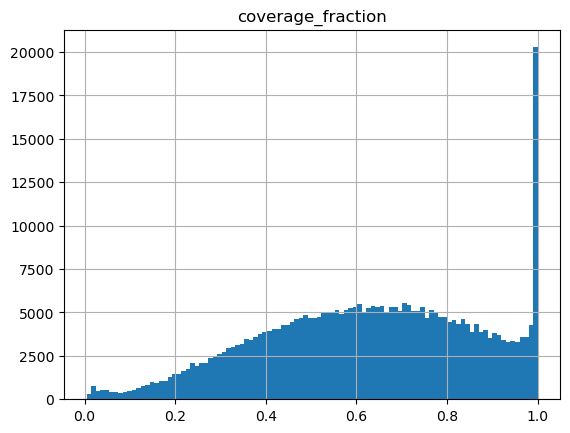

In [67]:
total_coverage_qs.hist('coverage_fraction', bins=100)

# Visualizing Graph with Network

In [ ]:
import networkx as nx
import pandas as pd
from typing import List, Any, Dict, Tuple

def make_graph_from_abc(
    A: List[Any],
    B: List[Any],
    C: List[float],
) -> Tuple[nx.Graph, Dict[Any, Tuple[float, float]]]:
    """
    Constructs a graph from three lists representing edges and their weights, 
    then returns the graph and node positions computed using the Kamada-Kawai layout.

    Parameters:
    - A: List of nodes representing the starting points of each edge.
    - B: List of nodes representing the endpoints of each edge.
    - C: List of weights corresponding to each edge.
    
    Returns:
    - A tuple containing:
        - A NetworkX graph with the given edges and weights.
        - A dictionary mapping each node to its (x, y) position from the Kamada-Kawai layout.
    """
    if not (len(A) == len(B) == len(C)):
        raise ValueError("Lists A, B, and C must all have the same length.")

    df = pd.DataFrame({
        'A': A,
        'B': B,
        'C': C
    })
    
    G = nx.Graph()
    for _, row in df.iterrows():
        G.add_edge(row['A'], row['B'], weight=row['C'])

    pos = nx.kamada_kawai_layout(G)
    return G, pos


In [99]:
ss_df = total_coverage_qs.sample(4000)

A = ss_df['qseqid']
B = ss_df['sseqid']
C = ss_df['coverage_fraction'] ** 2
G, pos = make_graph_from_abc(A=A, B=B, C=C)

KeyboardInterrupt: 

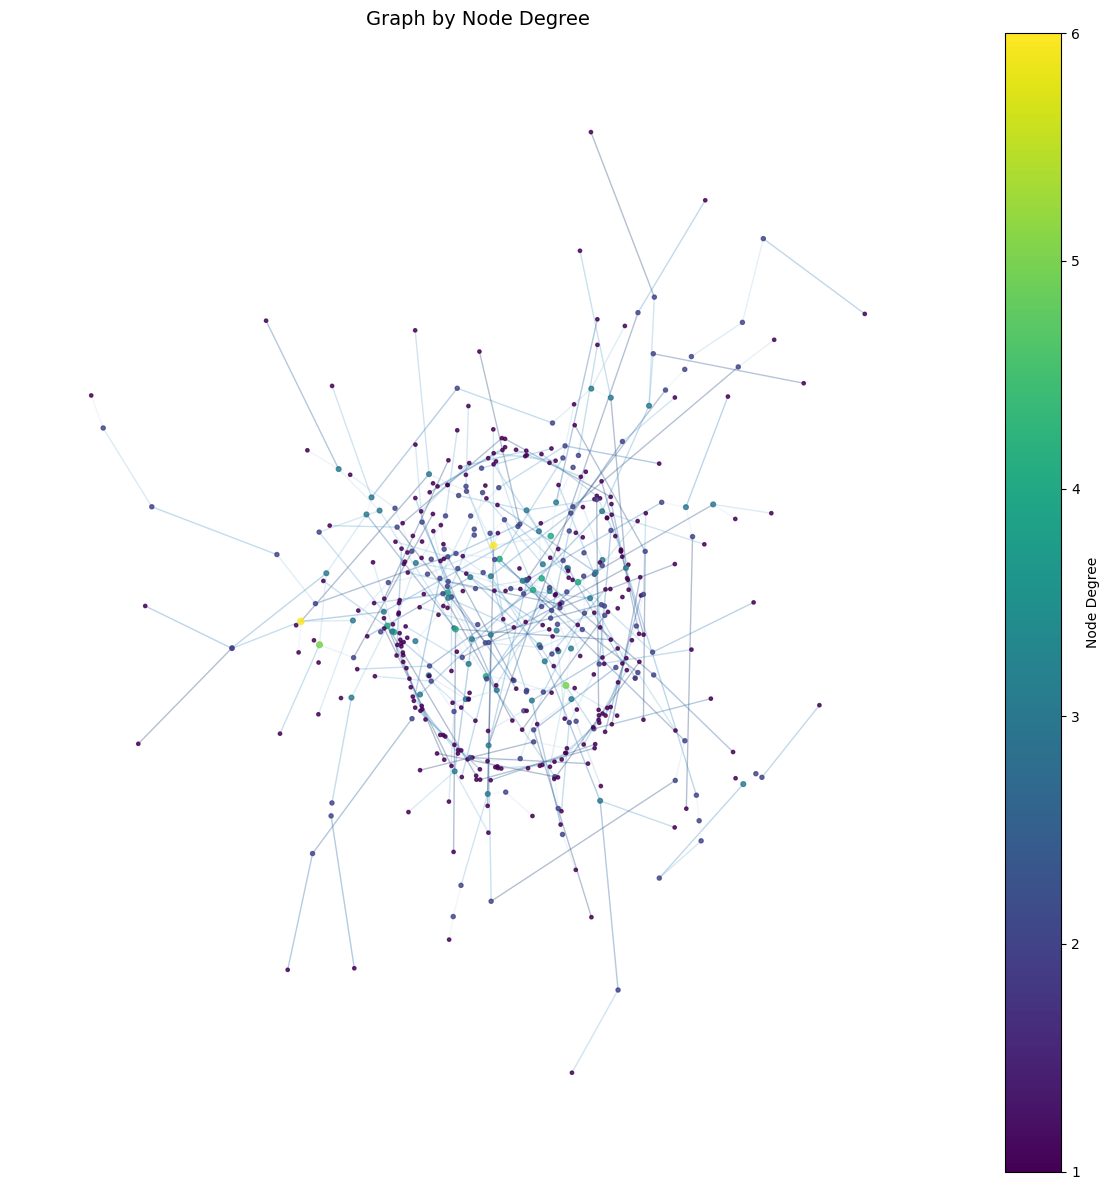

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph_by_degree(G: nx.Graph, pos: dict, node_size : int = 20 ) -> None:
    """
    Plots a NetworkX graph with nodes colored and sized based on their degree.
    
    Parameters:
    - G: A NetworkX graph.
    - pos: A dictionary mapping each node to its (x, y) position, typically generated by a layout
           function like nx.kamada_kawai_layout.
    """
    # Compute the degree for each node
    degrees = dict(G.degree())
    
    # Create a figure and axis explicitly
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Calculate node sizes relative to the maximum degree for better visibility
    if degrees:
        max_degree = max(degrees.values())
    else:
        max_degree = 1
    node_sizes = [node_size * ((degrees[node] + 1) / (max_degree + 1)) for node in G.nodes()]
    
    # Draw nodes with color mapped to the degree
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        ax=ax,
        node_size=node_sizes,
        node_color=list(degrees.values()),
        cmap=plt.cm.viridis,
        alpha=0.8
    )
    
    # Add a colorbar for node degree
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.viridis,
        norm=plt.Normalize(vmin=min(degrees.values(), default=0), vmax=max(degrees.values(), default=1))
    )
    sm.set_array([])  # Required for matplotlib compatibility
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Node Degree')
    
    # Retrieve edge weights, if any, and draw edges accordingly
    edge_weights = nx.get_edge_attributes(G, 'weight')
    if edge_weights:
        # Use edge weights to determine color: Normalize weights for the colormap
        weights = list(edge_weights.values())
        norm = plt.Normalize(min(weights), max(weights))
        edge_colors = [plt.cm.Blues(norm(weight)) for weight in weights]
        edgelist = list(edge_weights.keys())
        nx.draw_networkx_edges(
            G,
            pos,
            ax=ax,
            edgelist=edgelist,
            edge_color=edge_colors,
            alpha=0.2
        )
    else:
        # Draw edges in light gray if no weights are present
        nx.draw_networkx_edges(
            G,
            pos,
            ax=ax,
            edge_color='lightgray',
            alpha=0.2
        )
    
    ax.axis('off')
    ax.set_title("Graph by Node Degree", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_graph_by_degree(G, pos)

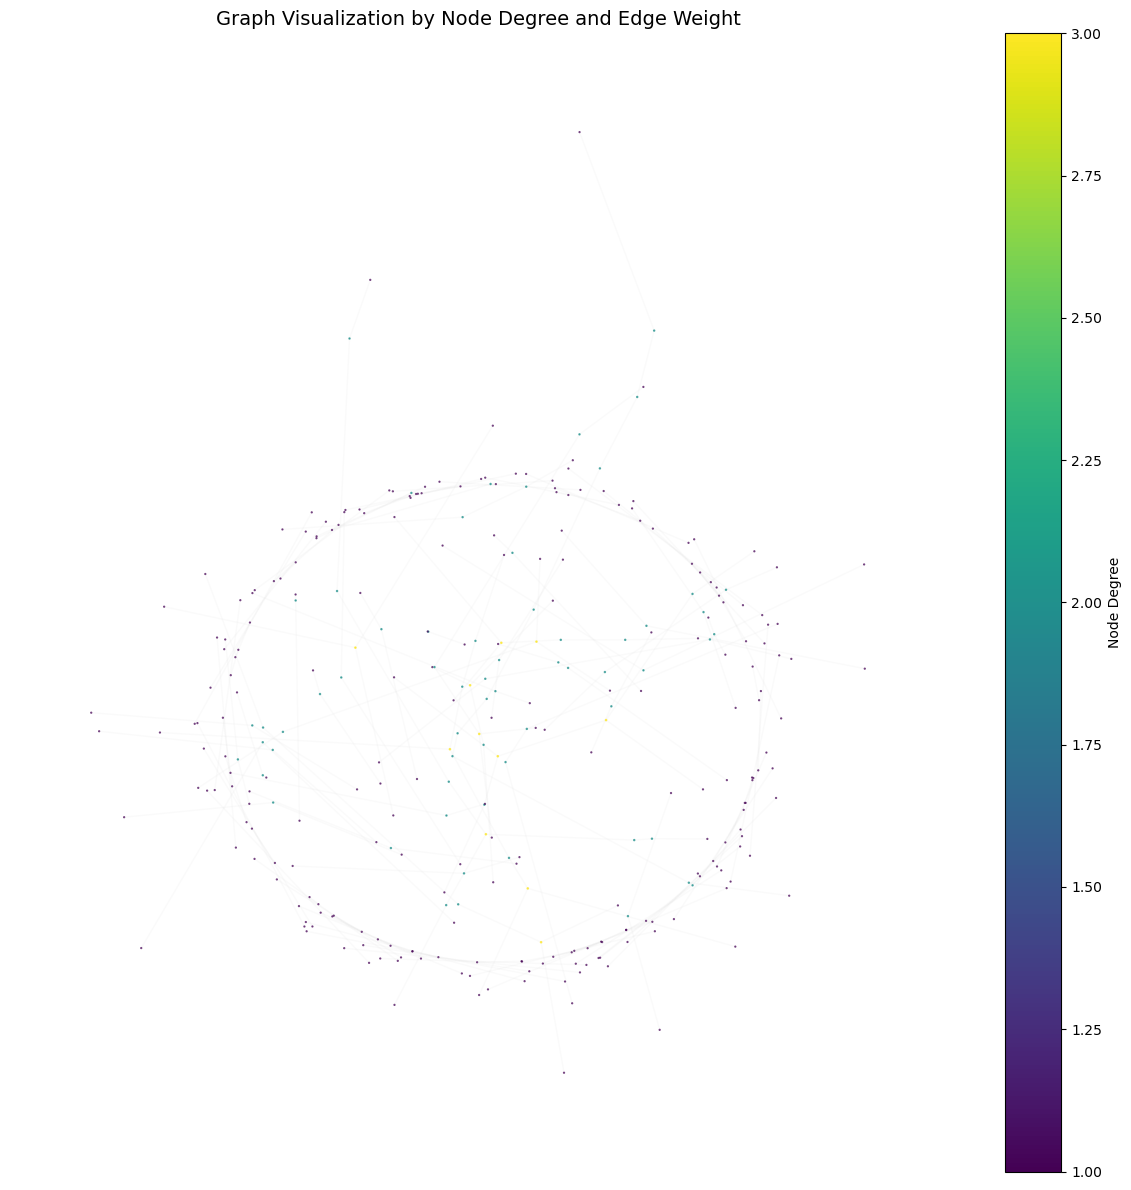

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Compute the degree for each node
degrees = dict(G.degree())

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(12, 12))

# Draw nodes with sizes and colors scaled by degree
node_sizes = [(degrees[node] + 1) * 0.20 for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,  # Pass the axis object to ensure proper plotting
    node_size=node_sizes,
    node_color=list(degrees.values()),
    cmap=plt.cm.viridis,
    alpha=0.7
)

# Create a ScalarMappable for the node degree color mapping
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=min(degrees.values()), vmax=max(degrees.values()))
)
sm.set_array([])  # Optional, but necessary for the colorbar to work

# Add a colorbar to the axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Node Degree')

# Draw edges with color mapped to their weight
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw_networkx_edges(
    G,
    pos,
    ax=ax,
    edgelist=edges,
    edge_color='lightgray',
    alpha=0.1
)

ax.axis('off')  # Hide the axis for a cleaner look
ax.set_title("Graph Visualization by Node Degree and Edge Weight", fontsize=14)
plt.tight_layout()
plt.show()

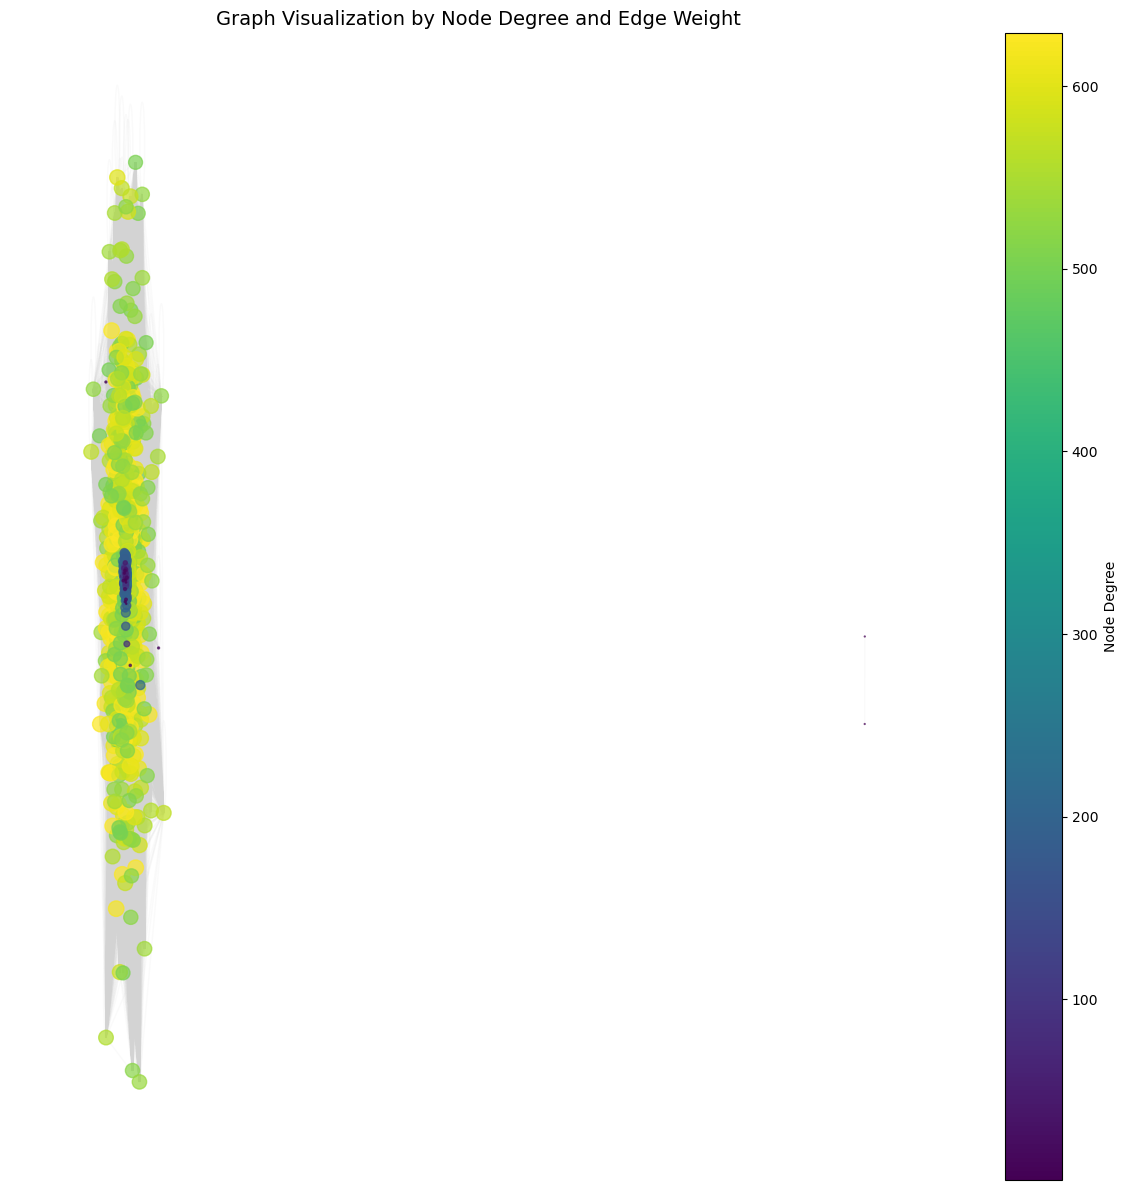

In [70]:
import matplotlib.pyplot as plt
import networkx as nx

# Compute the degree for each node
degrees = dict(G.degree())

# Create a figure and axis explicitly
fig, ax = plt.subplots(figsize=(12, 12))

# Draw nodes with sizes and colors scaled by degree
node_sizes = [(degrees[node] + 1) * 0.20 for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    ax=ax,  # Pass the axis object to ensure proper plotting
    node_size=node_sizes,
    node_color=list(degrees.values()),
    cmap=plt.cm.viridis,
    alpha=0.7
)

# Create a ScalarMappable for the node degree color mapping
sm = plt.cm.ScalarMappable(
    cmap=plt.cm.viridis,
    norm=plt.Normalize(vmin=min(degrees.values()), vmax=max(degrees.values()))
)
sm.set_array([])  # Optional, but necessary for the colorbar to work

# Add a colorbar to the axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Node Degree')

# Draw edges with color mapped to their weight
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
nx.draw_networkx_edges(
    G,
    pos,
    ax=ax,
    edgelist=edges,
    edge_color='lightgray',
    alpha=0.1
)

ax.axis('off')  # Hide the axis for a cleaner look
ax.set_title("Graph Visualization by Node Degree and Edge Weight", fontsize=14)
plt.tight_layout()
plt.show()


# Clustering Graph with MCL

In [2]:
import subprocess 
import os, sys

input_graph_abc = '/home/jpereira/OEs/OE1.v2/Data/mcl_processing/blast_map.abc'
param_inflation = float(1.4)
output_names_tab =  '/home/jpereira/OEs/OE1.v2/Data/mcl_processing/blast_map.names.tab'
output_matrix_mci = '/home/jpereira/OEs/OE1.v2/Data/mcl_processing/blast_map.mci'
output_cluster_dump = '/home/jpereira/OEs/OE1.v2/Data/mcl_processing/dump.blast_map.mci'

os.makedirs(os.path.dirname(output_names_tab), exist_ok=True)

In [3]:
command = (f"mcxload" 
           f" -abc {input_graph_abc}"
           f" --stream-mirror"
           f" -re max" 
           f" -write-tab {output_names_tab}"
           f" -o {output_matrix_mci}"
           f" ")

try:
    subprocess.run(command, shell=True, check=True)
except subprocess.CalledProcessError as e:
    print('Error in running mcxload: ', e)
    print(f"Command {command}")

.................[mclIO] writing </home/jpereira/OEs/OE1.v2/Data/mcl_processing/blast_map.mci>
.......................................
[mclIO] wrote native interchange 906x906 matrix with 403065 entries to stream </home/jpereira/OEs/OE1.v2/Data/mcl_processing/blast_map.mci>
[mclIO] wrote 906 tab entries to stream </home/jpereira/OEs/OE1.v2/Data/mcl_processing/blast_map.names.tab>
[mcxload] tab has 906 entries


In [4]:
# Compute the rounded inflation value and construct output paths
rounded_i = round(param_inflation * 10)
mcl_output_name = f"out.{os.path.basename(output_matrix_mci)}.I{rounded_i}"
mcl_output_path = os.path.join(os.path.dirname(output_matrix_mci), mcl_output_name)

command = (f"mcl"
           f" {output_matrix_mci}"
           f" -I {param_inflation}"
           f" -o {mcl_output_path}")

try:
    subprocess.run(command, shell=True, check=True)
except subprocess.CalledProcessError as e:
    print('Error in running mcl: ', e)

# Construct the mcxdump command, ensuring proper spacing
command = (
    f"mcxdump "
    f"-icl {mcl_output_path} "
    f"-tabr {output_names_tab} "
    f"-o {output_cluster_dump}"
)

try:
    subprocess.run(command, shell=True, check=True)
    print(f"mcxdump completed successfully. Output: {output_cluster_dump}")
except subprocess.CalledProcessError as e:
    print('Error in running mcxdump:', e)

[mclIO] reading </home/jpereira/OEs/OE1.v2/Data/mcl_processing/blast_map.mci>
.......................................
[mclIO] read native interchange 906x906 matrix with 403065 entries
[mcl] pid 292856
 ite -------------------  chaos  time hom(avg,lo,hi) m-ie m-ex i-ex fmv
  1  ...................  27.79  0.12 1.32/0.25/5.05 1.20 1.14 1.14  99
  2  ...................  46.01  0.13 0.92/0.13/3.56 1.02 1.00 1.14  99
  3  ...................  53.33  0.13 0.81/0.06/1.47 1.01 1.00 1.13  99
  4  ...................  39.98  0.13 0.71/0.03/1.00 1.00 0.99 1.12  99
  5  ...................  46.99  0.13 0.57/0.05/1.00 1.01 0.98 1.11  99
  6  ...................  51.36  0.13 0.42/0.05/1.00 1.00 0.98 1.09  99
  7  ...................  45.63  0.13 0.30/0.18/1.00 1.00 0.98 1.07  98
  8  ...................  20.99  0.12 0.22/0.09/1.00 1.00 0.92 0.99  98
  9  ...................  23.34  0.11 0.20/0.10/1.00 1.00 0.82 0.81  98
 10  ...................  27.27  0.08 0.24/0.15/1.00 1.00 0.64 0.52  98
 11  .

mcxdump completed successfully. Output: /home/jpereira/OEs/OE1.v2/Data/mcl_processing/dump.blast_map.mci


[mclIO] reading </home/jpereira/OEs/OE1.v2/Data/mcl_processing/out.blast_map.mci.I14>
....
[mclIO] read native interchange 906x4 matrix with 906 entries


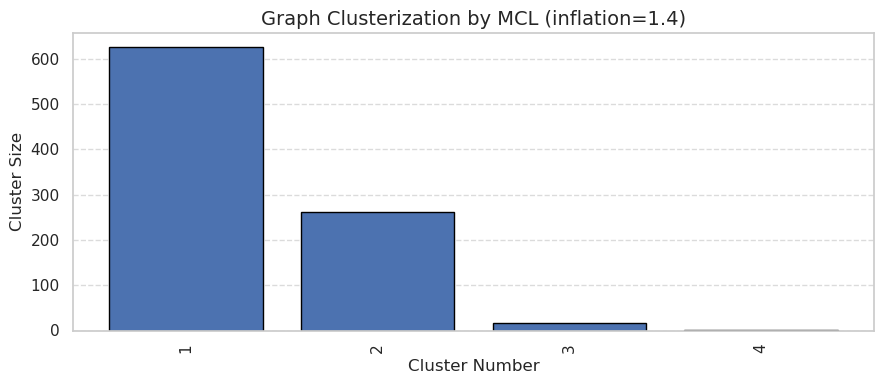

In [165]:
import matplotlib.pyplot as plt 
import numpy as np

# Assuming that output_cluster_dump and param_inflation are defined
clust_sizes = []
clust_names = []

with open(output_cluster_dump, 'r') as file:
    for line in file:
        line = line.strip()  # Remove whitespace and newlines
        split_line = line.split('\t')
        clust_names.append(split_line)
        clust_sizes.append(len(split_line))

# Use a range of integers for x-axis: cluster numbers from 1 to n
x_array = np.arange(1, len(clust_sizes) + 1)
y_array = clust_sizes

plt.figure(figsize=(9, 4))
plt.bar(x_array, y_array, edgecolor='black')

plt.xlabel('Cluster Number', fontsize=12)
plt.ylabel('Cluster Size', fontsize=12)
plt.title(f'Graph Clusterization by MCL (inflation={param_inflation})', fontsize=14)

# Optionally adjust x-tick labels; rotate if there are many clusters
plt.xticks(ticks=x_array, labels=x_array, rotation=90)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', visible=False)    
plt.tight_layout()
plt.show()


# Visualizing node degree distribution in each cluster

/tmp/ipykernel_2125026/3624499950.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_qs = group_qs_df.apply(lambda x: total_coverage_temp(x, use='subject')) \


<Figure size 2000x1000 with 0 Axes>

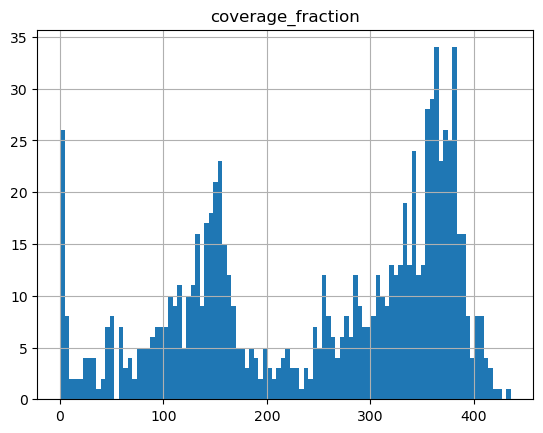

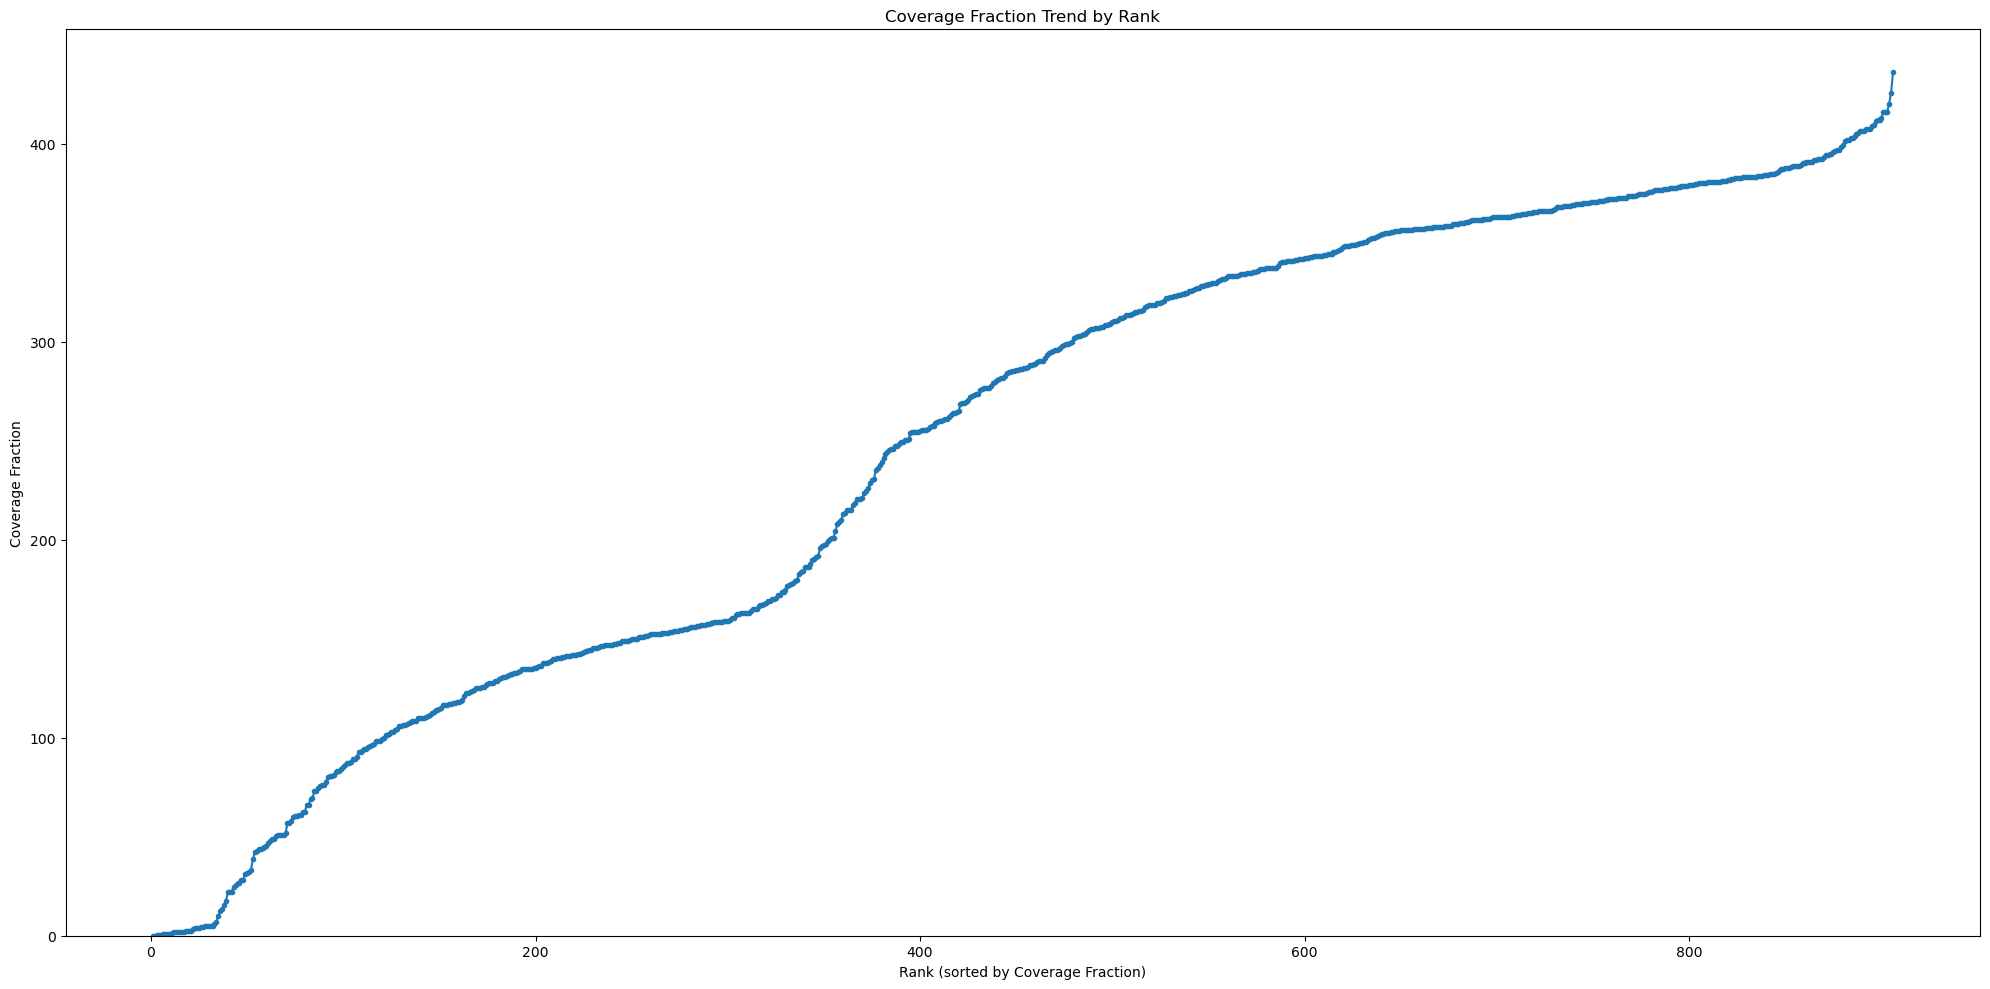

In [144]:
# Group by 'qseqid' 'sseqid' and apply the coverage function with the 'subject' parameter
group_qs_df = blast_df.groupby(['qseqid','sseqid'])
total_coverage_qs = group_qs_df.apply(lambda x: total_coverage_temp(x, use='subject')) \
                        .reset_index(name='coverage_fraction')
                        
node_degree_df = total_coverage_qs[['sseqid', 'coverage_fraction']] \
    .groupby('sseqid') \
    .sum() \
    .sort_values('coverage_fraction') \
    .reset_index()

plt.figure(figsize=(20, 10))
node_degree_df.hist(bins=100)
plt.show()
# Use the DataFrame index as the x-axis (or a range starting from 1)
plt.figure(figsize=(20, 10))
x_values = range(1, node_degree_df.shape[0] + 1)

plt.plot(x_values, node_degree_df['coverage_fraction'], marker='o', linestyle='-', markersize=3)
plt.ylim(bottom=0)
plt.xlabel("Rank (sorted by Coverage Fraction)")
plt.ylabel("Coverage Fraction")
plt.title("Coverage Fraction Trend by Rank")
plt.tight_layout()
plt.show()
    

Cluster 1: blast_df shape = (4041495, 19), cluster subset shape = (3966697, 19)
Number of sequences in cluster 1: 625


/tmp/ipykernel_2125026/3843329018.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_cl_qs = group_qs_cl_df.apply(lambda x: total_coverage_temp(x, use='subject')) \


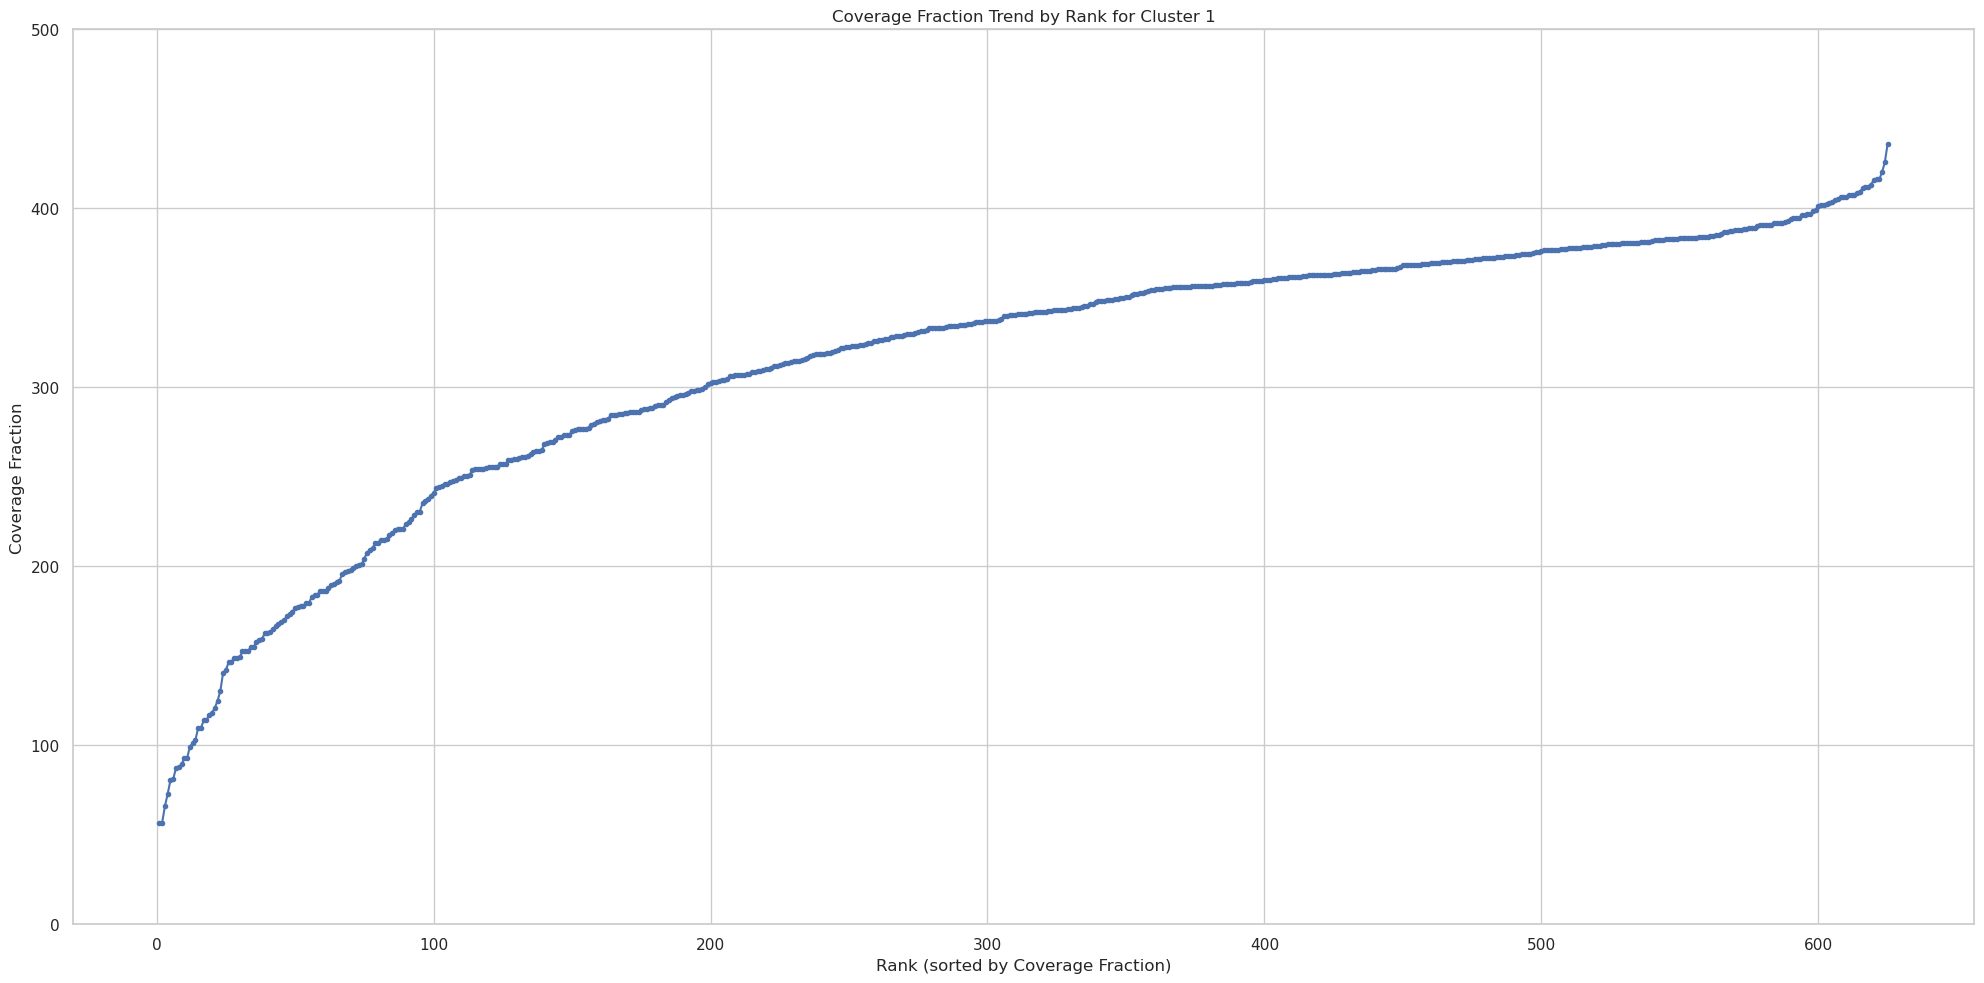

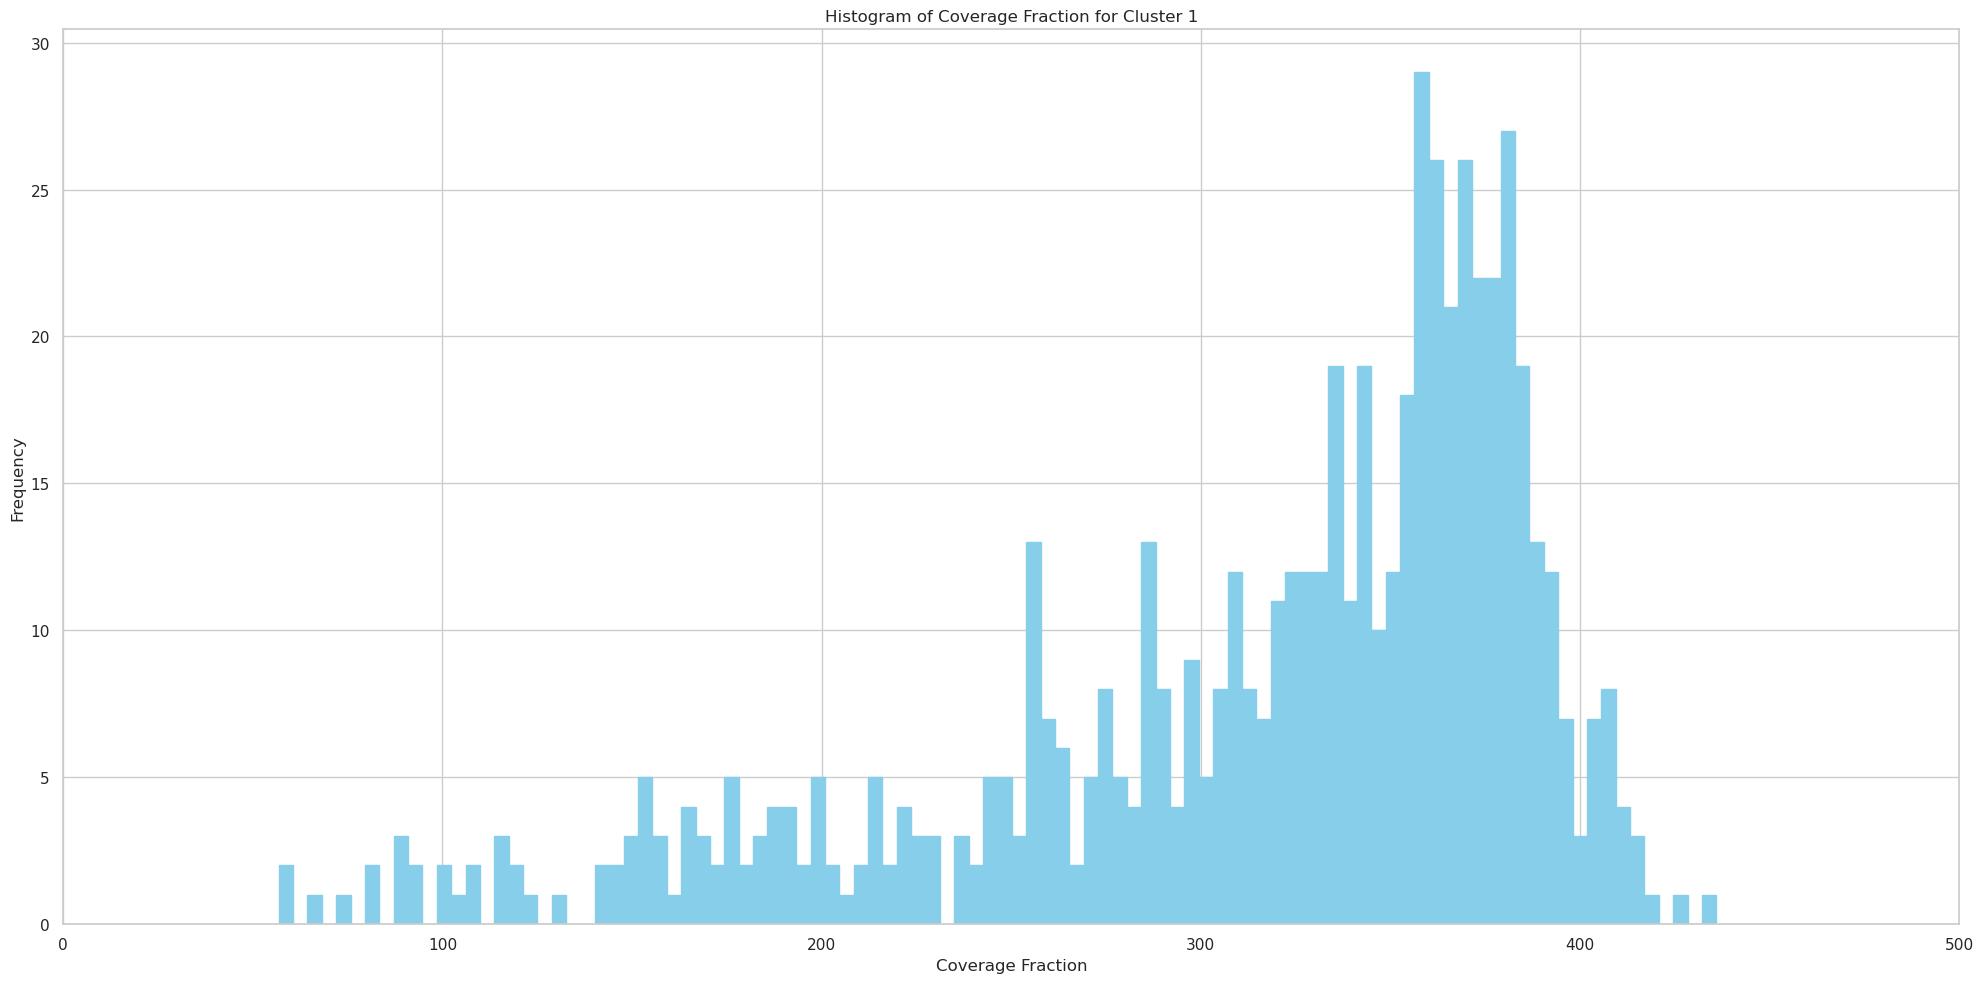

Cluster 2: blast_df shape = (4041495, 19), cluster subset shape = (73859, 19)
Number of sequences in cluster 2: 262


/tmp/ipykernel_2125026/3843329018.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_cl_qs = group_qs_cl_df.apply(lambda x: total_coverage_temp(x, use='subject')) \


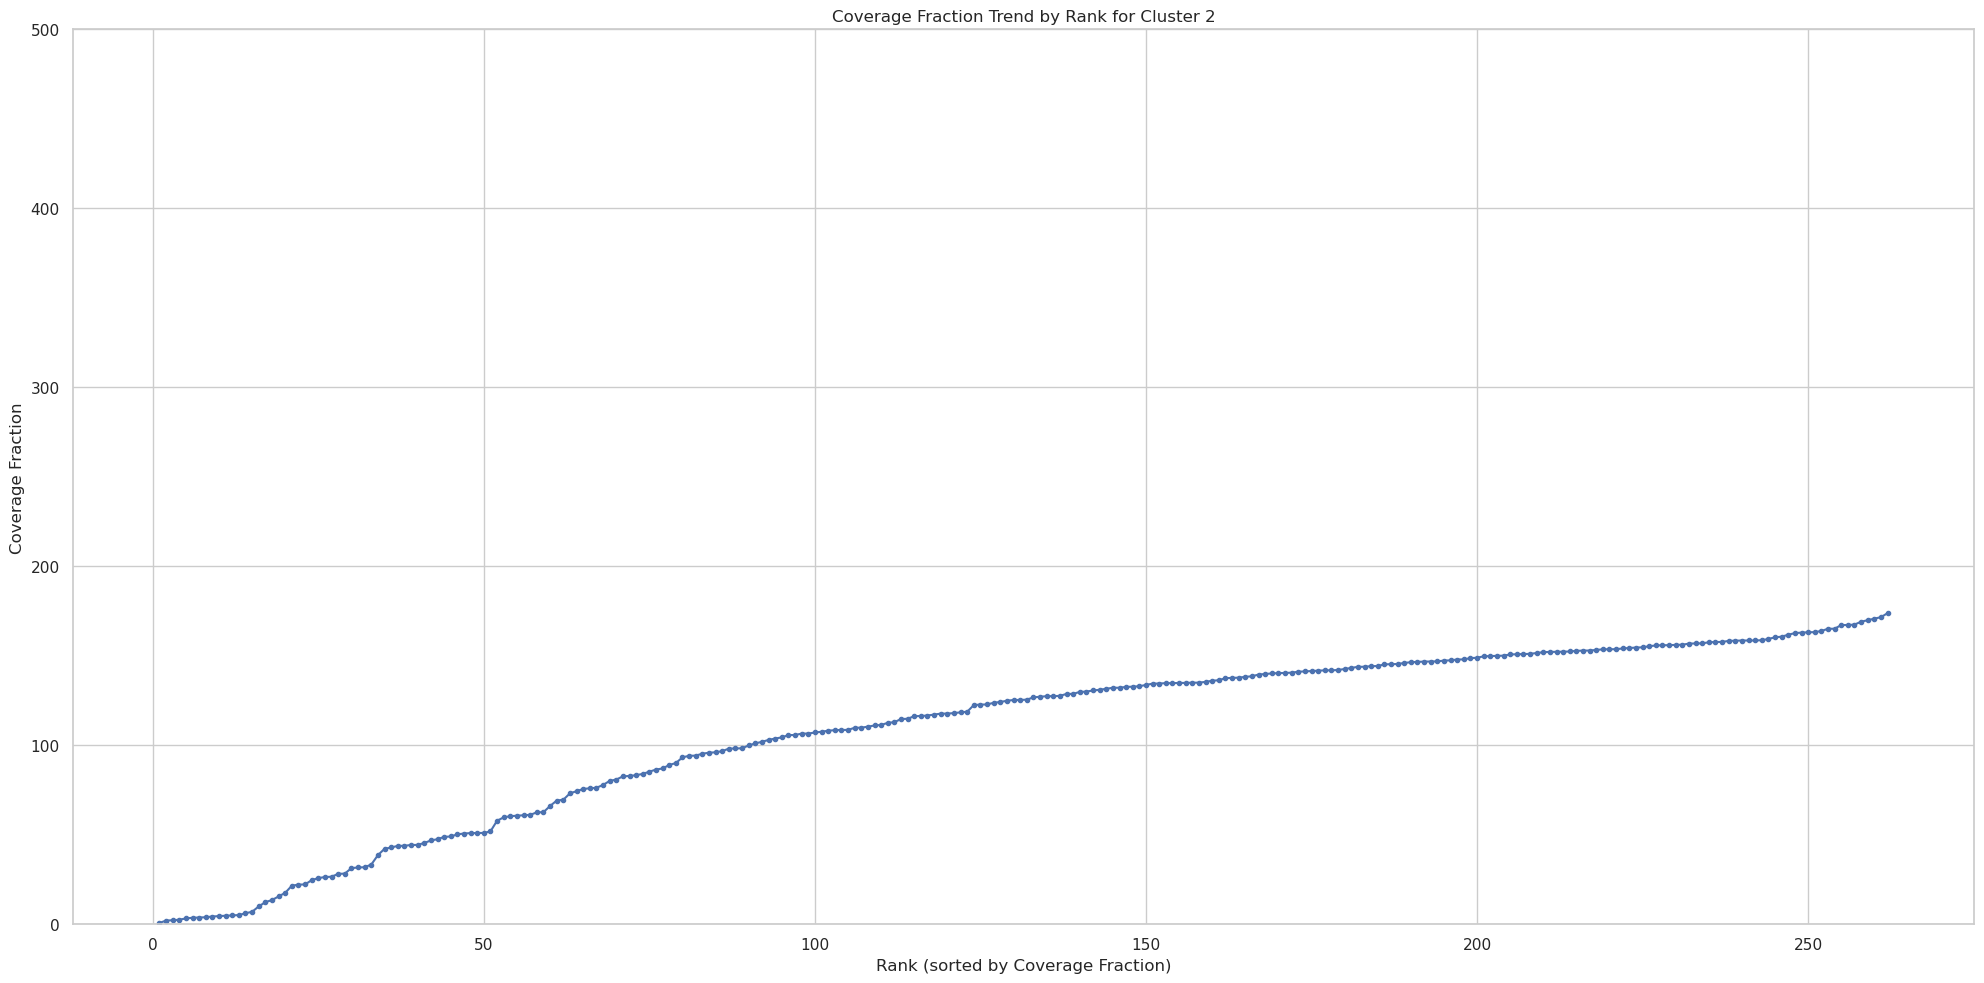

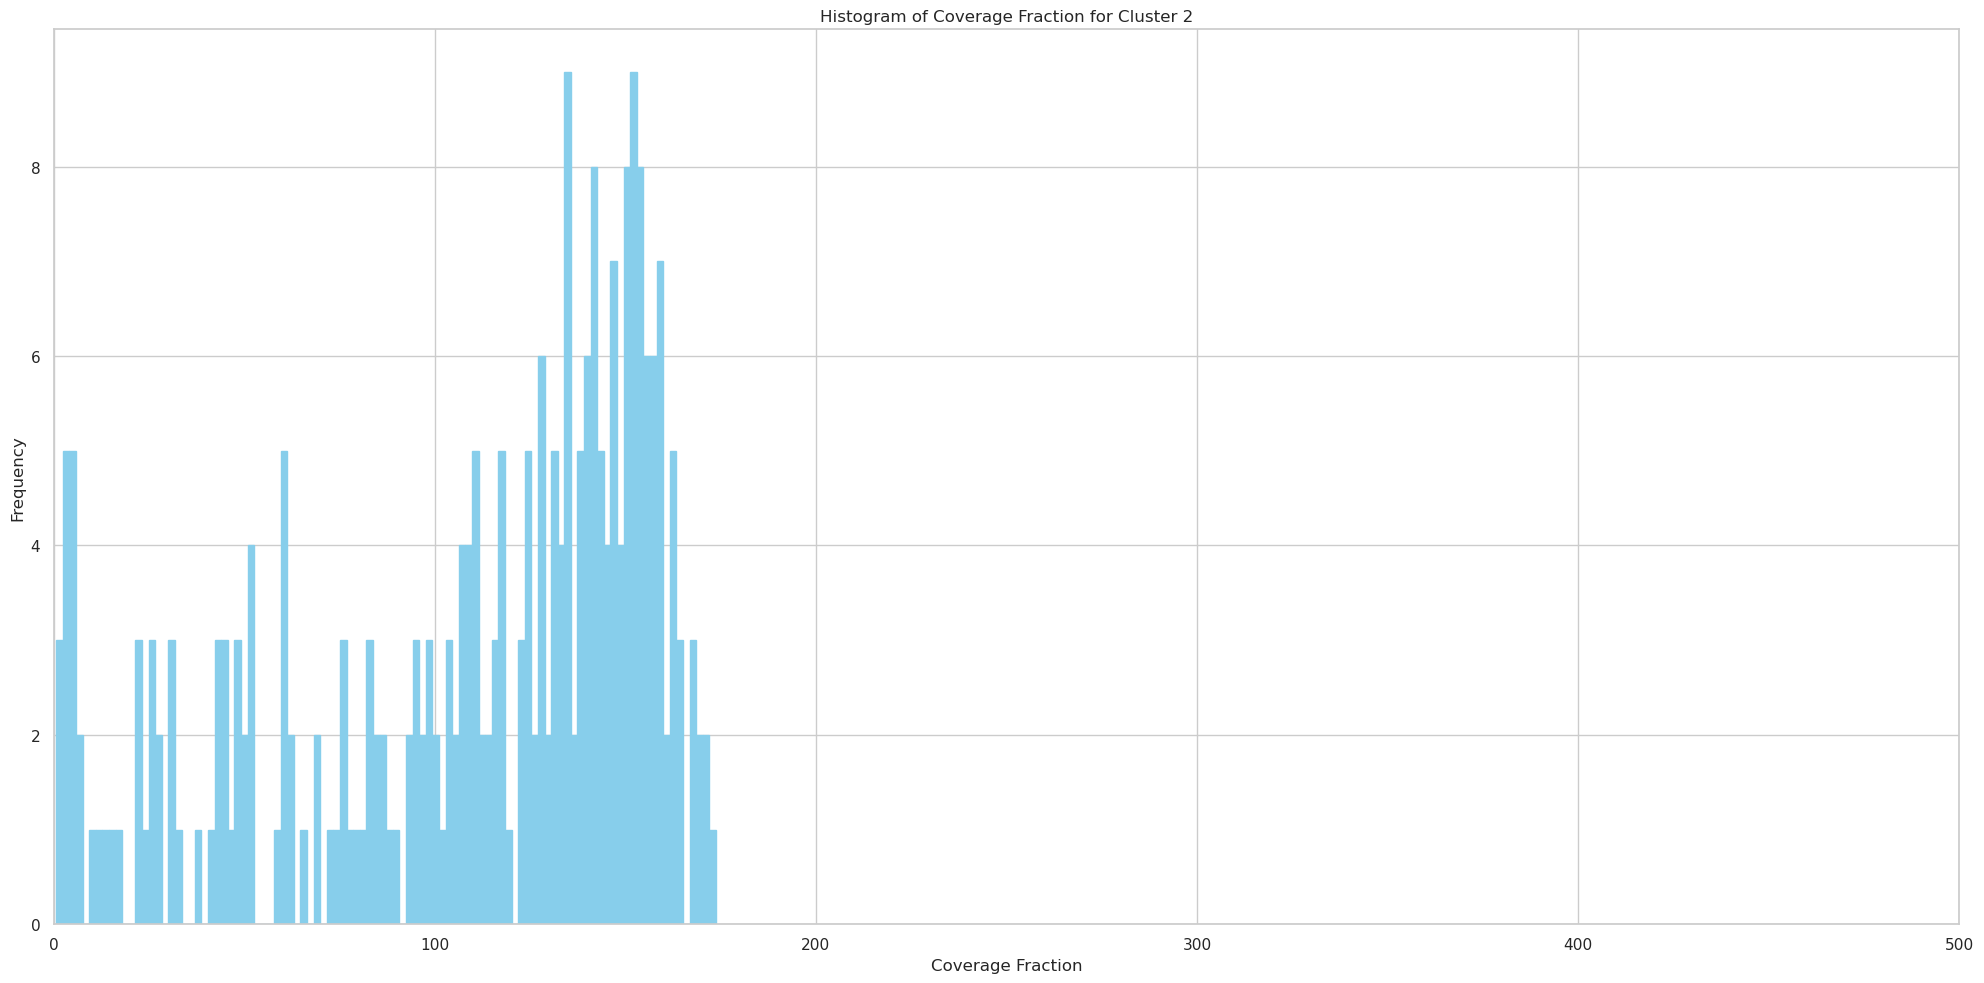

Cluster 3: blast_df shape = (4041495, 19), cluster subset shape = (124, 19)
Number of sequences in cluster 3: 17


/tmp/ipykernel_2125026/3843329018.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_cl_qs = group_qs_cl_df.apply(lambda x: total_coverage_temp(x, use='subject')) \


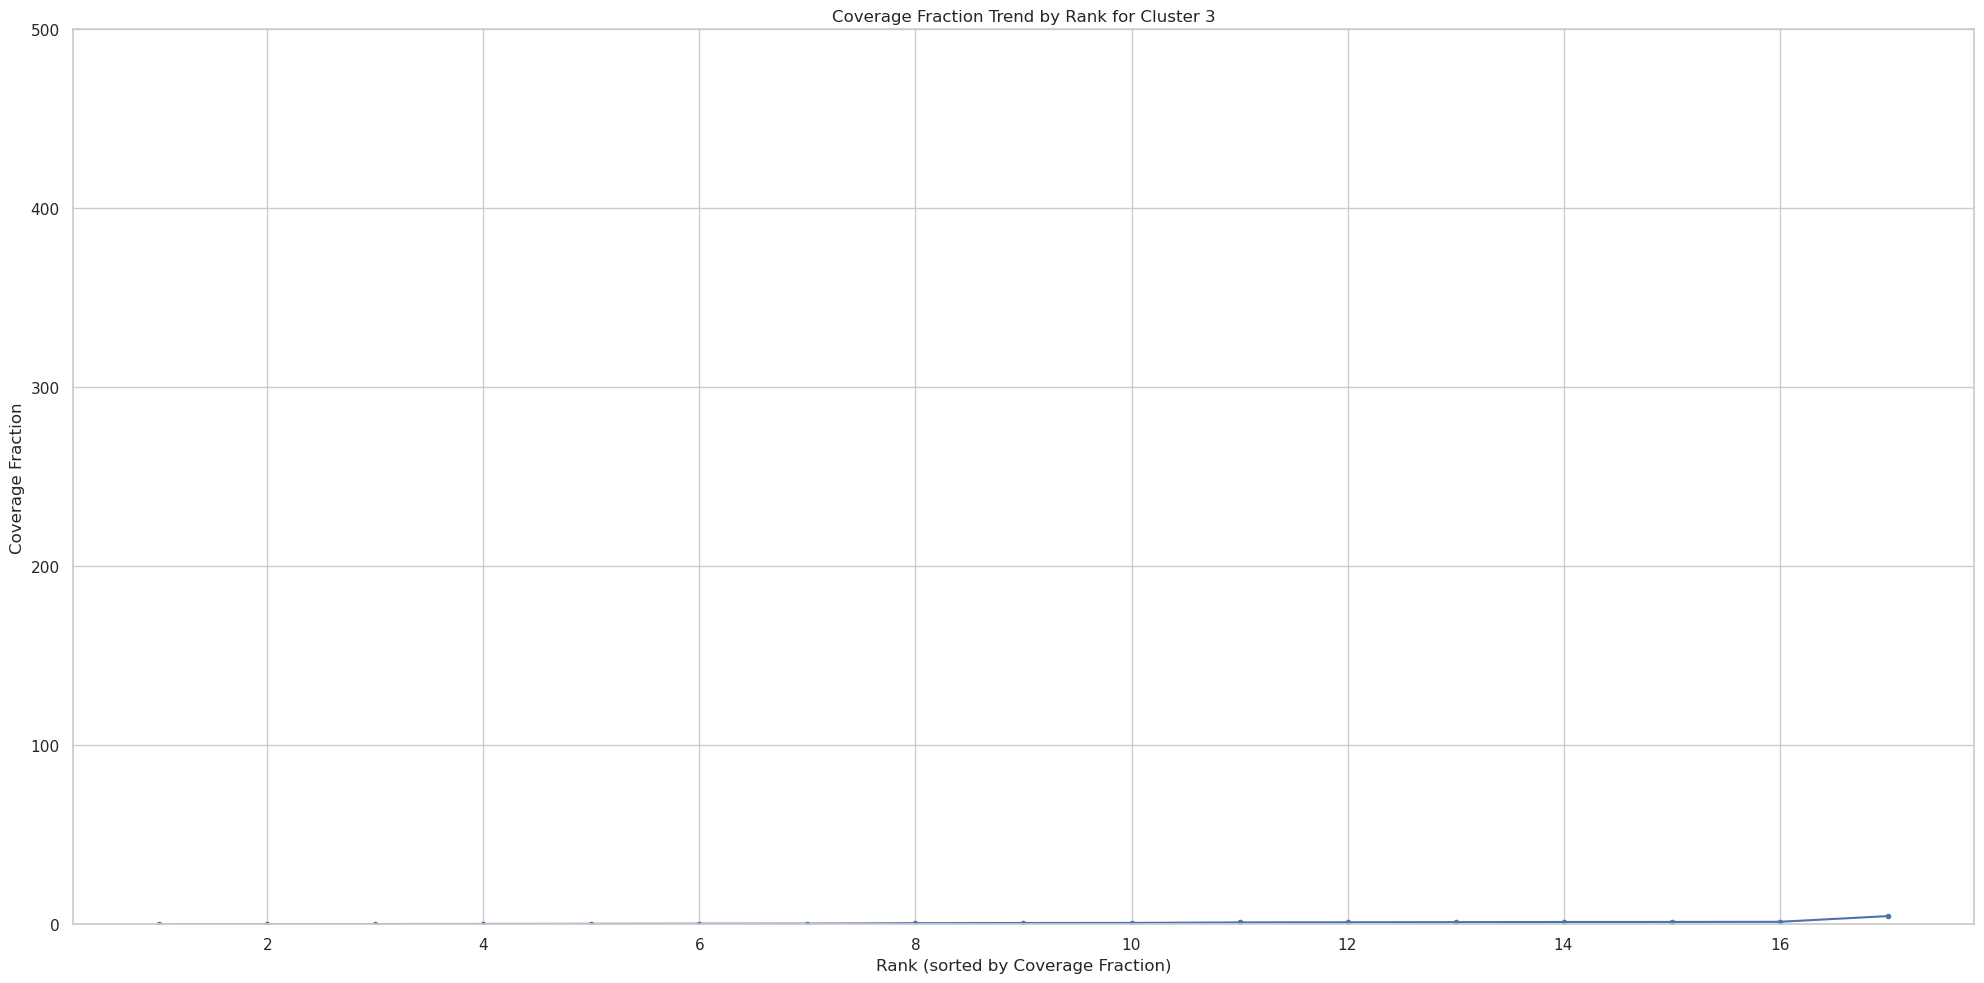

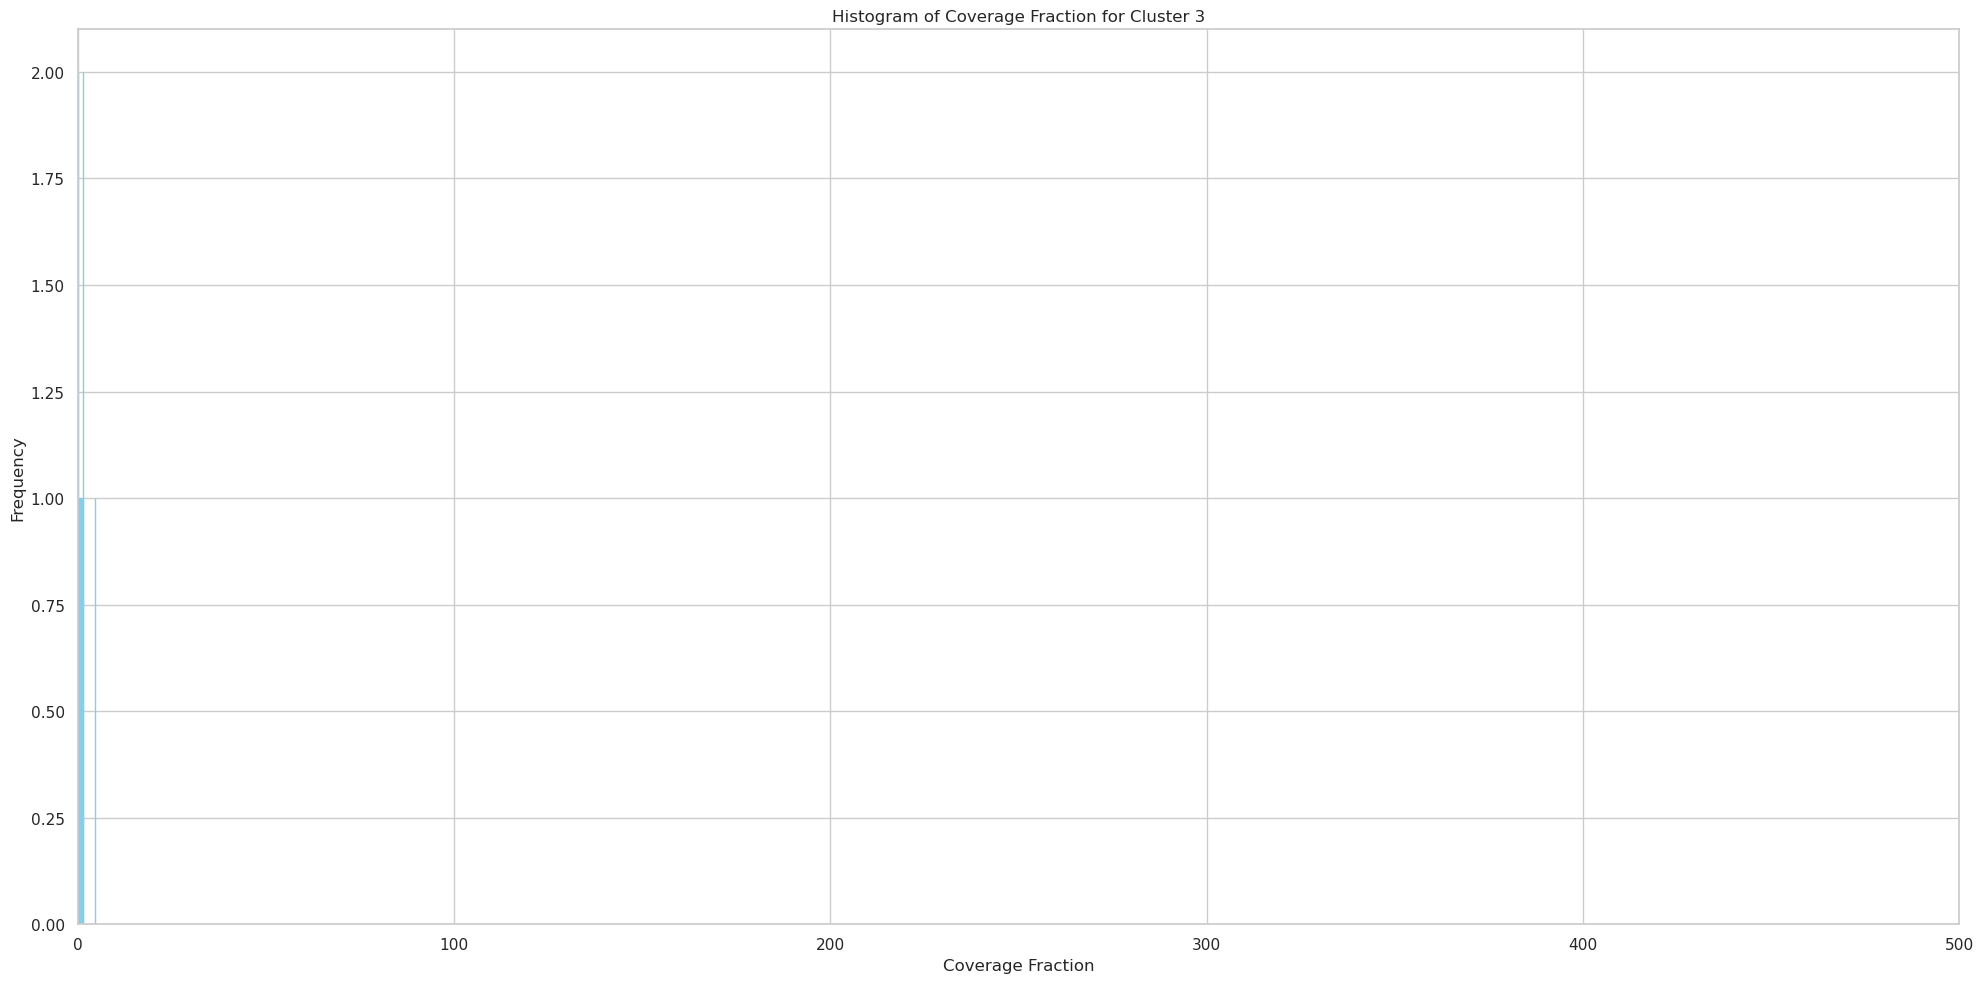

Cluster 4: blast_df shape = (4041495, 19), cluster subset shape = (4, 19)
Number of sequences in cluster 4: 2


/tmp/ipykernel_2125026/3843329018.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_cl_qs = group_qs_cl_df.apply(lambda x: total_coverage_temp(x, use='subject')) \


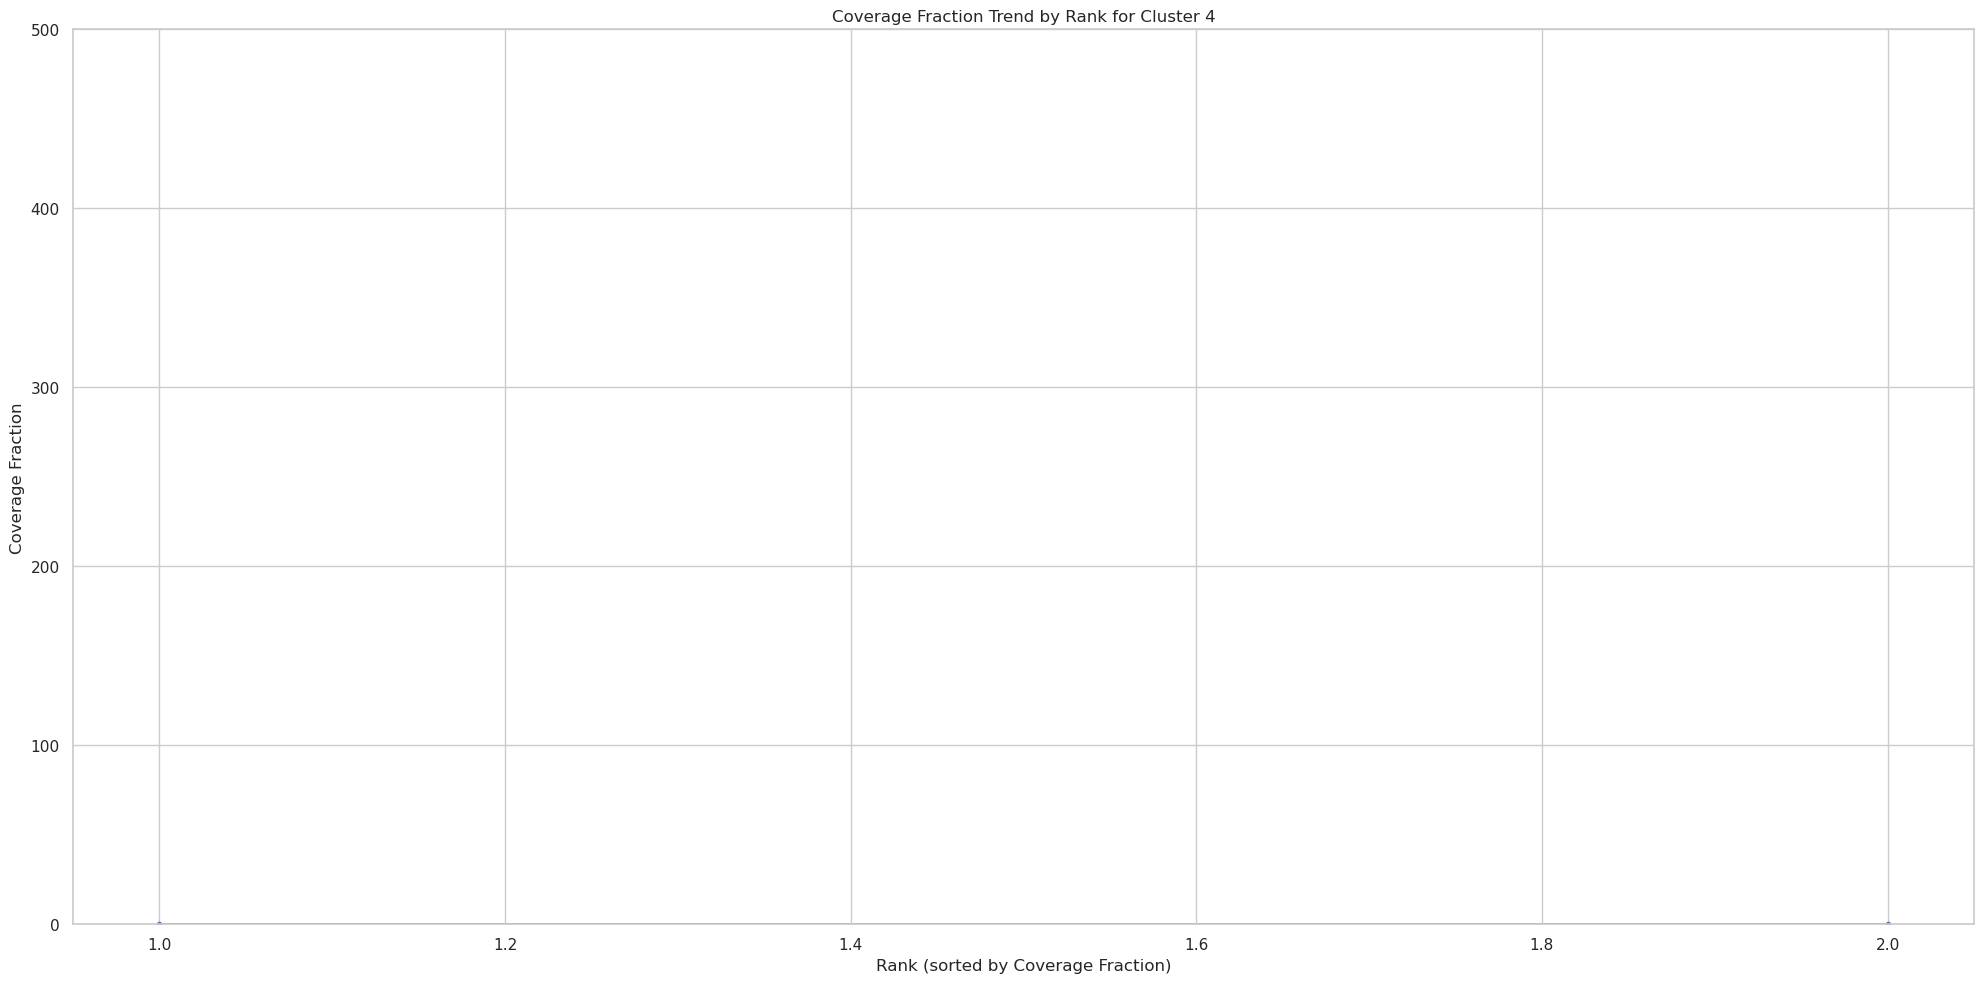

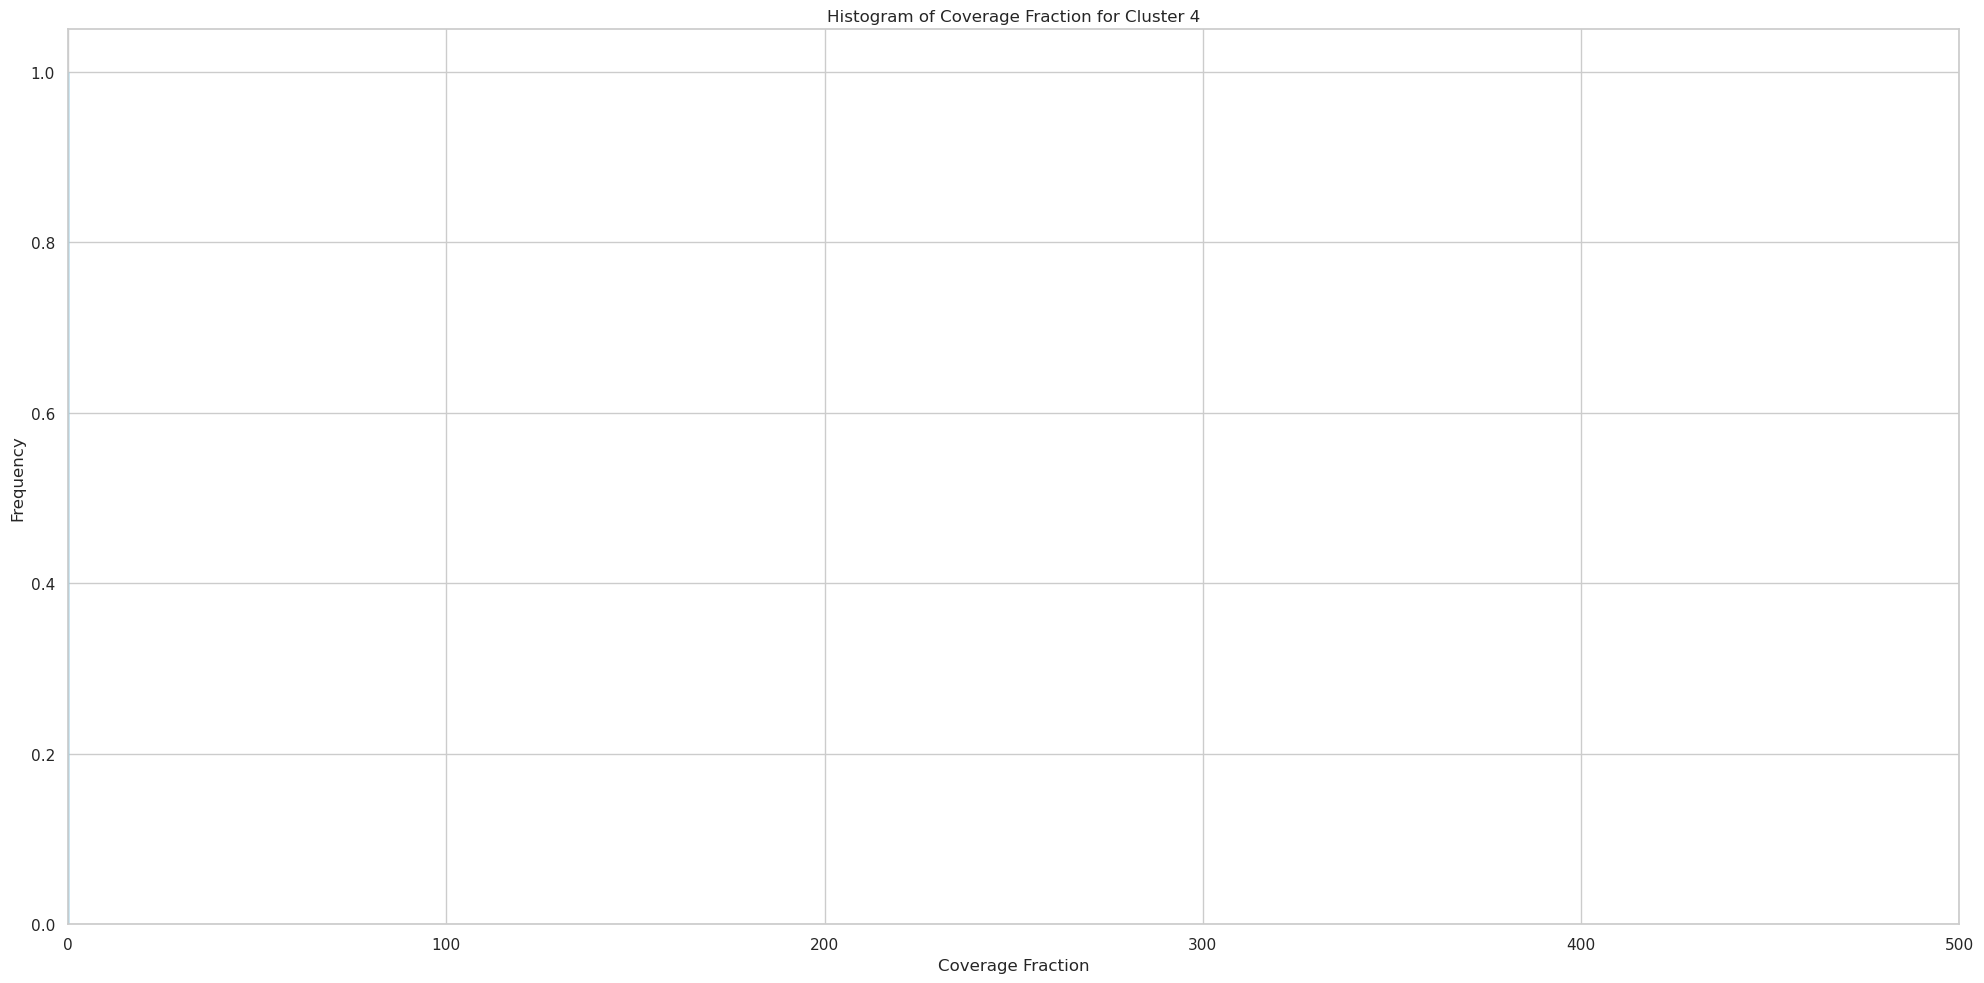

In [150]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set a seaborn theme for improved aesthetics
sns.set_theme(style="whitegrid")

def plot_cluster_coverage(blast_df, clust_names, total_coverage_temp):
    """
    For each cluster in clust_names, this function:
      - Selects rows from blast_df where both query and subject belong to the cluster.
      - Computes the coverage fraction for each (qseqid, sseqid) pair.
      - Aggregates the coverage by subject (sseqid).
      - Plots a line plot showing the coverage fraction trend by rank.
      - Plots a histogram of the coverage fractions.

    Parameters:
    - blast_df: DataFrame containing BLAST results with at least columns 'qseqid' and 'sseqid'.
    - clust_names: An iterable of cluster sets (or lists) with sequence IDs.
    - total_coverage_temp: Function that computes coverage fraction from a given DataFrame subset.
    """
    # Loop over each cluster
    for i, clust_set in enumerate(clust_names, start=1):
        # Select rows where both qseqid and sseqid belong to the current cluster
        blast_cl_df = blast_df.query('qseqid in @clust_set and sseqid in @clust_set').reset_index(drop=True)
        
        print(f'Cluster {i}: blast_df shape = {blast_df.shape}, cluster subset shape = {blast_cl_df.shape}')
        print(f'Number of sequences in cluster {i}: {blast_cl_df["qseqid"].nunique()}')
        
        # Group by 'qseqid' and 'sseqid', then compute coverage using the provided function
        group_qs_cl_df = blast_cl_df.groupby(['qseqid', 'sseqid'])
        total_coverage_cl_qs = group_qs_cl_df.apply(lambda x: total_coverage_temp(x, use='subject')) \
                                               .reset_index(name='coverage_fraction')
        
        # Aggregate coverage by subject (sseqid)
        node_degree_df = (total_coverage_cl_qs[['sseqid', 'coverage_fraction']]
                          .groupby('sseqid')
                          .sum()
                          .sort_values('coverage_fraction')
                          .reset_index())
        
        # Plot 1: Line plot showing the Coverage Fraction Trend by Rank
        plt.figure(figsize=(20, 10))
        x_values = range(1, node_degree_df.shape[0] + 1)
        plt.plot(x_values, node_degree_df['coverage_fraction'], marker='o', linestyle='-', markersize=3)
        plt.ylim(bottom=0, top=500)
        plt.xlabel("Rank (sorted by Coverage Fraction)")
        plt.ylabel("Coverage Fraction")
        plt.title(f"Coverage Fraction Trend by Rank for Cluster {i}")
        plt.tight_layout()
        plt.show()
        
        # Plot 2: Histogram of Coverage Fractions
        plt.figure(figsize=(20, 10))
        plt.hist(node_degree_df['coverage_fraction'], bins=100, color='skyblue', edgecolor='skyblue')
        plt.ylim(bottom=0)
        plt.xlim(left=0,right=500)
        plt.xlabel("Coverage Fraction")
        plt.ylabel("Frequency")
        plt.title(f"Histogram of Coverage Fraction for Cluster {i}")
        plt.tight_layout()
        plt.show()

# Example usage:
plot_cluster_coverage(blast_df, clust_names, total_coverage_temp)


# Finding the fragments

In [41]:
internal_df = select_internal_aligns(mini_cl_df, border=15)

In [42]:
# Usage:
# Group by 'qseqid' and 'sseqid', then apply fuse_contained_alignments function
fused_df = internal_df.groupby(['qseqid', 'sseqid']).apply(fuse_contained_alignments).reset_index(drop=True)

/tmp/ipykernel_2787729/1674471424.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fused_df = internal_df.groupby(['qseqid', 'sseqid']).apply(fuse_contained_alignments).reset_index(drop=True)


In [45]:
fused_df.tail(5).sort_values(['qseqid', 'qstart'])

,qseqid,sseqid,pident,length,gapopen,mismacht,qstart,qend,sstart,send,qlen,slen,evalue,bitscore
396323,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,96.040,101,1,3,3369,3469,17,116,3979,3979,1.180000e-33,144.0
396324,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,96.875,96,0,3,3378,3473,3207,3302,3979,3979,2.900000e-37,156.0
396325,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,95.833,96,2,2,3517,3612,503,596,3979,3979,1.230000e-27,124.0
396326,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,95.294,85,0,4,3554,3638,1366,1450,3979,3979,4.910000e-27,122.0
396327,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,ffdfd18c-c882-4ce0-a27f-ffca1ced44dd,97.333,75,0,2,3738,3812,880,954,3979,3979,3.070000e-28,126.0


1. Subir Identidad a 96-97%

2. Usar parámetros restrictivos (GapOpen, GapExtend, Penalty)

3. Crear librería con regiones mapeadas

4a. ~~Dereplicar y Clusterizar#1 la librería~~

5a. ~~Mapear clusters entre sí → **Obtención de fragmentos 'Maximales'**~~

4b. Dereplicar y Denoise#2 librería

5b. Mapear dereplicas entre sí → **Obtención de Fragmentos 'Minimales'**

6b. Mapear MinFrags contra secuencias crudas

7b. Obtención de Stats:

- Identidad entre fragmentos
- Identidad entre fragmentos y Secuencias
- Matriz de Relación Posicional entre fragmentos
- Cobertura total de las secuencias
- Regiones de descubrir los (¿Nuevos Fragmentos?)
- Matriz de Máxima Superposición entre fragmentos (¿Nuevos Fragmentos?)
- Abundancia de los fragmentos

Notas adicionales:

- #1: Agrupar Secuencias Contenidas en otras
- #2: Agrupar Secuencias muy similares entre sí, tomando en cuenta su abundancia

From tha alignment table, select minimal alignments. (Alignments that doesn't contain other alignments)
Remove this fragments. They can be removed from the query sequences (this would require to redo a blastn aligment). Also they can be removed directly from the table. This would require subdivide each alignmante that has minimal fragments inside.

Also, solaped alignments can be utilized to produce minimal framents. In this case the alignments could be trimmed without the need of subdivide them into multiple fragments 

Clusterize and Denoise them.

Use this fragment clusters to descompose other fragments from the alignment table.


# Crear librería con regiones mapeades

<Axes: >

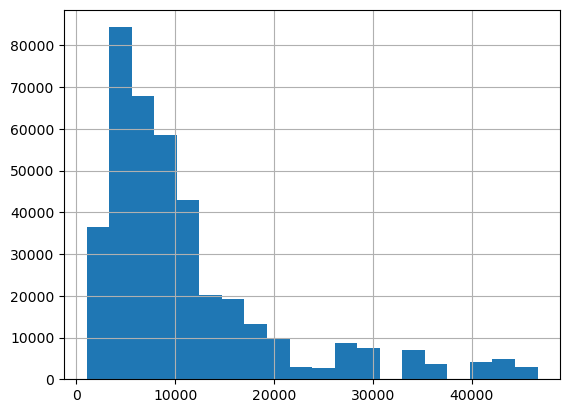

In [48]:
fused_df['qlen'].hist(bins=20)

In [50]:
import os
import subprocess

input_fasta_path = output_sample_fasta  # Path to input FASTA file
library_dir = '../Data/fragment_library/'
denoised_fragments_path = os.path.join(library_dir,'denoised_fragments.full-decont-low_gc.fasta')
extracted_regions_path = os.path.join(library_dir, 'extracted_regions.full-decont-low_gc.fasta')  # Path to output file

os.makedirs(library_dir, exist_ok=True)

bed_df = fused_df[['qseqid', 'qstart', 'qend']]
bed_df.loc[:,'qstart'] = bed_df.loc[:,'qstart'] - 1

bed_path = os.path.join(library_dir, 'fragments.bed')
bed_df.to_csv(bed_path, sep='\t', header=None, index=False)

bedtools_getfasta(fasta_path=input_fasta, bed_path=bed_path, extracted_regions_path=extracted_regions_path)


bedtools ran successfully.


In [169]:


# Construct the vsearch command
command = [
    'vsearch',
    '--cluster_unoise', extracted_regions_path,
    '--centroids', denoised_fragments_path,
    '--minseqlength', '20',      # Maybe Using a more permsive value?
    '--maxseqlength', '100000',  # Ensure numeric values are quoted in the list.
    '--minsize', '1',
    '--unoise_alpha', '3.0' 
]

# Run the command using subprocess to handle shell execution
try:
    subprocess.run(command, check=True)
    print("vsearch ran successfully.")
except subprocess.CalledProcessError as e:
    print("Error in running vsearch:", e)

vsearch_cluster_unoise(fasta_file=extracted_regions_path, fasta_denoised_file=denoised_fragments_path, unoise_alpha=1.0)


vsearch v2.29.0_linux_x86_64, 377.4GB RAM, 192 cores
https://github.com/torognes/vsearch

Reading file ../Data/fragment_library/extracted_regions.ss100-decont-low_gc.fasta 100%
512256353 nt in 396328 seqs, min 48, max 7625, avg 1293
Masking 100%
Sorting by abundance 100%
Counting k-mers 100%
Clustering 100%
Sorting clusters 100%
Writing clusters 100%
Clusters: 14723 Size min 1, max 1784, avg 26.9
Singletons: 1678, 0.4% of seqs, 11.4% of clusters


vsearch ran successfully.
Running command: vsearch --cluster_unoise ../Data/fragment_library/extracted_regions.ss100-decont-low_gc.fasta --centroids ../Data/fragment_library/denoised_fragments.ss100-decont-low_gc.fasta --maxseqlength 100000 --minseqlength 25 --minsize 1 --unoise_alpha 1.0 --threads 40 --strand both


vsearch v2.29.0_linux_x86_64, 377.4GB RAM, 192 cores
https://github.com/torognes/vsearch

Reading file ../Data/fragment_library/extracted_regions.ss100-decont-low_gc.fasta 100%
512256353 nt in 396328 seqs, min 48, max 7625, avg 1293
Masking 100%
Sorting by abundance 100%
Counting k-mers 100%
Clustering 100%
Sorting clusters 100%
Writing clusters 100%
Clusters: 14313 Size min 1, max 2211, avg 27.7
Singletons: 1679, 0.4% of seqs, 11.7% of clusters


vsearch ran successfully.


vsearch v2.28.1_linux_x86_64, 62.8GB RAM, 12 cores
https://github.com/torognes/vsearch

Reading file ../Data/fragment_library/extracted_regions.fasta 100%
19729790 nt in 29744 seqs, min 28, max 6104, avg 663
Masking 100%
Sorting by abundance 100%
Counting k-mers 100%
Clusteringvsearch ran successfully.
 100%
Sorting clusters 100%
Writing clusters 100%
Clusters: 3762 Size min 1, max 2305, avg 7.9
Singletons: 1759, 5.9% of seqs, 46.8% of clusters


In [170]:
db_basedir = os.path.dirname(denoised_fragments_path)
db_dirname = os.path.join(db_basedir, 'denoised_fragments_db')
os.makedirs(db_dirname, exist_ok=True)

db_file = os.path.basename(denoised_fragments_path)
blast_db_file = os.path.join(db_dirname, db_file)


command = (f"makeblastdb "
           f" -in {denoised_fragments_path} "
           f" -dbtype nucl "
           f" -out {blast_db_file}" )

try:
    subprocess.run(command, shell=True, check=True)
    print('makeblastdb  ran successfully.')
except subprocess.CalledProcessError as e:
    print('Error in running blastn: ', e)



Building a new DB, current time: 02/21/2025 23:48:17
New DB name:   /home/jpereira/OEs/OE1.v2/Data/fragment_library/denoised_fragments_db/denoised_fragments.ss100-decont-low_gc.fasta
New DB title:  ../Data/fragment_library/denoised_fragments.ss100-decont-low_gc.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /home/jpereira/OEs/OE1.v2/Data/fragment_library/denoised_fragments_db/denoised_fragments.ss100-decont-low_gc.fasta
Keep MBits: T
Maximum file size: 1000000000B


Adding sequences from FASTA; added 14313 sequences in 0.208048 seconds.


makeblastdb  ran successfully.


In [19]:
## Run blast using denoised_fragments.fasta as query and subject to find a group of sequences related with each other 

output_blast_tsv = os.path.join(library_dir, 'blastn.denoised_fragments_inmap.tsv')

command = (
    f"blastn "
    f"-query {denoised_fragments_path} "
    f"-db {blast_db_file} "
    f"-out {output_blast_tsv} "
    f"-num_threads 10 "
    f"-gapextend 5 "
    f"-gapopen 5 "
    f"-penalty -5 "
    f"-word_size 15 "
    f"-outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'"
    
)

try:
    subprocess.run(command, shell=True, check=True)
    print('blastn ran successfully.')
except subprocess.CalledProcessError as e:
    print('Error in running blastn: ', e)

NameError: name 'library_dir' is not defined

In [ ]:
library_dir = '/home/jpereira/OEs/OE1/Data/iteratvie_exctraction/fragment_library/'
os.makedirs(os.path.dirname(library_dir), exist_ok=True)

In [ ]:
import os
import pandas as pd

# Main workflow setup
work_name = 'ss100-decont-low_gc'
input_fragments_path = f'/home/jpereira/OEs/OE1.v2//Data/fragment_library/denoised_fragments.{work_name}.fasta'
base_dir = '/home/jpereira/OEs/OE1.v2/Data/iterative_extraction_1'
logs_dir = os.path.join(base_dir, 'logs')
os.makedirs(logs_dir, exist_ok=True)

for step in range(5):
    library_dir = os.path.join(base_dir, f'fragment_library_{step}/')
    os.makedirs(library_dir, exist_ok=True)

    # Set the input file path for subsequent steps
    if step > 0:
        input_fragments_path = os.path.join(library_dir, f'merged_frags.{work_name}.{step}.fasta')

    # Define paths for extracted regions and BLAST database output
    extracted_regions_path = os.path.join(library_dir, f'extracted_regions.{work_name}.{step}.fasta')
    sorted_regions1_path = os.path.join(library_dir, f'sorted_regions1.{work_name}.{step}.fasta')
    sorted_regions2_path = os.path.join(library_dir, f'sorted_regions2.{work_name}.{step}.fasta')
    db_outdir = os.path.join(library_dir, f'db_{work_name}.{step}')
    
    # Define paths for log files
    makeblastdb_log = os.path.join(logs_dir, f'makeblastdb_step_{step}.log')
    blastn_log = os.path.join(logs_dir, f'blastn_step_{step}.log')
    bedtools_log = os.path.join(logs_dir, f'bedtools_getfasta_step_{step}.log')
    vsearch_sort1_log =  os.path.join(logs_dir, f'vsearch_sortsize1_step_{step}.log')
    vsearch_unoise_log = os.path.join(logs_dir, f'vsearch_unoise_step_{step}.log')
    vsearch_sort2_log =  os.path.join(logs_dir, f'vsearch_sortsize2_step_{step}.log')
    vsearch_fast_log = os.path.join(logs_dir, f'vsearch_fast_step_{step}.log')

    # Step 1: Create BLAST database
    print(f'\nMAKEBLAST_DB STEP: {step}')
    blast_db_file = makeblast_db(seqs_path=input_fragments_path, db_out=db_outdir, log_file=makeblastdb_log)

    # Step 2: Perform BLASTN search
    print(f'\nBLASTN STEP: {step}')
    blast_output_table = os.path.join(library_dir, f'blastn.inner.{work_name}.{step}.tsv')
    blastn(blast_input_seqs=input_fragments_path, blast_db_file=blast_db_file, blast_output_table_tsv=blast_output_table, num_threads=15, log_file=blastn_log)

    # Step 3: Load BLAST results into a DataFrame
    blast_df = pd.read_csv(blast_output_table, sep='\t', header=None)
    blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

    # Step 4: Create BED file for sequence extraction
    bed_df = blast_df[['qseqid', 'qstart', 'qend']].copy()
    bed_df['qstart'] -= 1  # Adjust start coordinate for BED format
    bed_path = os.path.join(library_dir, f'fragments.{work_name}.{step}.bed')
    bed_df.to_csv(bed_path, sep='\t', header=None, index=False)

    # Step 5: Extract FASTA sequences based on BED coordinates
    print(f'\nBEDTOOLS_GETFASTA STEP: {step}')
    bedtools_getfasta(fasta_path=input_fragments_path, bed_path=bed_path, extracted_regions_path=extracted_regions_path, show_command=True, log_file=bedtools_log)

    # Step 6: Sort Extracted Sequence by Length
    print(f'\nVSEARCH_CLUSTER_SORT1 STEP: {step}')
    bl.vsearch_sort_by_length(fasta_file=extracted_regions_path, sorted_output_file=sorted_regions1_path, log_file=vsearch_sort1_log)

    # Step 7: Denoise extracted sequences
    denoised_fragments_path = os.path.join(library_dir, f'denoised_frags.{work_name}.{step}.fasta')
    print(f'\nVSEARCH_CLUSTER_UNOISE STEP: {step}')
    vsearch_cluster_unoise(fasta_file=sorted_regions1_path, fasta_denoised_file=denoised_fragments_path, minsize=1, log_file=vsearch_unoise_log, strand_both=True) 

    # Step 8: Sort Denoised Sequence by Length
    print(f'\nVSEARCH_CLUSTER_SORT2 STEP: {step}')
    vsearch_sort_by_length(fasta_file=denoised_fragments_path, sorted_output_file=sorted_regions2_path, log_file=vsearch_sort2_log)

    # Step 9: Cluster similar sequences and prepare for the next iteration
    next_library_dir = os.path.join(base_dir, f'fragment_library_{step+1}/')
    os.makedirs(next_library_dir, exist_ok=True)
    merged_fragments_path = os.path.join(next_library_dir, f'merged_frags.{work_name}.{step+1}.fasta')
    print(f'\nVSEARCH_CLUSTER_FAST STEP: {step}')
    vsearch_cluster_fast(
        fasta_file=sorted_regions2_path,
        fasta_clustered_file=merged_fragments_path,
        identity=0.95,
        maxseqlength=100000,
        minseqlength=25,
        sizein=False,
        sizeout=False,
        strand_both=True,  # Corrected typo
        log_file=vsearch_fast_log
    )



MAKEBLAST_DB STEP: 0
makeblastdb ran successfully.

BLASTN STEP: 0
Running: blastn -query /home/jpereira/OEs/OE1.v2//Data/fragment_library/denoised_fragments.ss100-decont-low_gc.fasta -db /home/jpereira/OEs/OE1.v2/Data/iterative_extraction_1/fragment_library_0/db_ss100-decont-low_gc.0/denoised_fragments.ss100-decont-low_gc.fasta -out /home/jpereira/OEs/OE1.v2/Data/iterative_extraction_1/fragment_library_0/blastn.inner.ss100-decont-low_gc.0.tsv -num_threads 15 -gapextend 5 -gapopen 5 -penalty -5 -word_size 25 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn ran successfully.

BEDTOOLS_GETFASTA STEP: 0
Running: bedtools getfasta -fi /home/jpereira/OEs/OE1.v2//Data/fragment_library/denoised_fragments.ss100-decont-low_gc.fasta -bed /home/jpereira/OEs/OE1.v2/Data/iterative_extraction_1/fragment_library_0/fragments.ss100-decont-low_gc.0.bed -fo /home/jpereira/OEs/OE1.v2/Data/iterative_extraction_1/fragment_library_0/extracted_

KeyboardInterrupt: 

### TODO

1. Map sequences with each other
2. Do not exclude sequences mapped with itself
3. Make a heatmap with the identities mapped
4. Visualize sequence common coverage (line map)
5. Map fragments to original sequences
    -Total coverage
    -Total of coverage by full blocks
6. Find empty spaces (extrac sequences)
7. Join fragment that are alway toghether

8. Make a poster with the results

In [ ]:
auto_blocks_path = f'/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Block_extension/blocks.fasta'

In [60]:
from utils.blast_utils import blastn_subject, alignment_absolute_start_end
import os
import pandas as pd

work_name = 'auto-nm_blocks_25_06_18'
#work_name = 'auto-nm_post_extend_blocks_25_06_18'

auto_blocks_path = '/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/retrieve/regions.fasta' 
#auto_blocks_path = '/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Block_extension/blocks.fasta' 
auto_blocks_blastn_tsv = f'/home/jpereira/OEs/OE1/Data/blocks_visuals/blastn.{work_name}.fasta'
os.makedirs(os.path.dirname(auto_blocks_blastn_tsv), exist_ok=True)
blastn_subject(blast_input_seqs=auto_blocks_path, 
               blast_subject_seqs=auto_blocks_path,
               blast_output_table_tsv=auto_blocks_blastn_tsv,
               word_size=20)

nam_blocks_path = f'/home/jpereira/OEs/Blocks_Namasivayam.fa'
nam_vs_auto_blocks_blastn_tsv = f'/home/jpereira/OEs/OE1/Data/iterative_extraction/blocks_visuals/blastn.Nam_vs_{work_name}.fasta'
os.makedirs(os.path.dirname(nam_vs_auto_blocks_blastn_tsv), exist_ok=True)
blastn_subject(blast_input_seqs=nam_blocks_path, blast_subject_seqs=auto_blocks_path,blast_output_table_tsv=nam_vs_auto_blocks_blastn_tsv, word_size=25)

#nam_blocks_path = f'/home/jpereira/OEs/Blocks_Namasivayam.fa'
#nam_vs_nam_blocks_blastn_tsv = f'/home/jpereira/OEs/OE1/Data/iterative_extraction/blocks_visuals/blastn.Nam_vs_Nam.tsv'
#os.makedirs(os.path.dirname(nam_vs_nam_blocks_blastn_tsv), exist_ok=True)
#blastn_subject(blast_input_seqs=nam_blocks_path, blast_subject_seqs=nam_blocks_path,blast_output_table_tsv=nam_vs_nam_blocks_blastn_tsv, word_size=25)


# Loaded Blastn table with extended blocks
blastn_autobl_df = pd.read_csv(auto_blocks_blastn_tsv, sep='\t', header=None)
blastn_autobl_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

# Loaded Blastn table with denoised fragments
blastn_nam_autobl_df = pd.read_csv(nam_vs_auto_blocks_blastn_tsv, sep='\t', header=None)
blastn_nam_autobl_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

##Loaded Blastn table with denoised fragments
#blastn_nam_nam_df = pd.read_csv(nam_vs_nam_blocks_blastn_tsv, sep='\t', header=None)
#blastn_nam_nam_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
#                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']


Running: blastn -query /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/retrieve/regions.fasta -subject /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/retrieve/regions.fasta -out /home/jpereira/OEs/OE1/Data/blocks_visuals/blastn.auto-nm_blocks_25_06_18.fasta -reward 1 -gapextend 2 -gapopen 5 -penalty -2 -word_size 20 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn_subject ran successfully.
Running: blastn -query /home/jpereira/OEs/Blocks_Namasivayam.fa -subject /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/retrieve/regions.fasta -out /home/jpereira/OEs/OE1/Data/iterative_extraction/blocks_visuals/blastn.Nam_vs_auto-nm_blocks_25_06_18.fasta -reward 1 -gapextend 2 -gapopen 5 -penalty -2 -word_size 25 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn_subject 

In [61]:
# Read the data
df = blastn_autobl_df.copy()
df = blastn_nam_autobl_df.copy()

df['minus_qstart'] = df['qstart'] * (-1)
df = df.sort_values(['qlen', 'minus_qstart'], ascending=False)


#blastn_nam_autobl_df['minus_qstart'] = blastn_nam_autobl_df['qstart'] * (-1)
df = alignment_absolute_start_end(df)

# Adding first ocurrence of each element in a Series, the objective
# is to conserve the original order of qseqid and sseqid columns
qseqid_order = df['qseqid'].unique() 
sseqid_order = df['sseqid'].unique() 

# Step 1: Compute the mean `qlen` for each `qseqid`
qlen_serie = df.groupby('qseqid')['qlen'].mean()#.sort_values(ascending=False)
slen_serie = df.groupby('sseqid')['slen'].mean()#.sort_values(ascending=False)

# Sorting qlen_serie and slen_serie given qseqid_order and sseqid_order arrays
qlen_serie = qlen_serie.reindex(qseqid_order)
slen_serie = slen_serie.reindex(sseqid_order)

# Step 2: Compute the cumulative sum
cumsum_qlen = qlen_serie.cumsum().shift(1).fillna(0)
cumsum_slen = slen_serie.cumsum().shift(1).fillna(0)

cumsum_slen = cumsum_slen.reset_index()
cumsum_qlen = cumsum_qlen.reset_index()

cumsum_slen.columns =  ['sseqid', 'cumsum_slen' ]
cumsum_qlen.columns =  ['qseqid', 'cumsum_qlen' ]

df = pd.merge(df, cumsum_slen, on='sseqid', how='left')
df = pd.merge(df, cumsum_qlen, on='qseqid', how='left')


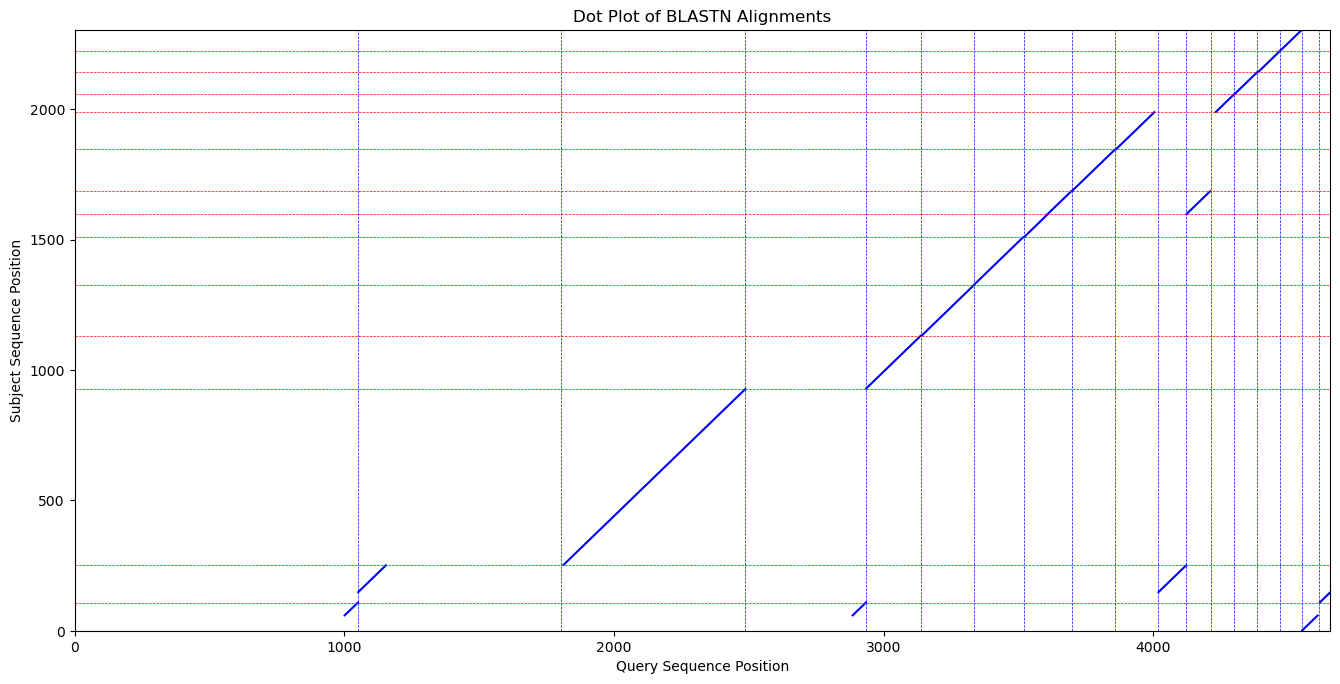

In [62]:
import matplotlib.pyplot as plt

query_fig_scale   = cumsum_qlen.iloc[-1, 1]  / (cumsum_slen.iloc[-1, 1] + cumsum_qlen.iloc[-1, 1])
subject_fig_scale = cumsum_slen.iloc[-1, 1]  / (cumsum_slen.iloc[-1, 1] + cumsum_qlen.iloc[-1, 1])

fig, ax = plt.subplots(figsize=(24 * query_fig_scale, 24 * subject_fig_scale))

# Define custom x and y axis limits
df['cumsum_qlen_a.qend'] = df['cumsum_qlen'] + df['a.qend']
df['cumsum_slen_a.send'] = df['cumsum_slen'] + df['a.send']
x_min, x_max = 0, df['cumsum_qlen_a.qend'].max()
y_min, y_max = 0, df['cumsum_slen_a.send'].max()

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Plot each alignment as a line
for index, row in df.iterrows():
    plt.plot([row['qstart'] + row['cumsum_qlen'],
                row['qend'] + row['cumsum_qlen']],
                [row['a.sstart'] + row['cumsum_slen'],
                row['a.send'] + row['cumsum_slen']], 
                linestyle='-', color='blue')

# Add sequence boundaries
for pos in df['cumsum_qlen'].unique():
    ax.axvline(x=pos, color='blue', linestyle='--', linewidth=0.5)

for pos in df['cumsum_slen'].unique():
    ax.axhline(y=pos, color='red', linestyle='--', linewidth=0.5)
plt.xlabel('Query Sequence Position')
plt.ylabel('Subject Sequence Position')
plt.title('Dot Plot of BLASTN Alignments')
plt.grid(False)
plt.show()

Running: blastn -query /home/jpereira/OEs/Blocks_Namasivayam.fa -subject /home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/retrieve/regions.fasta -out /home/jpereira/Results/OE1/NamSeqs/Visuals/Blocks/extended_clustered_seeds_1/blastn.fasta1_vs_fasta2.tsv -reward 1 -gapextend 2 -gapopen 5 -penalty -2 -word_size 15 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn_subject ran successfully.
Dotplot Saved in: /home/jpereira/Results/OE1/NamSeqs/Visuals/Blocks/extended_clustered_seeds_1/dotplot.svg


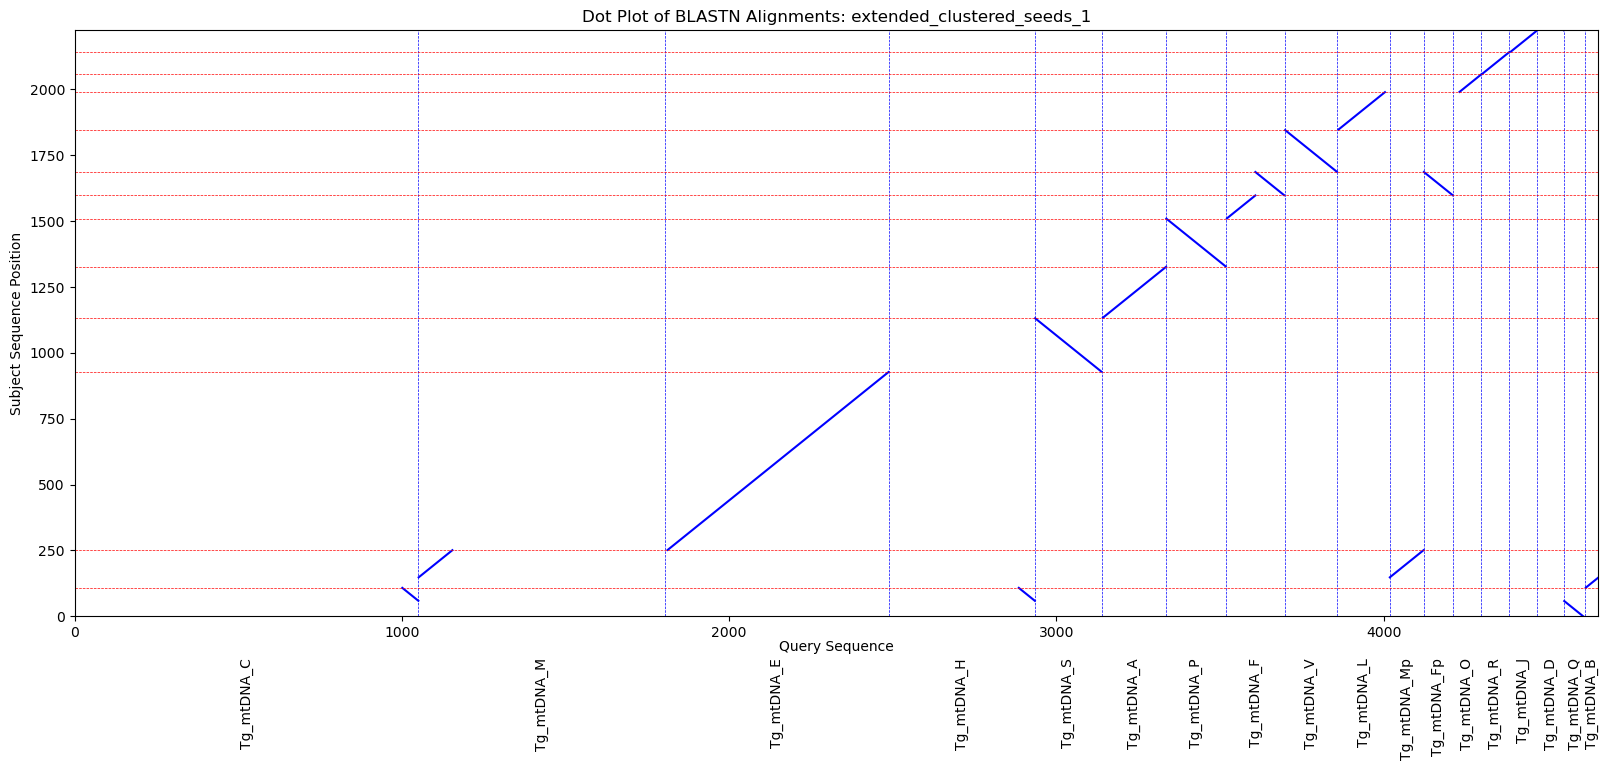

In [ ]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
from utils.blast_utils import blastn_subject, alignment_absolute_start_end

def blastn_dotplot(
    work_name: str,
    fasta1: str,
    fasta2: str,
    output_base_dir: str,
    word_size: int = 20,
    qnames: bool = False,
    snames: bool = False,
):
    """
    Run two BLASTn searches (auto vs. auto, nam vs. auto), load results,
    compute cumulative positions, and plot a dot-plot of alignments.

    Parameters
    ----------
    work_name : str
        Identifier for naming output files.
    fasta1 : str
        Path to a FASTA file with one or more sequences.
    fasta2 : str
        Path to a FASTA file with one or more sequences.
    output_base_dir : str
        Base directory under which BLAST output TSVs and visuals will be saved.
    word_size_auto : int, optional
        BLASTn word size for the auto-auto comparison (default=20).
    word_size_nam : int, optional
        BLASTn word size for the Nam-vs-auto comparison (default=20).
    """
    # Prepare output paths
    base = Path(output_base_dir)
    workdir = base / work_name
    
    workdir.mkdir(exist_ok=True, parents=True)
    blast_tsv  = workdir / f"blastn.fasta1_vs_fasta2.tsv"

    # Run BLASTn
    blastn_subject(
        blast_input_seqs=fasta1,
        blast_subject_seqs=fasta2,
        blast_output_table_tsv=blast_tsv,
        word_size=word_size
    )

    # Load results
    df = pd.read_csv(blast_tsv, sep='\t', header=None)
    df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen',
        'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

    # Sort and compute absolute start/end
    df['minus_qstart'] = -df['qstart']
    df = df.sort_values(['qlen', 'minus_qstart'], ascending=False)
    df = alignment_absolute_start_end(df)

    # Compute cumulative offsets for each sequence
    q_order = df['qseqid'].unique()
    s_order = df['sseqid'].unique()
    qlen_mean = df.groupby('qseqid')['qlen'].mean().reindex(q_order)
    slen_mean = df.groupby('sseqid')['slen'].mean().reindex(s_order)

    cumsum_q = qlen_mean.cumsum().shift(1).fillna(0).reset_index()
    cumsum_s = slen_mean.cumsum().shift(1).fillna(0).reset_index()
    cumsum_q.columns = ['qseqid', 'cumsum_qlen']
    cumsum_s.columns = ['sseqid', 'cumsum_slen']

    df = df.merge(cumsum_q, on='qseqid').merge(cumsum_s, on='sseqid')

    # Prepare plot scaling
    total_q = cumsum_q['cumsum_qlen'].iat[-1]
    total_s = cumsum_s['cumsum_slen'].iat[-1]
    fig_scale_q = total_q / (total_q + total_s)
    fig_scale_s = total_s / (total_q + total_s)

    # Add cumulative positions to endpoints
    df['x_start'] = df['cumsum_qlen'] + df['qstart']
    df['x_end']   = df['cumsum_qlen'] + df['qend']
    df['y_start'] = df['cumsum_slen'] + df['sstart']
    df['y_end']   = df['cumsum_slen'] + df['send']

    # Plot
    fig, ax = plt.subplots(figsize=(24 * fig_scale_q, 24 * fig_scale_s))
    ax.set_xlim(0, df['x_end'].max())
    ax.set_ylim(0, df['y_end'].max())

    for _, row in df.iterrows():
        ax.plot(
            [row['x_start'], row['x_end']],
            [row['y_start'], row['y_end']],
            linestyle='-', color='blue'
        )

    # Sequence boundaries
    for pos in df['cumsum_qlen'].unique():
        ax.axvline(pos, linestyle='--', linewidth=0.5, color='blue')
    for pos in df['cumsum_slen'].unique():
        ax.axhline(pos, linestyle='--', linewidth=0.5, color='red')

    if qnames:
        # Extract one row per query sequence: cumsum start + its length
        qs = (
            df[['qseqid', 'cumsum_qlen', 'qlen']]
            .drop_duplicates(subset='qseqid')
            .reset_index(drop=True)
        )
            
        # Annotate each query at the midpoint of its block
        for _, row in qs.iterrows():
            start = row.cumsum_qlen
            length = row.qlen
            midpoint = start + length / 2

            ax.annotate(
                row.qseqid,
                xy=(midpoint, 0),
                xytext=(0, -30),              # offset below the axis
                textcoords='offset points',
                rotation=90,                  # vertical text
                va='top',
                ha='center'
            )
        
    if snames:                
        # Extract one row per query sequence: cumsum start + its length
        ss = (
            df[['sseqid', 'cumsum_slen', 'slen']]
            .drop_duplicates(subset='sseqid')
            .reset_index(drop=True)
        )


        # Annotate each query at the midpoint of its block
        for _, row in ss.iterrows():
            start = row.cumsum_slen
            length = row.slen
            midpoint = start + length / 2

            ax.annotate(
                row.sseqid,
                xy=(0, midpoint),
                xytext=(-100, 0),              # offset below the axis
                textcoords='offset points',
                rotation=0,                  # vertical text
                va='top',
                ha='center'
            )
    
    # Adjust axis labels with padding
    ax.set_xlabel('Query Sequence', labelpad=0)
    ax.set_ylabel('Subject Sequence Position')
    ax.set_title(f'Dot Plot of BLASTN Alignments: {work_name}')
    plt.tight_layout()
    plt.savefig( workdir / 'dotplot.svg')
    
    print(f"Dotplot Saved in: {workdir / 'dotplot.svg'}")
    plt.show()

# Example call:
blastn_dotplot(
    work_name='extended_clustered_seeds_1',
    fasta1='/home/jpereira/OEs/Blocks_Namasivayam.fa',
    fasta2='/home/jpereira/OEs/Results/OE1/NamSeqs/Data/Blocks_post_extend/block_iterations/1/retrieve/regions.fasta' ,
    output_base_dir='/home/jpereira/Results/OE1/NamSeqs/Visuals/Blocks',
    word_size=15,
    qnames=True,
)

Running: blastn -query /home/jpereira/OEs/Blocks_Namasivayam.fa -subject /home/jpereira/OEs/Blocks_Namasivayam.fa -out /home/jpereira/Results/OE1/NamSeqs/Visuals/Blocks/Nam_blocks/blastn.fasta1_vs_fasta2.tsv -reward 1 -gapextend 2 -gapopen 5 -penalty -2 -word_size 15 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn_subject ran successfully.
Dotplot Saved in: /home/jpereira/Results/OE1/NamSeqs/Visuals/Blocks/Nam_blocks/dotplot.svg


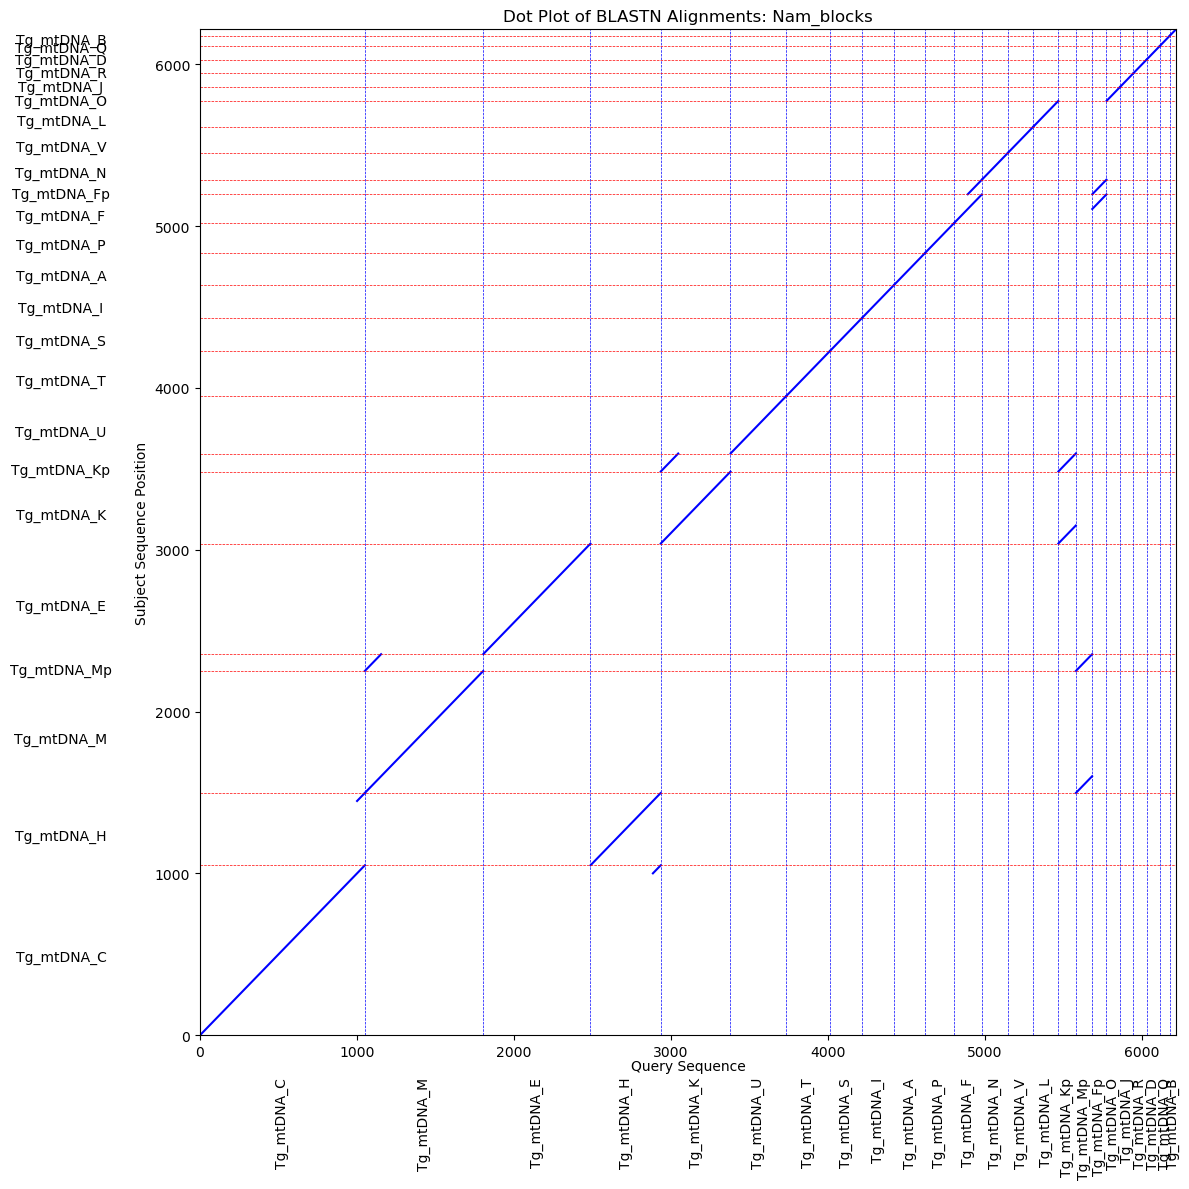

In [135]:
blastn_dotplot(
    work_name='Nam_blocks',
    fasta1='/home/jpereira/OEs/Blocks_Namasivayam.fa',
    fasta2='/home/jpereira/OEs/Blocks_Namasivayam.fa',
    output_base_dir='/home/jpereira/Results/OE1/NamSeqs/Visuals/Blocks',
    word_size=15,
    qnames=True,
    snames=True
)


In [ ]:
# Add the columns block_nums, to numerate the blocks acording to its sizes 
def nummerate_query_sizes(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    Add the colum block_nums to a blastn df. This column asings a rank to each query dependind on it 
    size in nulceotides 
    """
    
    qseqid_arr = df.sort_values(['qlen'],ascending=False)['qseqid'].unique()
    block_number_arr = np.linspace(start=1, stop=len(qseqid_arr), num = len(qseqid_arr))
    block_nums_df_temp = pd.DataFrame({'qseqid' : qseqid_arr, 'block_nums' : block_number_arr })
    block_nums_df_temp['block_nums'] = block_nums_df_temp['block_nums'].astype(int)
    df = pd.merge(df, block_nums_df_temp, on='qseqid', how='left')
    return df

def nummerate_subject_sizes(df: pd.DataFrame) -> pd.DataFrame:
    
    """
    Add the colum block_nums to a blastn df. This column asings a rank to each query dependind on it 
    size in nulceotides 
    """
    
    qseqid_arr = df.sort_values(['slen'],ascending=False)['sseqid'].unique()
    block_number_arr = np.linspace(start=1, stop=len(qseqid_arr), num = len(qseqid_arr))
    block_nums_df_temp = pd.DataFrame({'sseqid' : qseqid_arr, 'block_nums' : block_number_arr })
    block_nums_df_temp['block_nums'] = block_nums_df_temp['block_nums'].astype(int)
    df = pd.merge(df, block_nums_df_temp, on='sseqid', how='left')
    return df

blastn_nam_autobl_df = nummerate_subject_sizes(blastn_nam_autobl_df)


In [ ]:
# Total coverage between block sets

blastn_nam_autobl_df = alignment_absolute_start_end(blastn_nam_autobl_df)
group_nam_autobl_df = blastn_nam_autobl_df.groupby(['qseqid', 'sseqid'])
total_coverage_nam_autobl = group_nam_autobl_df.apply(lambda x: total_coverage_temp(x, use='subject')).reset_index(name='coverage_fraction')
total_coverage_nam_autobl_query = group_nam_autobl_df.apply(lambda x: total_coverage_temp(x, use='query')).reset_index(name='coverage_fraction')

/tmp/ipykernel_2604388/2513262356.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_nam_autobl = group_nam_autobl_df.apply(lambda x: total_coverage_temp(x, use='subject')).reset_index(name='coverage_fraction')
/tmp/ipykernel_2604388/2513262356.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_coverage_nam_autobl_query = group_nam_autobl_df.apply(lambda x: total_coverage_temp(x, use=

In [ ]:
coverage_nam_blocknum_df = pd.merge(total_coverage_nam_autobl, blastn_nam_autobl_df[['sseqid','block_nums']], on='sseqid', how='left' )[['qseqid','block_nums', 'coverage_fraction']]
select = coverage_nam_blocknum_df['qseqid'].isin(['Tg_mtDNA_E','Tg_mtDNA_A', 'Tg_mtDNA_T'])
display(coverage_nam_blocknum_df[select])

select = coverage_nam_blocknum_df['qseqid'].isin(['Tg_mtDNA_V','Tg_mtDNA_S', 'Tg_mtDNA_C', 'Tg_mtDNA_Q' ])
coverage_nam_blocknum_df[select]

,qseqid,block_nums,coverage_fraction
0,Tg_mtDNA_A,23,0.771930
1,Tg_mtDNA_A,19,0.987805
2,Tg_mtDNA_A,8,0.557292
3,Tg_mtDNA_A,8,0.557292
6,Tg_mtDNA_E,2,0.977431
102,Tg_mtDNA_T,4,0.552486
103,Tg_mtDNA_T,4,0.552486
104,Tg_mtDNA_T,8,0.432292
105,Tg_mtDNA_T,8,0.432292


,qseqid,block_nums,coverage_fraction
4,Tg_mtDNA_C,9,0.994505
5,Tg_mtDNA_C,3,0.998221
94,Tg_mtDNA_S,1,0.226164
95,Tg_mtDNA_S,1,0.226164
96,Tg_mtDNA_S,1,0.226164
97,Tg_mtDNA_S,1,0.226164
98,Tg_mtDNA_S,1,0.226164
99,Tg_mtDNA_S,1,0.226164
100,Tg_mtDNA_S,1,0.226164
101,Tg_mtDNA_S,1,0.226164


In [ ]:
# Total coverage of the origianl reads by each set
work_name = 'TGME49_Mit_ONT'
step = 4

original_nam_reads_path = '/home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta' 
save_dir_path = '/home/jpereira/OEs/OE1/Data_output/ISCB_2024'
os.makedirs(save_dir_path, exist_ok=True)

In [ ]:
auto_blocks_path = f'/home/jpereira/OEs/OE1/Data/iterative_extraction_2/fragment_library_5/merged_frags.{work_name}.{step + 1}.fasta'
auto_blocks_nam_reads_tsv = f'/home/jpereira/OEs/OE1/Data/iterative_extraction/blocks_visuals/blastn.Auto_Blocks.Nam_reads.tsv'
os.makedirs(os.path.dirname(auto_blocks_nam_reads_tsv), exist_ok=True)
blastn_subject(blast_input_seqs=auto_blocks_path, blast_subject_seqs=original_nam_reads_path,blast_output_table_tsv=auto_blocks_nam_reads_tsv, 
               word_size=25,penalty=-2, gapopen=2, gap_extend=2)

nam_blocks_path = f'/home/jpereira/OEs/Blocks_Namasivayam.fa'
nam_reads_nam_blocks_tsv = f'/home/jpereira/OEs/OE1/Data/iterative_extraction/blocks_visuals/blastn.Nam_Blocks.Nam_reads.tsv'
blastn_subject(blast_input_seqs=nam_blocks_path, blast_subject_seqs=original_nam_reads_path,blast_output_table_tsv=nam_reads_nam_blocks_tsv, 
               word_size=25,penalty=-2, gapopen=2, gap_extend=2)


Running: blastn -query /home/jpereira/OEs/OE1/Data/iterative_extraction_2/fragment_library_5/merged_frags.TGME49_Mit_ONT.5.fasta -subject /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta -out /home/jpereira/OEs/OE1/Data/iterative_extraction/blocks_visuals/blastn.Auto_Blocks.Nam_reads.tsv -gapextend 2 -gapopen 2 -penalty -2 -word_size 25 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn_subject ran successfully.
Running: blastn -query /home/jpereira/OEs/Blocks_Namasivayam.fa -subject /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta -out /home/jpereira/OEs/OE1/Data/iterative_extraction/blocks_visuals/blastn.Nam_Blocks.Nam_reads.tsv -gapextend 2 -gapopen 2 -penalty -2 -word_size 25 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn_subject ran successfully.


In [ ]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)


def compute_coverage(df, coverage_threshold=0.95, use='subject', cover_type = 'single') -> pd.DataFrame:
    """
    Compute the total coverage per subject or query for the given DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing BLAST output data.
    - coverage_threshold (float): Threshold for alignment coverage (default is 0.95).
    - use (str): 'subject' or 'query' indicating whether to compute coverage per subject or per query.
    - cover_type (str: 'single'|'multi'|'both')

    Returns:
    - pd.DataFrame: DataFrame with added columns for total coverage and total base coverage.
    """
    # Filter alignments with coverage less than the threshold
    df = df[df['length'] / df['qlen'] > coverage_threshold]

    # Compute absolute alignment start and end positions and sort
    df = alignment_absolute_start_end(df).sort_values(['sseqid', 'a.sstart'])

    # Compute total coverage per subject or query
    if cover_type in ['single', 'both']:
        coverage_series = df.groupby('sseqid', group_keys=False).apply(lambda x: total_coverage_temp(x, use=use))
        
        # Convert the Series to a DataFrame and merge it back
        coverage_df = coverage_series.to_frame(name=f'total_cover').reset_index()
        df = pd.merge(df, coverage_df, how='left', on='sseqid')

        # Compute total base coverage
        df[f'total_base_cover'] = df['total_cover'] * df['slen']
    
    if cover_type in ['multi', 'both']:
        coverage_series = df.groupby('sseqid', group_keys=False).apply(lambda x: multimap_coverage(x, use=use))
        
        # Convert the Series to a DataFrame and merge it back
        coverage_df = coverage_series.to_frame(name=f'multimap_total_cover').reset_index()
        df = pd.merge(df, coverage_df, how='left', on='sseqid')

        # Compute total base coverage
        df[f'multimap_total_base_cover'] = df['multimap_total_cover'] * df['slen']

    return df

def reads_cover(df: pd.DataFrame, cover_type: str = 'single') -> float:
    total_slen = df.groupby(['sseqid'])['slen'].first().sum()
    if cover_type == 'single':
        total_base_cover = df.groupby(['sseqid'])['total_base_cover'].first().sum()
    if cover_type == 'multi':
        total_base_cover = df.groupby(['sseqid'])['multimap_total_base_cover'].first().sum()

    return total_base_cover / total_slen


# Define column names for the BLAST output
column_names = [
    'qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen',
    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen'
]

# Read the data with specified column names
nam_reads_blocks_df = pd.read_csv(nam_reads_nam_blocks_tsv, sep='\t', header=None, names=column_names)
auto_blocks_nam_reads_df = pd.read_csv(auto_blocks_nam_reads_tsv, sep='\t', header=None, names=column_names)

# Process the DataFrames to compute coverage
nam_reads_blocks_df = compute_coverage(nam_reads_blocks_df, coverage_threshold=0.0, use='subject', cover_type='both')
auto_blocks_nam_reads_df = compute_coverage(auto_blocks_nam_reads_df, coverage_threshold=0.0, use='subject', cover_type='both')

nam_reads_cover_s95 = reads_cover(nam_reads_blocks_df)
auto_reads_cover_s95 = reads_cover(auto_blocks_nam_reads_df)
print(f'NamBlocks (95%) coverage of Nam reads: {nam_reads_cover_s95}')
print(f'AutoBlocks (95%) coverage of Nam reads: {auto_reads_cover_s95}\n')

nam_reads_cover_m95 = reads_cover(nam_reads_blocks_df, cover_type='multi')
auto_reads_cover_m95 = reads_cover(auto_blocks_nam_reads_df, cover_type='multi')
print(f'Fraction of multimaping coverage of NamBlocks (95%) on Nam reads: {nam_reads_cover_m95/nam_reads_cover_s95}')
print(f'Fraction of multimaping coverage of AutoBlocks (95%) on Nam reads: {auto_reads_cover_m95/auto_reads_cover_s95}\n')

NamBlocks (95%) coverage of Nam reads: 0.9710781163976443
AutoBlocks (95%) coverage of Nam reads: 0.8089128850441375

Fraction of multimaping coverage of NamBlocks (95%) on Nam reads: 0.09796949731106791
Fraction of multimaping coverage of AutoBlocks (95%) on Nam reads: 0.18331040953629957



In [ ]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)


def compute_coverage(df, coverage_threshold=0.95, use='subject', cover_type = 'single') -> pd.DataFrame:
    """
    Compute the total coverage per subject or query for the given DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing BLAST output data.
    - coverage_threshold (float): Threshold for alignment coverage (default is 0.95).
    - use (str): 'subject' or 'query' indicating whether to compute coverage per subject or per query.
    - cover_type (str: 'single'|'multi'|'both')

    Returns:
    - pd.DataFrame: DataFrame with added columns for total coverage and total base coverage.
    """
    # Filter alignments with coverage less than the threshold
    df = df[df['length'] / df['qlen'] > coverage_threshold]

    # Compute absolute alignment start and end positions and sort
    df = alignment_absolute_start_end(df).sort_values(['sseqid', 'a.sstart'])

    # Compute total coverage per subject or query
    if cover_type in ['single', 'both']:
        coverage_series = df.groupby('sseqid', group_keys=False).apply(lambda x: total_coverage_temp(x, use=use))
        
        # Convert the Series to a DataFrame and merge it back
        coverage_df = coverage_series.to_frame(name=f'total_cover').reset_index()
        df = pd.merge(df, coverage_df, how='left', on='sseqid')

        # Compute total base coverage
        df[f'total_base_cover'] = df['total_cover'] * df['slen']
    
    if cover_type in ['multi', 'both']:
        coverage_series = df.groupby('sseqid', group_keys=False).apply(lambda x: multimap_coverage(x, use=use))
        
        # Convert the Series to a DataFrame and merge it back
        coverage_df = coverage_series.to_frame(name=f'multimap_total_cover').reset_index()
        df = pd.merge(df, coverage_df, how='left', on='sseqid')

        # Compute total base coverage
        df[f'multimap_total_base_cover'] = df['multimap_total_cover'] * df['slen']

    return df

def reads_cover(df: pd.DataFrame, cover_type: str = 'single') -> float:
    total_slen = df.groupby(['sseqid'])['slen'].first().sum()
    if cover_type == 'single':
        total_base_cover = df.groupby(['sseqid'])['total_base_cover'].first().sum()
    if cover_type == 'multi':
        total_base_cover = df.groupby(['sseqid'])['multimap_total_base_cover'].first().sum()

    return total_base_cover / total_slen


# Define column names for the BLAST output
column_names = [
    'qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen',
    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen'
]

# Read the data with specified column names
nam_reads_blocks_df = pd.read_csv(nam_reads_nam_blocks_tsv, sep='\t', header=None, names=column_names)
auto_blocks_nam_reads_df = pd.read_csv(auto_blocks_nam_reads_tsv, sep='\t', header=None, names=column_names)

# Process the DataFrames to compute coverage
nam_reads_blocks_df = compute_coverage(nam_reads_blocks_df, coverage_threshold=0.95, use='subject', cover_type='both')
auto_blocks_nam_reads_df = compute_coverage(auto_blocks_nam_reads_df, coverage_threshold=0.95, use='subject', cover_type='both')

nam_reads_cover_s95 = reads_cover(nam_reads_blocks_df)
auto_reads_cover_s95 = reads_cover(auto_blocks_nam_reads_df)
print(f'NamBlocks (95%) coverage of Nam reads: {nam_reads_cover_s95}')
print(f'AutoBlocks (95%) coverage of Nam reads: {auto_reads_cover_s95}\n')

nam_reads_cover_m95 = reads_cover(nam_reads_blocks_df, cover_type='multi')
auto_reads_cover_m95 = reads_cover(auto_blocks_nam_reads_df, cover_type='multi')
print(f'Fraction of multimaping coverage of NamBlocks (95%) on Nam reads: {nam_reads_cover_m95/nam_reads_cover_s95}')
print(f'Fraction of multimaping coverage of AutoBlocks (95%) on Nam reads: {auto_reads_cover_m95/auto_reads_cover_s95}\n')

NamBlocks (95%) coverage of Nam reads: 0.8414431744207187
AutoBlocks (95%) coverage of Nam reads: 0.5186936372286414

Fraction of multimaping coverage of NamBlocks (95%) on Nam reads: 0.03994542679314454
Fraction of multimaping coverage of AutoBlocks (95%) on Nam reads: 0.03670549395261017



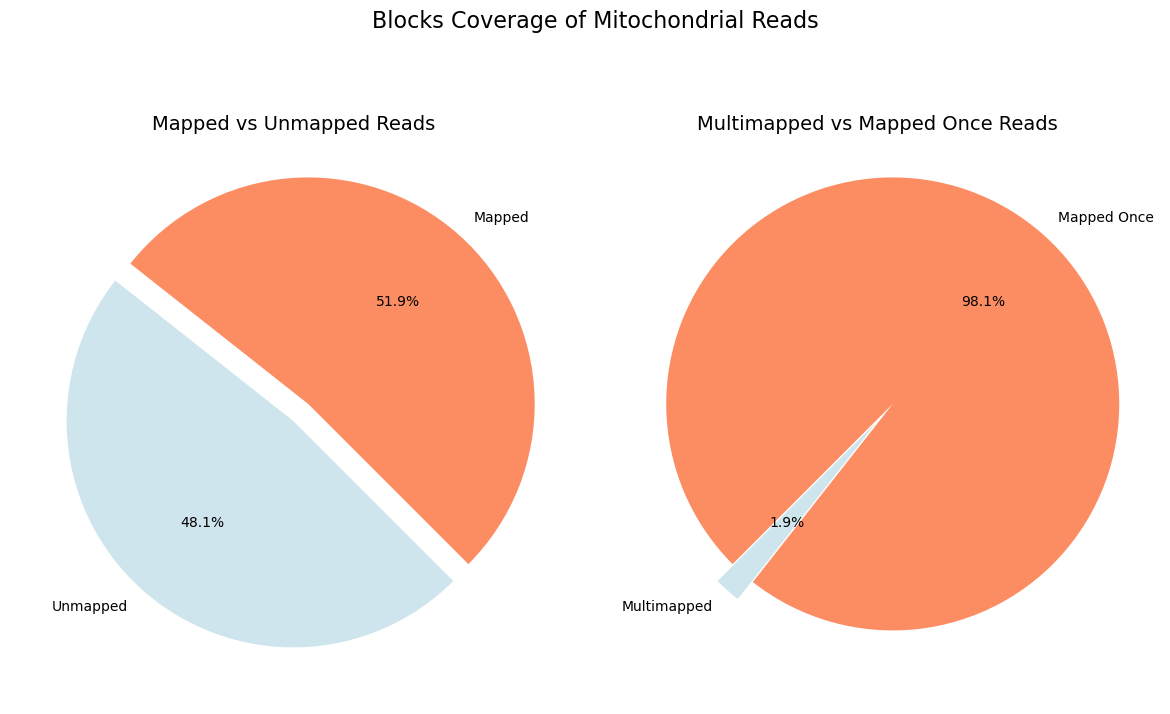

In [ ]:
import matplotlib.pyplot as plt

# Setting up the figure and axes
fig, ax = plt.subplots(figsize=(12, 8), ncols=2)

# Colors for each pie chart
colors_mapped = [ '#fc8d62', '#CEE5ED']
colors_multimapped = ['#CEE5ED', '#fc8d62']

# Explode only the unmapped and multimapped slices for emphasis
explode_mapped = [0.1, 0]
explode_multimapped = [0, 0.1]

# Pie chart 1: Mapped vs Unmapped
ax[0].pie([auto_reads_cover_s95, 1 - auto_reads_cover_s95],
          labels=['Mapped', 'Unmapped'],
          autopct='%1.1f%%',
          startangle=315 ,
          explode=explode_mapped,
          colors=colors_mapped)
ax[0].set_title('Mapped vs Unmapped Reads', fontsize=14)

# Pie chart 2: Multimapped vs Mapped Once
ax[1].pie([auto_reads_cover_m95, 1 - auto_reads_cover_m95],
          labels=['Multimapped', 'Mapped Once'],
          autopct='%1.1f%%',
          startangle=225,
          explode=explode_multimapped,
          colors=colors_multimapped)
ax[1].set_title('Multimapped vs Mapped Once Reads', fontsize=14)

# Main title and layout adjustments
fig.suptitle('Blocks Coverage of Mitochondrial Reads', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(save_dir_path, 'pie_chart.mapped_unnmapped_multimapped.svg'))
plt.show()


In [ ]:
 
qseqid_arr = auto_blocks_nam_reads_df.sort_values(['qlen'],ascending=False)['qseqid'].unique()
block_number_arr = np.linspace(start=1, stop=len(qseqid_arr), num = len(qseqid_arr))
block_nums_df_temp = pd.DataFrame({'qseqid' : qseqid_arr, 'block_nums' : block_number_arr })
auto_blocks_nam_reads_df = pd.merge(auto_blocks_nam_reads_df, block_nums_df_temp, on='qseqid', how='left')


/tmp/ipykernel_2576311/1782640096.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='block_lens', y='block_nums', data=data, palette=palette, ax=axes[0], orient='h')
/tmp/ipykernel_2576311/1782640096.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='block_counts', y='block_nums', data=data, palette=palette, ax=axes[1], orient='h')


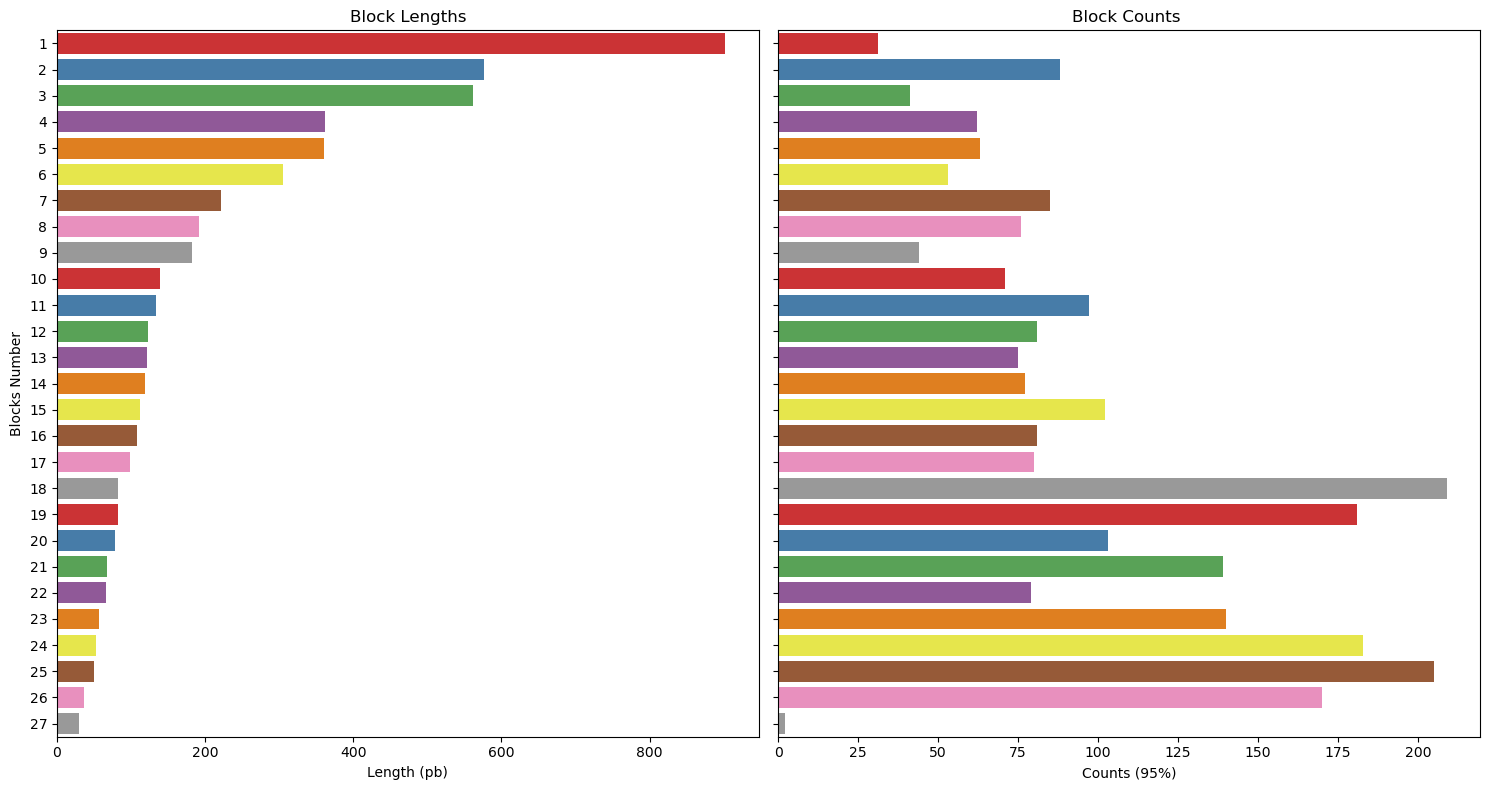

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'auto_blocks_nam_reads_df' is defined

# Apply the selection condition
select = auto_blocks_nam_reads_df['length'] / auto_blocks_nam_reads_df['qlen'] > 0.95
block_nums_df = auto_blocks_nam_reads_df[select]

# Group the DataFrame by 'block_nums'
grouped_block_nums_df = block_nums_df.groupby('block_nums')

# Extract the necessary data
blocks_nums = grouped_block_nums_df['block_nums'].first().astype(int)
block_lens = grouped_block_nums_df['qlen'].first()
block_counts = grouped_block_nums_df['qlen'].count()

# Create a new DataFrame with the extracted data
data = pd.DataFrame({
    'block_nums': blocks_nums,
    'block_lens': block_lens,
    'block_counts': block_counts
}).reset_index(drop=True)

# Set a categorical color palette for 27 categories
palette = sns.color_palette("Set1", 27)

# Create subplots for two horizontal bar plots in the same figure
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

# Second plot: Block Lengths vs Block Numbers
sns.barplot(x='block_lens', y='block_nums', data=data, palette=palette, ax=axes[0], orient='h')
axes[0].set_title('Block Lengths')
axes[0].set_xlabel('Length (pb)')
axes[0].set_ylabel('Blocks Number')  # Hide duplicate y-axis label

# First plot: Block Counts vs Block Numbers
sns.barplot(x='block_counts', y='block_nums', data=data, palette=palette, ax=axes[1], orient='h')
axes[1].set_title('Block Counts ')
axes[1].set_xlabel('Counts (95%)')
#axes[1].set_ylabel('')

# Adjust layout for a cleaner look
plt.tight_layout()
plt.savefig(os.path.join(save_dir_path, 'barplot.block_lengths_counts.svg' ))
plt.show()


# Obtaining fragments mapping statistics 

6b. Mapear MinFrags contra secuencias crudas

7b. Obtención de Stats:

- Identidad entre fragmentos
- Identidad entre fragmentos y Secuencias
- Matriz de Relación Posicional entre fragmentos
- Cobertura total de las secuencias
- Regiones de descubrir los (¿Nuevos Fragmentos?)
- Matriz de Máxima Superposición entre fragmentos (¿Nuevos Fragmentos?)
- Abundancia de los fragmentos


In [ ]:
#import os, subprocess
#import pandas as pd
#
#input_original_reads = '../Data/unmapped_reads.fasta'
#db_out = '../Data/fragments_statistics/unmapped_reads_full_db/'
#input_blocks = '../../Blocks_Namasivayam_without_p.fa'
#
## Mapping Namasivayam blocks to unmapped reads
#blast_output_table_tsv = '../Data/fragments_statistics/blastn.blocks_on_unmapped_reads.tsv'
#blast_db_file = makeblast_db(input_original_reads, db_out)
#blastn(input_blocks, blast_db_file, blast_output_table_tsv, num_threads=30)



Building a new DB, current time: 10/17/2024 23:37:31
New DB name:   /home/jpereira/OEs/OE1/Data/fragments_statistics/unmapped_reads_full_db/unmapped_reads.fasta
New DB title:  ../Data/unmapped_reads.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /home/jpereira/OEs/OE1/Data/fragments_statistics/unmapped_reads_full_db/unmapped_reads.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 4843 sequences in 0.114697 seconds.


makeblastdb ran successfully.
blastn ran successfully.


In [ ]:
import os, subprocess
import pandas as pd

input_original_reads = '/home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta'
db_out =  '/home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads_db'
input_blocks = '../../Blocks_Namasivayam_without_p.fa'

# Mapping Namasivayam blocks to unmapped reads
blast_output_table_tsv = '../Data/fragments_statistics/blastn.Nam_Blocks_on_NamONT.tsv'
blast_db_file = makeblast_db(input_original_reads, db_out)
blastn(input_blocks, blast_db_file, blast_output_table_tsv, word_size=20, num_threads=30)



Building a new DB, current time: 11/04/2024 11:42:46
New DB name:   /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads_db/TGME49_Mit_ONT_reads.fasta
New DB title:  /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads_db/TGME49_Mit_ONT_reads.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 269 sequences in 0.00549793 seconds.


makeblastdb ran successfully.
Running: blastn -query ../../Blocks_Namasivayam_without_p.fa -db /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads_db/TGME49_Mit_ONT_reads.fasta -out ../Data/fragments_statistics/blastn.Nam_Blocks_on_NamONT.tsv -num_threads 30 -gapextend 5 -gapopen 5 -penalty -5 -word_size 20 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn ran successfully.


In [ ]:
import os, subprocess
import pandas as pd


save_dir_path = '/home/jpereira/OEs/OE1/Data_output/ISCB_2024'
graph_plot_path = '/home/jpereira/OEs/OE1/Data_output/ISCB_2024/graph_undirecetd.nam_blocks.svg'

input_original_reads = '/home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta'
db_out =  '/home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads_db'
input_blocks = '/home/jpereira/OEs/OE1/Data/iterative_extraction_2/fragment_library_5/merged_frags.TGME49_Mit_ONT.5.fasta'

# Mapping Namasivayam blocks to unmapped reads
blast_output_table_tsv = '/home/jpereira/OEs/OE1/Data/fragments_statistics/blastn.Auto_blocks_on_NamONT.tsv'
blast_db_file = makeblast_db(input_original_reads, db_out)
blastn(input_blocks, blast_db_file, blast_output_table_tsv, word_size=20, num_threads=30)



Building a new DB, current time: 11/04/2024 11:51:45
New DB name:   /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads_db/TGME49_Mit_ONT_reads.fasta
New DB title:  /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads.fasta
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads_db/TGME49_Mit_ONT_reads.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 269 sequences in 0.00768614 seconds.


makeblastdb ran successfully.
Running: blastn -query /home/jpereira/OEs/OE1/Data/iterative_extraction_2/fragment_library_5/merged_frags.TGME49_Mit_ONT.5.fasta -db /home/jpereira/OEs/OE1/toxo_reads/TGME49_Mit_ONT_reads_db/TGME49_Mit_ONT_reads.fasta -out /home/jpereira/OEs/OE1/Data/fragments_statistics/blastn.Auto_blocks_on_NamONT.tsv -num_threads 30 -gapextend 5 -gapopen 5 -penalty -5 -word_size 20 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bi

In [ ]:
blast_df = pd.read_csv(blast_output_table_tsv, sep='\t', header=None)

blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                    'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

blast_df['qcover'] = blast_df['length'] / blast_df['qlen']

blast_df = alignment_absolute_start_end(blast_df).sort_values('a.sstart') 
group_s_df = pd.DataFrame()
group_s_df['total_scover'] = blast_df.groupby(['sseqid']).apply(total_coverage)
group_s_df = group_s_df.rename( { 0 : 'total_scover'})
blast_tcover_df = pd.merge(blast_df, group_s_df.reset_index(), how='left', on='sseqid')

blast_tcover_dir_df  = blast_tcover_df.copy()
blast_tcover_dir_df['dir_qseqid'] = (
    blast_tcover_df['qseqid'].astype(str) + "_" + blast_tcover_df['dir'].astype(str)
)

def prev_and_next_element(df: pd.DataFrame, col: str, group = 'sseqid' ) -> pd.DataFrame:
    df['prev_element'] = df.groupby([group])[col].shift(1, fill_value='Start')
    df['next_element'] = df.groupby([group])[col].shift(-1, fill_value='End')
    return df

blast_tcover_df = prev_and_next_element(blast_tcover_df, 'qseqid', group = 'sseqid' )
blast_tcover_dir_df = prev_and_next_element(blast_tcover_dir_df, 'dir_qseqid', group = 'sseqid' )

In [ ]:
def describe_blocks(df : pd.DataFrame) -> pd.DataFrame:
    describe_df = df.groupby('dir_qseqid').describe()

    describe_df = describe_df.loc[:, [
                    ('qlen', 'mean'),
                    ('pident', 'count'), ('pident', 'mean'), ('pident', 'std'),
                    ('length', 'mean'), ('length', 'std'),
                    ('qcover', 'mean'), ('qcover', 'std'), ('qcover', 'min'), ('qcover', 'min'), ('qcover', '25%'), ('qcover', '50%'), ('qcover', '75%'), ('qcover', 'max')
                    ]]

    describe_df['qlen_mean'] = describe_df['qlen']['mean']
    describe_df['count'] = describe_df['pident']['count']
    describe_df = describe_df.drop(columns=[('pident', 'count'), ('qlen', 'mean')])

    describe_df = describe_df.rename(columns={'qlen_mean' : 'qlen'})
    describe_df = describe_df[['count', 'qlen', 'length', 'pident',  'qcover']]

    return(describe_df.round(2))

display(describe_blocks(blast_tcover_dir_df).head(5))
display(describe_blocks(blast_tcover_dir_df[blast_tcover_dir_df['qcover'] > 0.95]).head(5))

count   qlen  length  \
                                                                    mean   
dir_qseqid                                                                 
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...   88.0  139.0  123.95   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...   58.0  139.0  125.05   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...   87.0   67.0   66.44   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...   57.0   67.0   64.18   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  131.0   57.0   52.62   

                                                          pident       qcover  \
                                                      std   mean   std   mean   
dir_qseqid                                                                      
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  23.86  99.81  0.37   0.89   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  21.24  99.81  0.42   0.90   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...   3.91  98.35  0.56   0.99   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...   9.05  98.43  0.58   0.96   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...   6.86  99.86  0.49   0.92   

                                                                            \
                                                     std   min   min   25%   
dir_qseqid                                                                   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  0.17  0.15  0.15  0.88   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  0.15  0.29  0.29  0.88   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  0.06  0.49  0.49  1.00   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  0.14  0.40  0.40  1.00   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  0.12  0.40  0.40  0.81   

                                                                     
                                                     50%  75%   max  
dir_qseqid                                                           
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  0.88  1.0  1.01  
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.00  1.0  1.00  
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.00  1.0  1.01  
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.00  1.0  1.00  
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.00  1.0  1.02

count   qlen  length        \
                                                                   mean   std   
dir_qseqid                                                                      
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  41.0  139.0  139.02  0.16   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  30.0  139.0  139.00  0.00   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  84.0   67.0   67.02  0.15   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  50.0   67.0   67.00  0.00   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  85.0   57.0   57.01  0.11   

                                                   pident       qcover       \
                                                     mean   std   mean  std   
dir_qseqid                                                                    
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  99.77  0.37    1.0  0.0   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  99.86  0.29    1.0  0.0   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  98.33  0.54    1.0  0.0   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  98.36  0.45    1.0  0.0   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  99.84  0.51    1.0  0.0   

                                                                             \
                                                    min  min  25%  50%  75%   
dir_qseqid                                                                    
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.0  1.0  1.0  1.0  1.0   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.0  1.0  1.0  1.0  1.0   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.0  1.0  1.0  1.0  1.0   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.0  1.0  1.0  1.0  1.0   
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.0  1.0  1.0  1.0  1.0   

                                                          
                                                     max  
dir_qseqid                                                
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.01  
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.00  
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.01  
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.00  
0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529:...  1.02

In [ ]:
def read_sizes(df: pd.DataFrame, output_tsv : str) -> None:
    slen_sum = df.groupby('sseqid')['slen'].sum()
    slen_count = df.groupby('sseqid')['slen'].count()

    #outout_read_sizes = '/home/jpereira/OEs/OE1/Data_output/read_sizes.tsv'

    slen_size = slen_sum/slen_count
    slen_size.to_csv(output_tsv, sep='\t')

def block_sizes(df : pd.DataFrame, output_tsv: str) -> None:

    #output_block_sizes = '/home/jpereira/OEs/OE1/Data_output/bloc_sizes.tsv'

    block_sum = df.groupby('qseqid')['qlen'].sum()
    block_count =  df.groupby('qseqid')['qlen'].count()
    block_sizes =  block_sum/block_count
    block_sizes.to_csv(output_tsv, sep='\t' )

def encode_blocks(df: pd.DataFrame, output_codified_reads_tsv: str, output_block_sizes_tsv: str, replace_str = 'Tg_mtDNA_') -> None:

    # Replace 'Tg_mtDNA_' from 'qseqid' and store in 'encode' column
    df['encode'] = df['qseqid'].str.replace(replace_str, '')

    # Group by 'sseqid' and apply the blocks_encoding function
    result_df = df.groupby('sseqid').apply(blocks_encoding).reset_index()

    #output_codified_reads = '../Data_output/codified_reads.tsv'

    # Print or inspect the resulting DataFrame
    result_df.to_csv(output_codified_reads_tsv, sep='\t', index=False)

    #output_read_sizes_tsv = '/home/jpereira/OEs/OE1/Data_output/block_sizes.tsv'
    result_df['string_code'].str.len().to_csv(output_block_sizes_tsv, sep='\t')

In [ ]:
def make_abc_graph_df(df: pd.DataFrame, groups: str, replace = 'Tg_mtDNA_') -> pd.DataFrame:
    directed_graph_df = df.sort_values(['sseqid', 'a.sstart']).groupby(groups)[['prev_element', 'next_element']].value_counts().reset_index()
    # Loop through the columns to apply the string replacement
    for col in [groups, 'prev_element', 'next_element']:
        directed_graph_df[col] = directed_graph_df[col].str.replace(replace, '')

    directed_graph_df = directed_graph_df.rename(columns = { groups : 'node', 'prev_element' : 'prev_node', 'next_element' : 'next_node'})

    select_start = directed_graph_df['prev_node'] == 'Start'
    start_df = directed_graph_df[select_start][['node', 'prev_node', 'count']]
    start_df = start_df.rename(columns = { 'node' : 'next_node', 'prev_node': 'node'} )

    directed_graph_df = directed_graph_df[['node', 'next_node', 'count']]
    directed_graph_df = pd.concat([directed_graph_df, start_df])

    directed_graph_df = directed_graph_df.groupby(['node', 'next_node']).sum().reset_index()
    return(directed_graph_df)

directed_graph_df = make_abc_graph_df(blast_tcover_df, groups = 'qseqid' )
select = (directed_graph_df['next_node'] != 'End') & (directed_graph_df['node'] != 'Start')
directed_graph_df2 = directed_graph_df[select]

In [ ]:
directed_graph_df2

,node,next_node,count
0,0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529...,0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529...,2
1,0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529...,0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529...,42
2,0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529...,045e8846-7b26-4032-8f7c-401aeb809523:2314-2865...,1
3,0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529...,125814a8-e82d-46a3-885b-0e10ef185b87:1020-1325...,100
5,0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529...,0102d442-3d3e-4b9b-aa5a-279a3a2d3d4b:1283-1529...,54
...,...,...,...
177,db1f0fd1-22e5-4c16-858d-d9966b9d4752:141-1043:...,7ecb67c4-6ac1-4fc2-8587-73fa980733ed:129-865:2...,213
178,db1f0fd1-22e5-4c16-858d-d9966b9d4752:141-1043:...,81f58bd8-6fd7-4fa0-9c7d-522922e823fb:272-484:2...,7
180,db1f0fd1-22e5-4c16-858d-d9966b9d4752:141-1043:...,a5c59c21-daaa-40e3-9f50-7f39e3b035f7:1506-1768...,66
181,db1f0fd1-22e5-4c16-858d-d9966b9d4752:141-1043:...,a5c59c21-daaa-40e3-9f50-7f39e3b035f7:6665-6739...,1


In [ ]:
for i,row in directed_graph_df2.head(1).iterrows():
    print(row[2])

/tmp/ipykernel_2576311/4068468250.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(row[2].tolist())


AttributeError: 'int' object has no attribute 'tolist'

In [ ]:
def directed_to_undirected_df(df: pd.DataFrame) -> pd.DataFrame:

    def rows_to_sorted_lists( row: pd.DataFrame) -> pd.DataFrame:
        sorted_list = np.sort(row[].tolist())
        return([row[2]]+sorted_list)

    lists_df = df.apply( rows_to_sorted_lists, axis= 1)
    nodes_df = pd.DataFrame(lists_df.to_list(), columns=['count', 'nodeA', 'nodeB'])
    nodes_df['count'] = nodes_df['count'].astype(int)
    nodes_df = nodes_df.groupby(['nodeA', 'nodeB']).sum()
    return(nodes_df.reset_index())

graph_df = directed_to_undirected_df(directed_graph_df)
graph_df2 = directed_to_undirected_df(directed_graph_df2)


/tmp/ipykernel_2576311/2974423334.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return([row[2]]+sorted_list)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U76')) -> None

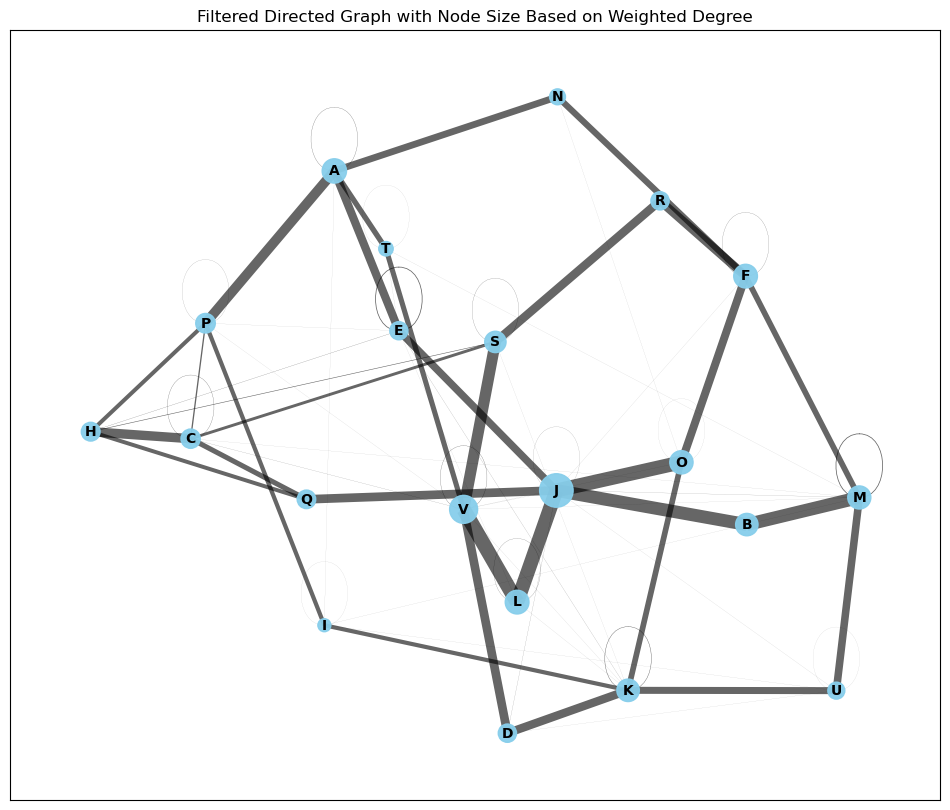

In [ ]:
# TODO:
# Use colors intead of sizes to represent the edges weigth
# Test other layouts
# Define node sizes depending on the block sizes
# Convert to a function 

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

df = graph_df2

# Create directed graph with filtered data
G_filtered = nx.Graph()

# Add edges to the filtered graph
for _, row in df.iterrows():
    nodeA = row['nodeA']
    nodeB = row['nodeB']
    weight = row['count']
    # Add edge with weight to the G_filtered graph
    if weight >= 1: 
        G_filtered.add_edge(nodeA, nodeB, weight=weight)

# Save the filtered graph
nx.write_graphml(G_filtered, '../Data_output/filtered_graph.graphml')

# Use spring layout for positioning
pos = nx.spring_layout(G_filtered, k=0.5)  # Adjust k for spacing

# Save node positions
pos_df = pd.DataFrame.from_dict(pos, orient='index', columns=['x', 'y'])
pos_df.index.name = 'node'
pos_df.reset_index(inplace=True)
pos_df.to_csv('../Data_output/node_positions.csv', index=False)

plt.figure(figsize=(12, 10))

# Compute weighted degree for node size
node_weighted_degree = {
    node: sum(weight['weight'] for _, _, weight in G_filtered.edges(node, data=True)) + 0
          #sum(weight['weight'] for _, _, weight in G_filtered.in_edges(node, data=True))
    for node in G_filtered.nodes()
}

# Save node weighted degrees
node_degree_df = pd.DataFrame.from_dict(node_weighted_degree, orient='index', columns=['weighted_degree'])
node_degree_df.index.name = 'node'
node_degree_df.reset_index(inplace=True)
node_degree_df.to_csv('../Data_output/node_weighted_degree.csv', index=False)

# Set node size based on weighted degree, scale it appropriately
node_size = [node_weighted_degree[node] * 0.7 for node in G_filtered]

# Draw the nodes
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_size, node_color='skyblue', alpha=0.95)

# Draw the edges
edge_weights = [G_filtered[u][v]['weight'] for u, v in G_filtered.edges()]
nx.draw_networkx_edges(G_filtered, pos, width=[weight * 0.05 for weight in edge_weights], alpha=0.6)

# Draw labels
nx.draw_networkx_labels(G_filtered, pos, font_size=10, font_color='black', font_weight='bold')

plt.title("Filtered Directed Graph with Node Size Based on Weighted Degree")

# Save the figure
plt.savefig(save_dir_path, graph_plot_path)

# Display the plot
plt.show()


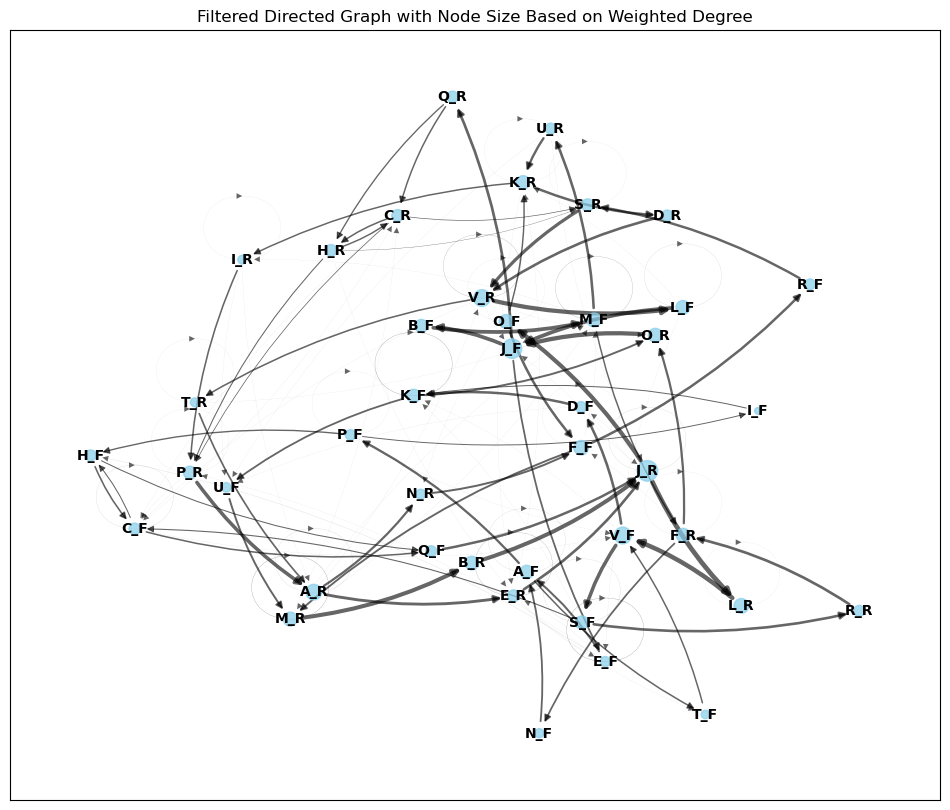

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def plot_directed_graph(df: pd.DataFrame, edge_width : float):
    
    # Create directed graph with filtered data
    G_filtered = nx.DiGraph()

    # Add edges to the filtered graph
    for _, row in df.iterrows():
        nodeA = row['node']
        nodeB = row['next_node']
        weight = row['count']
        if weight >= 1: 
            G_filtered.add_edge(nodeA, nodeB, weight=weight)

    # Save the filtered graph
    nx.write_graphml(G_filtered, '../Data_output/filtered_graph.graphml')

    # Use spring layout for positioning
    pos = nx.spring_layout(G_filtered, k=0.5)  # Adjust k for better spacing

    # Save node positions
    pos_df = pd.DataFrame.from_dict(pos, orient='index', columns=['x', 'y'])
    pos_df.index.name = 'node'
    pos_df.reset_index(inplace=True)
    pos_df.to_csv('../Data_output/node_positions.csv', index=False)

    plt.figure(figsize=(12, 10))

    # Compute weighted degree for node size
    node_weighted_degree = {
        node: sum(weight['weight'] for _, _, weight in G_filtered.edges(node, data=True)) +
              sum(weight['weight'] for _, _, weight in G_filtered.in_edges(node, data=True))
        for node in G_filtered.nodes()
    }

    # Save node weighted degrees
    node_degree_df = pd.DataFrame.from_dict(node_weighted_degree, orient='index', columns=['weighted_degree'])
    node_degree_df.index.name = 'node'
    node_degree_df.reset_index(inplace=True)
    node_degree_df.to_csv('../Data_output/node_weighted_degree.csv', index=False)

    # Set node size based on weighted degree
    node_size = [node_weighted_degree[node] * 0.5 for node in G_filtered]

    # Draw the nodes
    nx.draw_networkx_nodes(G_filtered, pos, node_size=node_size, node_color='skyblue', alpha=0.7)

    # Draw the edges with curved connections to avoid overlap
    edge_weights = [G_filtered[u][v]['weight'] for u, v in G_filtered.edges()]
    nx.draw_networkx_edges(
        G_filtered, pos, 
        width=[weight * edge_width for weight in edge_weights], 
        alpha=0.6, 
        connectionstyle="arc3,rad=0.1"  # Curved edges with a fixed radius
    )

    # Draw labels
    nx.draw_networkx_labels(G_filtered, pos, font_size=10, font_color='black', font_weight='bold')

    plt.title("Filtered Directed Graph with Node Size Based on Weighted Degree")

    # Save the figure
    plt.savefig('../Data_output/filtered_graph.png', dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

df1 = directed_graph_df2 
df2 = directed_graph_df2[(directed_graph_df2['node'] != 'J') & (directed_graph_df2['next_node'] != 'B')]

plot_directed_graph(df1, edge_width = 0.03)
plot_directed_graph(df1, edge_width = 0.03)


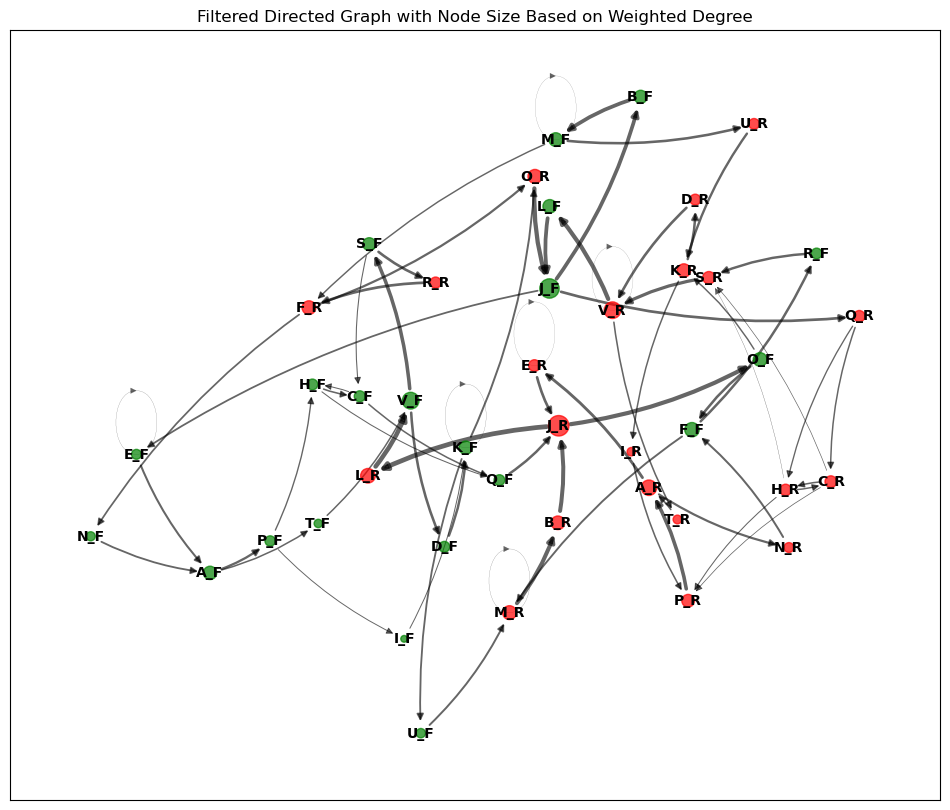

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

def plot_directed_graph(df: pd.DataFrame, edge_width: float):
    # Create directed graph with filtered data
    G_filtered = nx.DiGraph()

    # Add edges to the filtered graph
    for _, row in df.iterrows():
        nodeA = row['node']
        nodeB = row['next_node']
        weight = row['count']
        if weight >= 3:
            G_filtered.add_edge(nodeA, nodeB, weight=weight)

    # Save the filtered graph
    nx.write_graphml(G_filtered, '../Data_output/filtered_graph.graphml')

    # Use spring layout for positioning
    pos = nx.spring_layout(G_filtered, k=0.5)  # Adjust k for better spacing

    # Save node positions
    pos_df = pd.DataFrame.from_dict(pos, orient='index', columns=['x', 'y'])
    pos_df.index.name = 'node'
    pos_df.reset_index(inplace=True)
    pos_df.to_csv('../Data_output/node_positions.csv', index=False)

    plt.figure(figsize=(12, 10))

    # Compute weighted degree for node size
    node_weighted_degree = {
        node: sum(weight['weight'] for _, _, weight in G_filtered.edges(node, data=True)) +
              sum(weight['weight'] for _, _, weight in G_filtered.in_edges(node, data=True))
        for node in G_filtered.nodes()
    }

    # Save node weighted degrees
    node_degree_df = pd.DataFrame.from_dict(node_weighted_degree, orient='index', columns=['weighted_degree'])
    node_degree_df.index.name = 'node'
    node_degree_df.reset_index(inplace=True)
    node_degree_df.to_csv('../Data_output/node_weighted_degree.csv', index=False)

    # Set node size based on weighted degree
    node_size = [node_weighted_degree[node] * 0.5 for node in G_filtered]

    # Assign colors based on whether the node name ends with 'R' or 'F'
    node_colors = [
        'red' if str(node).endswith('R') else 'green' if str(node).endswith('F') else 'skyblue'
        for node in G_filtered.nodes()
    ]

    # Draw the nodes with the specified colors
    nx.draw_networkx_nodes(
        G_filtered, pos, 
        node_size=node_size, 
        node_color=node_colors, 
        alpha=0.7
    )

    # Draw the edges with curved connections to avoid overlap
    edge_weights = [G_filtered[u][v]['weight'] for u, v in G_filtered.edges()]
    nx.draw_networkx_edges(
        G_filtered, pos,
        width=[weight * edge_width for weight in edge_weights],
        alpha=0.6,
        connectionstyle="arc3,rad=0.1"  # Curved edges with a fixed radius
    )

    # Draw labels
    nx.draw_networkx_labels(G_filtered, pos, font_size=10, font_color='black', font_weight='bold')

    plt.title("Filtered Directed Graph with Node Size Based on Weighted Degree")

    # Save the figure
    plt.savefig('../Data_output/filtered_graph.png', dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()
    return(G_filtered)
# Example usage
df1 = directed_graph_df2
df2 = directed_graph_df2[(directed_graph_df2['node'] != 'J') & (directed_graph_df2['next_node'] != 'B')]

G = plot_directed_graph(df1, edge_width=0.03)


In [ ]:
cycles = nx.simple_cycles(G)
cycle_lens = []
for cycle in list(cycles):
    cycle_lens.append(len(cycle))

In [ ]:
list(cycles)

[]

<Axes: ylabel='Count'>

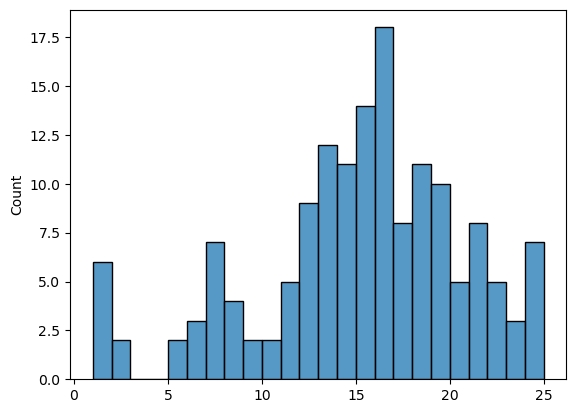

In [ ]:
import seaborn as sns
sns.histplot(cycle_lens, binwidth=1)

AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

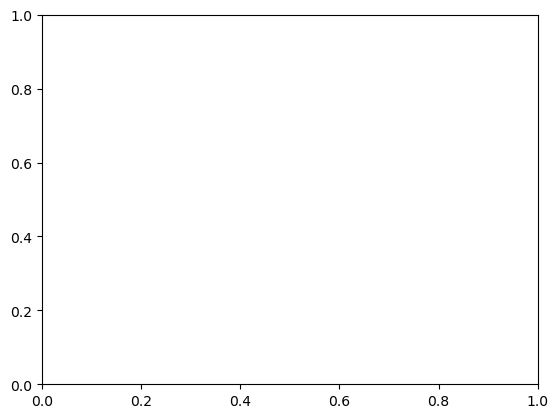

In [ ]:
import itertools as it
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


def draw_labeled_multigraph(G, attr_name, ax=None):
    """
    Length of connectionstyle must be at least that of a maximum number of edges
    between pair of nodes. This number is maximum one-sided connections
    for directed graph and maximum total connections for undirected graph.
    """
    # Works with arc3 and angle3 connectionstyles
    connectionstyle = [f"arc3,rad={r}" for r in it.accumulate([0.15] * 4)]
    # connectionstyle = [f"angle3,angleA={r}" for r in it.accumulate([30] * 4)]

    pos = nx.shell_layout(G)
    nx.draw_networkx_nodes(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=20, ax=ax)
    nx.draw_networkx_edges(
        G, pos, edge_color="grey", connectionstyle=connectionstyle, ax=ax
    )

    labels = {
        tuple(edge): f"{attr_name}={attrs[attr_name]}"
        for *edge, attrs in G.edges(keys=True, data=True)
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        labels,
        connectionstyle=connectionstyle,
        label_pos=0.3,
        font_color="blue",
        bbox={"alpha": 0},
        ax=ax,
    )

nodes = "ABCD"
prod = list(it.product(nodes, repeat=2))


fig, axes = plt.subplots(1, 1)
ax = np.ravel(axes)
G = nx.MultiDiGraph()
for i, (u, v) in enumerate(prod):
    G.add_edge(u, v, w=round(i / 3, 2))
draw_labeled_multigraph(G, "w", ax)
fig.tight_layout()
plt.show()

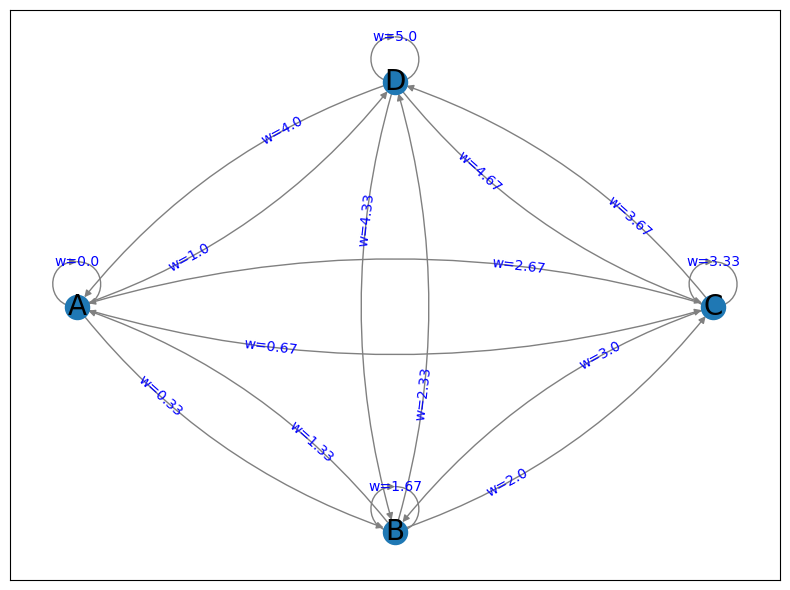

In [ ]:
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

# Define nodes and generate all possible pairs of nodes (including self-loops)
nodes = "ABCD"
prod = list(it.product(nodes, repeat=2))

# Create a MultiDiGraph
G = nx.MultiDiGraph()

# Add edges with weights (incremental weights)
for i, (u, v) in enumerate(prod):
    G.add_edge(u, v, w=round(i / 3, 2))  # Weight of the edge

# Create a Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(8, 6))  # Use ax directly, no need to ravel

# Draw the multi-graph with labeled edges
draw_labeled_multigraph(G, "w", ax)

# Adjust layout and show the plot
fig.tight_layout()
plt.show()


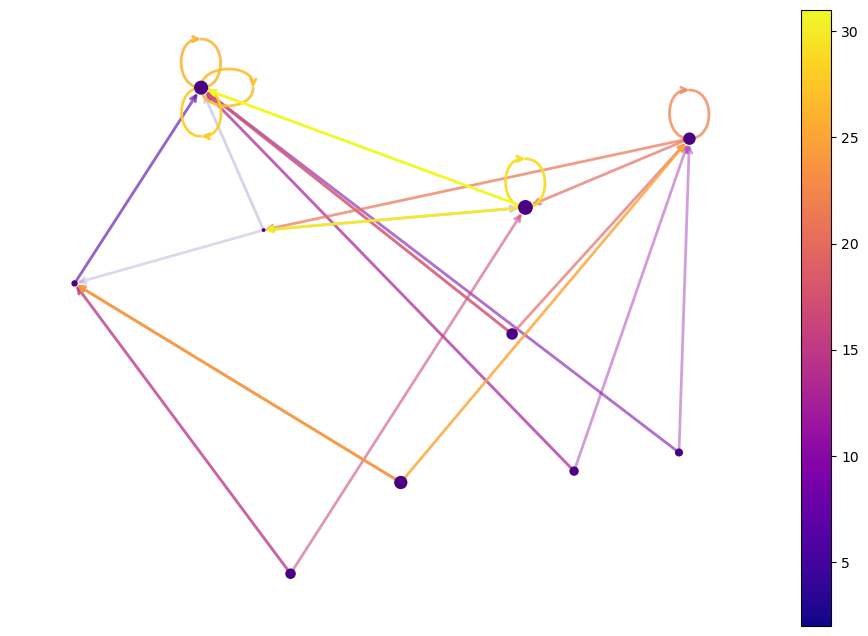

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

seed = 3648  # Seed random number generators for reproducibility
G = nx.random_k_out_graph(10, 3, 0.5, seed=seed)
pos = nx.spring_layout(G, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

plt.figure(figsize=(12,8))

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)

ax = plt.gca()
ax.set_axis_off()
plt.colorbar(pc, ax=ax)
plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Sample data (replace this with your actual DataFrame)

# Create directed graph
G_filtered = nx.DiGraph()

# Add edges for previous connections (incoming)
for _, row in df.iterrows():
    prev_element = row['prev_element']
    qseqid = row['qseqid']
    weight = row['count']
    G_filtered.add_edge(prev_element, qseqid, weight=weight, connection_type='incoming')

# Add edges for next connections (outgoing)
for _, row in df.iterrows():
    qseqid = row['qseqid']
    next_element = row['next_element']
    weight = row['count']
    G_filtered.add_edge(qseqid, next_element, weight=weight, connection_type='outgoing')

# Use spring layout for positioning
pos = nx.spring_layout(G_filtered, k=0.5)

plt.figure(figsize=(12, 10))

# Draw the nodes
node_size = [G_filtered.degree(node) * 30 for node in G_filtered]
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_size, node_color='skyblue', alpha=0.7)

# Draw the outgoing edges with one style (solid line)
outgoing_edges = [(u, v) for u, v, d in G_filtered.edges(data=True) if d['connection_type'] == 'outgoing']
outgoing_edge_weights = [G_filtered[u][v]['weight'] for u, v in outgoing_edges]
nx.draw_networkx_edges(G_filtered, pos, edgelist=outgoing_edges, edge_color='green', width=[weight * 0.3 for weight in outgoing_edge_weights], alpha=0.6, style='solid')

## Draw the incoming edges with another style (dashed line)
#incoming_edges = [(u, v) for u, v, d in G_filtered.edges(data=True) if d['connection_type'] == 'incoming']
#incoming_edge_weights = [G_filtered[u][v]['weight'] for u, v in incoming_edges]
#nx.draw_networkx_edges(G_filtered, pos, edgelist=incoming_edges, edge_color='red', width=[weight * 0.3 for weight in incoming_edge_weights], alpha=0.6, style='dashed')


## Draw the outgoing edges with one style (solid line)
#outgoing_edges = [(u, v) for u, v, d in G_filtered.edges(data=True) if d['connection_type'] == 'outgoing']
#nx.draw_networkx_edges(G_filtered, pos, edgelist=outgoing_edges, edge_color='green', width=2, alpha=0.6, style='solid')
#
## Draw the incoming edges with another style (dashed line)
#incoming_edges = [(u, v) for u, v, d in G_filtered.edges(data=True) if d['connection_type'] == 'incoming']
#nx.draw_networkx_edges(G_filtered, pos, edgelist=incoming_edges, edge_color='red', width=2, alpha=0.6, style='dashed')

# Draw labels
nx.draw_networkx_labels(G_filtered, pos, font_size=10, font_color='black', font_weight='bold')

# Add edge labels if needed (use sparingly to avoid clutter)
edge_labels = nx.get_edge_attributes(G_filtered, 'weight')
nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_labels, font_size=8)

plt.title("Directed Graph with Distinct Edge Styles for Previous and Next Connections")
plt.show()


KeyError: 'qseqid'

In [ ]:
G_filtered.add_edge(1,2, connection_type = )

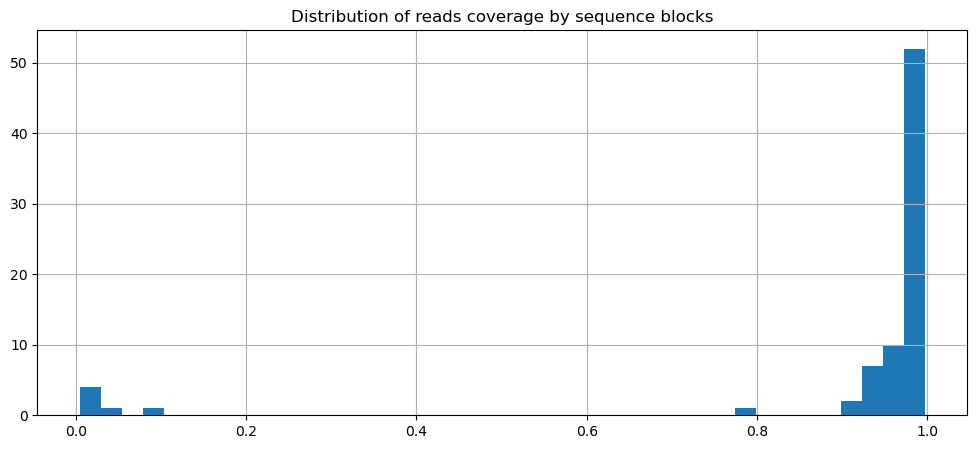

In [ ]:


merge_blast_tcover_df.groupby('sseqid')['total_scover'].describe().hist('mean', bins=40, figsize=(12,5))
plt.title('Distribution of reads coverage by sequence blocks')  # Add your custom title here
plt.show()  # Display the plot


In [ ]:
# After mapping the putative blocks with the reads, the following algorithms would be 
# usefull to start/continue the block refinement.
#   - Make new blocks with the unammped sections of the reads   
#   - Make new blocks with superposed blocks alignments
# 
# The following stats/plots colud be an usefull supplement to 
# check the block qualities
#   - A heatmap with identity values between blocks
#   - A table with identity values between blocks and fragments
#   - A heatmap/table showing the mean/median/min/max number nucleotides of separation/superposition between 
#   - blocks
#   - Tables between mean and quaritles values of identity between blocks and reads 

# Section with test/sketch code

In [ ]:
## Extract denoised fragments
## Map the fragments against the crude reads
## - Extrac clustered reads from the orignal fasta file
## Make the stats

### Old function definitions

In [ ]:
import os
import subprocess
import pandas as pd

def makeblast_db(seqs_path: str, db_out: str, show_command: bool = False) -> str:
    os.makedirs(db_out, exist_ok=True)
    db_file = os.path.join(db_out, os.path.basename(seqs_path))
    command = (f"makeblastdb -in {seqs_path} -dbtype nucl -out {db_file}")
    
    if show_command:
        print("Running:", command)
    
    try:
        subprocess.run(command, shell=True, check=True)
        print('makeblastdb ran successfully.')
    except subprocess.CalledProcessError as e:
        print('Error in running makeblastdb:', e)
    
    return db_file

def blastn(blast_input_seqs: str, blast_db_file: str, blast_output_table_tsv: str,
            num_threads: int = 10, gap_extend: int = 5, gapopen: int = 5, penalty: int = -5, 
            word_size: int = 25, show_command: bool = True) -> None:
    command = (
        f"blastn -query {blast_input_seqs} -db {blast_db_file} -out {blast_output_table_tsv} "
        f"-num_threads {num_threads} -gapextend {gap_extend} -gapopen {gapopen} -penalty {penalty} "
        f"-word_size {word_size} -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'"
    )

    if show_command:
        print("Running:", command)

    try:
        subprocess.run(command, shell=True, check=True)
        print('blastn ran successfully.')
    except subprocess.CalledProcessError as e:
        print('Error in running blastn:', e)

def vsearch_cluster_unoise(fasta_file: str, fasta_denoised_file: str, maxseqlength: int = 100000, 
                           minseqlength: int = 25, minsize: int = 1, unoise_alpha: float = 2.0, 
                           sizein: bool = False, sizeout: bool = False) -> None:
    command = [
        'vsearch', '--cluster_unoise', fasta_file, '--centroids', fasta_denoised_file,
        '--maxseqlength', str(maxseqlength), '--minseqlength', str(minseqlength),
        '--minsize', str(minsize), '--unoise_alpha', str(unoise_alpha)
    ]
    
    if sizein:
        command.append('--sizein')
    if sizeout:
        command.append('--sizeout')
    
    print("Running command:", " ".join(command))

    try:
        subprocess.run(command, check=True)
        print("vsearch ran successfully.")
    except subprocess.CalledProcessError as e:
        print("Error in running vsearch:", e)

import subprocess

def vsearch_cluster_fast(fasta_file: str, fasta_clustered_file: str, identity: float = 0.99, 
                         maxseqlength: int = 100000, minseqlength: int = 25, 
                         sizein: bool = False, sizeout: bool = False) -> None:
    """
    Clusters sequences using VSEARCH's --cluster_fast option, joining sequences with high similarity.
    
    Args:
        fasta_file (str): Path to the input FASTA file containing sequences to be clustered.
        fasta_clustered_file (str): Path to the output FASTA file with cluster centroids.
        identity (float): Similarity threshold for clustering. Default is 0.99 (99%).
        maxseqlength (int): Maximum sequence length. Default is 100000.
        minseqlength (int): Minimum sequence length. Default is 25.
        sizein (bool): Whether to retain size information from input sequences. Default is False.
        sizeout (bool): Whether to include size information in output sequences. Default is False.
    """
    
    # Construct the vsearch command
    command = [
        'vsearch', '--cluster_fast', fasta_file,
        '--centroids', fasta_clustered_file,
        '--id', str(identity),
        '--maxseqlength', str(maxseqlength),
        '--minseqlength', str(minseqlength)
    ]
    
    # Conditionally add sizein and sizeout flags
    if sizein:
        command.append('--sizein')
    if sizeout:
        command.append('--sizeout')
    
    # Print the command for debugging
    print("Running command:", " ".join(command))
    
    # Run the command
    try:
        subprocess.run(command, check=True)
        print("vsearch ran successfully.")
    except subprocess.CalledProcessError as e:
        print("Error in running vsearch:", e)

# Example usage:
# vsearch_cluster_fast("input_sequences.fasta", "clustered_sequences.fasta", identity=0.97)


def bedtools_getfasta(fasta_path: str, bed_path: str, extracted_regions_path: str, show_command: bool = False) -> None:
    command = f'bedtools getfasta -fi {fasta_path} -bed {bed_path} -fo {extracted_regions_path}'
    if show_command:
        print("Running:", command)

    try:
        subprocess.run(command, check=True, shell=True)
        print("bedtools ran successfully.")
    except subprocess.CalledProcessError as e:
        print("Error in running bedtools:", e)



In [ ]:
def makeblast_db(seqs_path: str, db_out: str, show_command = False) -> str:
    os.makedirs(db_out, exist_ok=True)
    db_file = os.path.join(db_out, os.path.basename(seqs_path))
    command = (f"makeblastdb "
               f" -in {seqs_path}"
               f" -dbtype nucl"
               f" -out {db_file}" )
    
    if show_command:
        print(command)
    
    try:
        subprocess.run(command, shell=True, check=True)
        print('makeblastdb ran successfully.')
    except subprocess.CalledProcessError as e:
        print('Error in running makeblastdb: ', e)
    
    return(db_file)

def blastn(blast_input_seqs: str,  blast_db_file: str, blast_output_table_tsv: str,
            num_threads = 10, gap_extend = 5, gapopen = 5, penalty = -5, word_size = 25, show_command = True) -> None:
    
    working_dir = os.path.dirname(blast_output_table_tsv)
    os.makedirs(working_dir, exist_ok = True)
    
    command = (
        f"blastn "
        f"-query {blast_input_seqs} "
        f"-db {blast_db_file} "
        f"-out {blast_output_table_tsv} "
        f"-num_threads {str(num_threads)} "
        f"-gapextend {str(gap_extend)} "
        f"-gapopen {str(gapopen)} "
        f"-penalty {str(penalty)} "
        f"-word_size {str(word_size)} "
        f"-outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'"
    )

    if show_command:
        print(command)

    try:
        subprocess.run(command, shell=True, check=True)
        print('blastn ran successfully.')
    except subprocess.CalledProcessError as e:
        print('Error in running blastn: ', e)
    
    return

def vsearch_cluster_unoise(
    fasta_file: str,
    fasta_denoised_file: str,
    maxseqlength=100000,
    minseqlength=25,
    minsize=1,
    unoise_alpha=2.0,
    sizein=False,
    sizeout=False
):
    """
    This function takes a significant amount of time to complete its execution.
    Therefore, it would be convenient to assign it to its own Snakemake rule.
    """
    
    # Construct the vsearch command
    command = [
        'vsearch',
        '--cluster_unoise', fasta_file,
        '--centroids', fasta_denoised_file,
        '--maxseqlength', str(maxseqlength),
        '--minseqlength', str(minseqlength),
        '--minsize', str(minsize),
        '--unoise_alpha', str(unoise_alpha)
    ]
    
    # Conditionally add sizein and sizeout flags
    if sizein:
        command.append('--sizein')
    if sizeout:
        command.append('--sizeout')
    
    # Print the command for debugging
    print("Running command:", " ".join(command))
    
    # Run the command
    try:
        subprocess.run(command, check=True)
        print("vsearch ran successfully.")
    except subprocess.CalledProcessError as e:
        print("Error in running vsearch:", e)

    return

def bedtools_getfasta(fasta_path: str, bed_path: str, extracted_regions_path: str, show_command = False):
    # Construct the command string
    command = f'bedtools getfasta -fi {fasta_path} -bed {bed_path} -fo {extracted_regions_path}'
    if show_command:
        print(command)

    try:
        # Run the command using subprocess
        subprocess.run(command, check=True, shell=True)
        print("bedtools ran successfully.")
    except subprocess.CalledProcessError as e:
        print("Error in running bedtools:", e)

### Old iterative Extraction worflow

In [ ]:
# Main workflow setup
work_name = 'TGME49_Mit_ONT'
input_fragments_path = '/home/jpereira/OEs/OE1/Data/fragment_library/denoised_fragments.TGME49_Mit_ONT.fasta'

for step in range(5):
    library_dir = f'/home/jpereira/OEs/OE1/Data/iterative_extraction/fragment_library_{step}/'
    os.makedirs(library_dir, exist_ok=True)

    if step > 0:
        input_fragments_path = os.path.join(library_dir, f'merged_frags.{work_name}.{step}.fasta')

    extracted_regions_path = os.path.join(library_dir, f'extracted_regions.{work_name}.{step}.fasta')
    db_outdir = os.path.join(library_dir, f'db_{work_name}.{step}')

    print(f'\nMAKEBLAST_DB STEP: {step}')
    blast_db_file = makeblast_db(seqs_path=input_fragments_path, db_out=db_outdir)

    print(f'\nBLASTN STEP: {step}')
    blast_output_table = os.path.join(library_dir, f'blastn.inner.{work_name}.{step}.tsv')
    blastn(blast_input_seqs=input_fragments_path, blast_db_file=blast_db_file, blast_output_table_tsv=blast_output_table, num_threads=15)

    # Load blastn table
    blast_df = pd.read_csv(blast_output_table, sep='\t', header=None)
    blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

    # Prepare BED dataframe
    bed_df = blast_df[['qseqid', 'qstart', 'qend']].copy()
    bed_df['qstart'] -= 1

    bed_path = os.path.join(library_dir, f'fragments.{work_name}.{step}.bed')
    bed_df.to_csv(bed_path, sep='\t', header=None, index=False)

    print(f'\nBEDTOOLS_GETFASTA STEP: {step}')
    bedtools_getfasta(fasta_path=input_fragments_path, bed_path=bed_path, extracted_regions_path=extracted_regions_path, show_command=True)

    denoised_fragments_path = os.path.join(library_dir, f'denoised_frags.{work_name}.{step}.fasta')
    print(f'\nVSEARCH_CLUSTER_UNOISE STEP: {step}')
    vsearch_cluster_unoise(fasta_file=extracted_regions_path, fasta_denoised_file=denoised_fragments_path, minsize=1)

    next_library_dir = f'/home/jpereira/OEs/OE1/Data/iterative_extraction/fragment_library_{step+1}/'
    os.makedirs(next_library_dir, exist_ok=True)
    merged_fragments_path = os.path.join(next_library_dir, f'merged_frags.{work_name}.{step+1}.fasta')
    vsearch_cluster_fast(fasta_file = denoised_fragments_path, fasta_clustered_file = merged_fragments_path, identity = 0.95, 
                         maxseqlength = 100000, minseqlength = 25, 
                         sizein = False, sizeout = False)




In [ ]:
import os
import pandas as pd

# Main workflow setup
work_name = 'TGME49_Mit_ONT'
input_fragments_path = '/home/jpereira/OEs/OE1/Data/fragment_library/denoised_fragments.TGME49_Mit_ONT.fasta'

for step in range(5):
    library_dir = f'/home/jpereira/OEs/OE1/Data/iterative_extraction/fragment_library_{step}/'
    os.makedirs(library_dir, exist_ok=True)

    # Update input file for iterations after the first step
    if step > 0:
        input_fragments_path = os.path.join(library_dir, f'merged_frags.{work_name}.{step}.fasta')

    # Define paths for extracted regions and BLAST database output
    extracted_regions_path = os.path.join(library_dir, f'extracted_regions.{work_name}.{step}.fasta')
    db_outdir = os.path.join(library_dir, f'db_{work_name}.{step}')

    # Step 1: Create BLAST database
    print(f'\nMAKEBLAST_DB STEP: {step}')
    blast_db_file = makeblast_db(seqs_path=input_fragments_path, db_out=db_outdir)

    # Step 2: Perform BLASTN search
    print(f'\nBLASTN STEP: {step}')
    blast_output_table = os.path.join(library_dir, f'blastn.inner.{work_name}.{step}.tsv')
    blastn(blast_input_seqs=input_fragments_path, blast_db_file=blast_db_file, blast_output_table_tsv=blast_output_table, num_threads=15)

    # Step 3: Load BLAST results into a DataFrame
    blast_df = pd.read_csv(blast_output_table, sep='\t', header=None)
    blast_df.columns = ['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 
                        'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore', 'qlen', 'slen']

    # Step 4: Create BED file for sequence extraction
    bed_df = blast_df[['qseqid', 'qstart', 'qend']].copy()
    bed_df['qstart'] -= 1  # Adjust start coordinate for BED format
    bed_path = os.path.join(library_dir, f'fragments.{work_name}.{step}.bed')
    bed_df.to_csv(bed_path, sep='\t', header=None, index=False)

    # Step 5: Extract FASTA sequences based on BED coordinates
    print(f'\nBEDTOOLS_GETFASTA STEP: {step}')
    bedtools_getfasta(fasta_path=input_fragments_path, bed_path=bed_path, extracted_regions_path=extracted_regions_path, show_command=True)

    # Step 6: Denoise extracted sequences
    denoised_fragments_path = os.path.join(library_dir, f'denoised_frags.{work_name}.{step}.fasta')
    print(f'\nVSEARCH_CLUSTER_UNOISE STEP: {step}')
    vsearch_cluster_unoise(fasta_file=extracted_regions_path, fasta_denoised_file=denoised_fragments_path, minsize=1)

    # Step 7: Cluster similar sequences and prepare for the next iteration
    next_library_dir = f'/home/jpereira/OEs/OE1/Data/iterative_extraction/fragment_library_{step+1}/'
    os.makedirs(next_library_dir, exist_ok=True)
    merged_fragments_path = os.path.join(next_library_dir, f'merged_frags.{work_name}.{step+1}.fasta')
    print(f'\nVSEARCH_CLUSTER_FAST STEP: {step}')
    vsearch_cluster_fast(
        fasta_file=denoised_fragments_path,
        fasta_clustered_file=merged_fragments_path,
        identity=0.95,
        maxseqlength=100000,
        minseqlength=25,
        sizein=False,
        sizeout=False
    )


### Visualize the last to blocks of each read from result_df

In [ ]:
import seaborn as sns

select =  result_df['string_code'].str.len() > 2
big_strings = result_df[select]
big_strings = big_strings['string_code'].str.replace('p','') 
last_two = big_strings.str[-2:]
last_two_counts = last_two.value_counts()
last_two_counts = last_two_counts.to_dict()

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(last_two_counts.items()), columns=['last_two_chars', 'count'])

# Create a bar plot
plt.figure(figsize=(15, 6))
sns.barplot(x='last_two_chars', y='count', data=df, palette="Blues_d")

# Improve aesthetics
plt.title('Frequency of Last Two Blocks', fontsize=16)
plt.xlabel('Last Two Characters', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.show()

import numpy as np
block_set = set(last_two.sum())

matrix  = np.zeros(len(block_set))
for block_x in block_set:
    for block_y in block_set:
        block = block_x + block_y
        if block in set(last_two_counts.keys()):
            matrix[block_x, block_y] = last_two_counts['block']
        else:
            matrix[block_x, block_y] = 0


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assume last_two is a list of blocks (e.g., ['ab', 'cd', 'ef']) and last_two_counts is a dictionary
# last_two_counts contains the count for each block combination like {'abef': 5, 'cdab': 3}
block_set = set(last_two.sum())

# Create an index mapping for blocks to use in the matrix
block_list = list(block_set)  # Convert set to list to index blocks
block_index = {block: idx for idx, block in enumerate(block_list)}

# Initialize a 2D matrix
matrix = np.zeros((len(block_set), len(block_set)))

# Fill the matrix based on block combinations
for block_x in block_set:
    for block_y in block_set:
        combined_block = block_x + block_y
        if combined_block in last_two_counts:
            # Use the index to place the count in the correct location
            matrix[block_index[block_x], block_index[block_y]] = last_two_counts[combined_block]
        else:
            matrix[block_index[block_x], block_index[block_y]] = 0

# Create the heatmap with custom labels
plt.figure(figsize=(10, 12))
sns.clustermap(matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=block_list, yticklabels=block_list)

# Customize the plot
plt.title("Heatmap of Block Combinations", fontsize=16)
plt.xlabel("Block X", fontsize=12)
plt.ylabel("Block Y", fontsize=12)

# Show the plot
plt.show()
        
